In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
from abc import abstractmethod
from collections import defaultdict
from functools import lru_cache
from itertools import count
from typing import List, Dict
from typing import Tuple, Any
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from torch.nn import MSELoss, LSTM, GRU, RNN, L1Loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
from importlib import reload
from config import Config
import config
from data import MDataset, Graph, GraphNode, load_graphs, save_dataset_pkl, load_dataset_pkl, save_scalers_pkl, load_scalers_pkl
import data
from base_module import MModule, pad_np_vectors
import base_module
from executor import single_train_loop, nested_detach, grid_search_loop
import executor
from objects import ModelType
import objects
from metric import MetricUtil
import metric
from logger import init_logging, logging
import logger
import gcn
from gcn import GCNLayer
import transformer
from transformer import TransformerModel
reload(config)
reload(data)
reload(base_module)
reload(executor)
reload(objects)
reload(metric)
reload(logger)
reload(gcn)
reload(transformer)
from config import Config
from data import MDataset, Graph, load_graphs
from base_module import MModule
from objects import ModelType
from metric import MetricUtil
from logger import init_logging
from gcn import GCNLayer
from transformer import TransformerModel
init_logging()

datasets_path: /root/guohao/repos/DLT-perf-model/datasets
configs_path: /root/guohao/repos/DLT-perf-model/notebooks/configs
datasets_path: /root/guohao/repos/DLT-perf-model/datasets
configs_path: /root/guohao/repos/DLT-perf-model/notebooks/configs


In [3]:
dataset_environment_str = "P4_CPUALL"
normalizer_cls = StandardScaler # MinMaxScaler
dummy = False
model_type = ModelType.RNN
method_prefix = "SubgraphBased"

In [4]:

eval_graphs = load_graphs(dataset_environment_str,
                            train_or_eval="train",
                            use_dummy=dummy,
                            max_row=200_000)
train_graphs = load_graphs(dataset_environment_str,
                            train_or_eval="train",
                            use_dummy=dummy,
                            max_row=1000_000)

[2023-12-21 16:56:16,501] {data.py:448} INFO - Loading graphs train
[2023-12-21 16:56:16,502] {data.py:419} INFO - Loading merged.csv
[2023-12-21 16:56:16,502] {data.py:419} INFO - Loading merged.csv
[2023-12-21 16:56:17,007] {data.py:422} INFO - Loaded merged.csv, 200000 rows
[2023-12-21 16:56:17,667] {data.py:428} INFO - Loaded rand_5000.207_7.csv, 1332 rows
[2023-12-21 16:56:18,318] {data.py:428} INFO - Loaded rand_1000.146_7.csv, 1366 rows
[2023-12-21 16:56:19,564] {data.py:428} INFO - Loaded rand_5500.22_7.csv, 2609 rows
[2023-12-21 16:56:20,533] {data.py:428} INFO - Loaded rand_4500.22_7.csv, 1996 rows
[2023-12-21 16:56:20,631] {data.py:428} INFO - Loaded vgg16.85_7.csv, 173 rows
[2023-12-21 16:56:20,793] {data.py:428} INFO - Loaded resnet18.138_7.csv, 315 rows
[2023-12-21 16:56:21,128] {data.py:428} INFO - Loaded rand_2000.251_7.csv, 683 rows
[2023-12-21 16:56:21,741] {data.py:428} INFO - Loaded rand_6500.11_7.csv, 1302 rows
[2023-12-21 16:56:23,083] {data.py:428} INFO - Loaded 

In [5]:
train_configs = {
    ModelType.MLPTestSubgraph.name: Config.from_dict({
        "model": "MLPTestSubgraph",
        "all_seed": 42,
        "dataset_environment_str": dataset_environment_str,
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_subgraph_node_size":12,
        "dataset_subgraph_step":3,
        "dataset"
        "dataset_dummy": False,
        "batch_size": 128,
        "eval_steps": 5000,
        "learning_rate": 0.001,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.LSTM.name: Config.from_dict({
        "model": "LSTM",
        "dataset_environment_str": dataset_environment_str,
        "meta_dataset_environment_strs": [dataset_environment_str],
        "dataset_subgraph_node_size":12,
        "dataset_subgraph_step":3,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "model_params": {
            "num_layers": 4,
            "bidirectional": True
        },
        "dataset_dummy": False,
        "batch_size": 128,
        "eval_steps": 5000,
        "learning_rate": 0.001,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.RNN.name: Config.from_dict({
        "model": "RNN",
        "dataset_environment_str": dataset_environment_str,
        "meta_dataset_environment_strs": [dataset_environment_str],
        "dataset_subgraph_node_size":12,
        "dataset_subgraph_step":3,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "model_params": {
            "num_layers": 5,
            "bidirectional": True,
            "hidden_size": 64
        },
        "dataset_dummy": False,
        "batch_size": 128,
        "eval_steps": 5000,
        "learning_rate": 1e-3,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.GRU.name: Config.from_dict({
        "model": "GRU",
        "dataset_environment_str": dataset_environment_str,
        "meta_dataset_environment_strs": [dataset_environment_str],
        "dataset_subgraph_node_size":12,
        "dataset_subgraph_step":3,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "model_params": {
            "num_layers": 5,
            "bidirectional": True
        },
        "dataset_dummy": False,
        "batch_size": 128,
        "eval_steps": 5000,
        "learning_rate": 1e-3,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.GCNSubgraph.name: Config.from_dict({
        "model": "GCNGrouping",
        "dataset_environment_str": dataset_environment_str,
        "dataset_subgraph_node_size":12,
        "dataset_subgraph_step":3,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_dummy": False,
        "batch_size": 128,
        "eval_steps": 5000,
        "learning_rate": 1e-3,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.Transformer.name: Config.from_dict({
        "model": "Transformer",
        "dataset_environment_str": dataset_environment_str,
        "dataset_subgraph_node_size":12,
        "dataset_subgraph_step":3,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "model_params": {
            "nlayers": 6,
            "d_hid": 64,
            "dropout": 0.0
        },
        "dataset_dummy": False,
        "batch_size": 128,
        "eval_steps": 5000,
        "learning_rate": 1e-3,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
}

conf: Config = train_configs[model_type.name]

In [6]:
def subgraph_features(graph: Graph, subgraph_node_size: int = 10, step: int = 5, dataset_params: Dict = {}) -> \
        Tuple[List[Dict], List[Dict]]:
    subgraphs, _ = graph.subgraphs(subgraph_node_size=subgraph_node_size, step=step)
    X, Y = list(), list()

    def subgraph_feature(nodes: List[GraphNode]):
        feature_matrix = list()
        for node in nodes:
            feature = node.op.to_feature_array(
                mode=dataset_params.get("mode", "complex"))
            feature = np.array(feature)
            feature_matrix.append(feature)

        feature_matrix = pad_np_vectors(feature_matrix)
        feature_matrix = np.array(feature_matrix)

        adj_matrix = [
            [0.] * len(nodes) for _ in range(len(nodes))
        ]
        for curr_idx, node in enumerate(nodes):
            if curr_idx + 1 < len(nodes):
                adj_matrix[curr_idx][curr_idx+1] = 1.

        adj_matrix = np.array(adj_matrix)
        # x
        feature = {
            "x_graph_id": graph.ID,
            "x_node_ids": "|".join([str(node.node_id) for node in nodes]),
            "x_subgraph_feature": feature_matrix,
            "x_adj_matrix": adj_matrix
        }

        # y
        subgraph_duration = sum(node.duration + node.gap for node in subgraph)
        nodes_durations = list()
        for node in subgraph:
            node_duration_label = (
                node.duration, node.gap
            )
            nodes_durations.append(node_duration_label)

        label = {
            "y_graph_id": graph.ID,
            "y_nodes_durations": nodes_durations,
            "y_subgraph_durations": (subgraph_duration,)
        }

        return feature, label

    for i, subgraph in enumerate(subgraphs):
        x, y = subgraph_feature(subgraph)
        X.append(x)
        Y.append(y)

    return X, Y


def init_dataset(graphs: List[Graph]) -> MDataset:
    X = list()
    Y = list()

    subgraph_feature_maxsize = 0

    for graph in graphs:
        X_, Y_ = subgraph_features(graph=graph,
                                        subgraph_node_size=conf.dataset_subgraph_node_size,
                                        step=conf.dataset_subgraph_step,
                                        dataset_params=conf.dataset_params)
        for x in X_:
            subgraph_feature_size = len(x["x_subgraph_feature"][0])
            subgraph_feature_maxsize = max(subgraph_feature_maxsize, subgraph_feature_size)

        X.extend(X_)
        Y.extend(Y_)

    for x in X:
        x["x_subgraph_feature"] = pad_np_vectors(x["x_subgraph_feature"], maxsize=subgraph_feature_maxsize)

    dataset = MDataset(X, Y)
    return dataset

train_ds = init_dataset(train_graphs)
eval_ds = init_dataset(eval_graphs)

In [7]:
def get_scalers(raw_train_ds: MDataset):

    def _preprocess_required_data(ds: MDataset):
        x_subgraph_feature_array = list()
        y_nodes_durations_array = list()
        y_subgraph_durations_array = list()

        for data in ds:
            feature, label = data
            x_subgraph_feature = feature["x_subgraph_feature"]
            assert isinstance(x_subgraph_feature, list)
            x_subgraph_feature_array.extend(x_subgraph_feature)

            y_nodes_durations = label["y_nodes_durations"]
            assert isinstance(y_nodes_durations, list)
            y_nodes_durations_array.extend(y_nodes_durations)

            y_subgraph_durations = label["y_subgraph_durations"]
            y_subgraph_durations_array.append(y_subgraph_durations)

        x_subgraph_feature_array = np.array(x_subgraph_feature_array)
        y_nodes_durations_array = np.array(y_nodes_durations_array)
        y_subgraph_durations_array = np.array(y_subgraph_durations_array)
        return [x_subgraph_feature_array, y_nodes_durations_array, y_subgraph_durations_array]
    
    scaler_cls = conf.dataset_normalizer_cls

    x_subgraph_feature_array, y_nodes_durations_array, y_subgraph_durations_array = _preprocess_required_data(
        ds=raw_train_ds)

    x_subgraph_feature_scaler = scaler_cls()
    x_subgraph_feature_scaler.fit(x_subgraph_feature_array)

    y_nodes_durations_scaler = scaler_cls()
    y_nodes_durations_scaler.fit(y_nodes_durations_array)

    y_subgraph_durations_scaler = scaler_cls()
    y_subgraph_durations_scaler.fit(y_subgraph_durations_array)

    return x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler

scalers = get_scalers(train_ds)
x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = scalers


In [8]:

def preprocess_dataset(ds: MDataset) -> MDataset:
    x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = scalers

    processed_features = list()
    processed_labels = list()

    for data in ds:
        feature, label = data
        x_subgraph_feature = feature["x_subgraph_feature"]
        assert isinstance(x_subgraph_feature, list)
        x_subgraph_feature = np.array(x_subgraph_feature).astype(np.float32)
        transformed_x_subgraph_feature = x_subgraph_feature_scaler.transform(x_subgraph_feature)

        x_adj_matrix = feature["x_adj_matrix"]
        x_adj_matrix = np.array(x_adj_matrix).astype(np.float32)

        y_nodes_durations = label["y_nodes_durations"]
        assert isinstance(y_nodes_durations, list)
        y_nodes_durations = np.array(y_nodes_durations).astype(np.float32)
        transformed_y_nodes_durations = y_nodes_durations_scaler.transform(y_nodes_durations)

        y_subgraph_durations = label["y_subgraph_durations"]
        y_subgraph_durations_array = (y_subgraph_durations,)
        y_subgraph_durations_array = y_subgraph_durations_scaler.transform(y_subgraph_durations_array)
        transformed_y_subgraph_durations = y_subgraph_durations_array[0]

        processed_features.append({
            "x_graph_id": feature["x_graph_id"],
            "x_node_ids": feature["x_node_ids"],
            "x_subgraph_feature": torch.Tensor(transformed_x_subgraph_feature),
            "x_adj_matrix": torch.Tensor(x_adj_matrix)
        })

        processed_labels.append({
            "y_graph_id": label["y_graph_id"],
            "y_nodes_durations": torch.Tensor(transformed_y_nodes_durations),
            "y_subgraph_durations": torch.Tensor(transformed_y_subgraph_durations)
        })

    ds = MDataset(processed_features, processed_labels)
    return ds


preprocessed_train_ds = preprocess_dataset(train_ds)
preprocessed_eval_ds = preprocess_dataset(eval_ds)


In [9]:

save_dataset_pkl(preprocessed_train_ds, conf.dataset_environment, method_prefix, 'train',
                         conf.dataset_normalization)
save_dataset_pkl(preprocessed_eval_ds, conf.dataset_environment, method_prefix, 'eval',
                         conf.dataset_normalization)
save_scalers_pkl(scalers, conf.dataset_environment, method_prefix, 'train',
                         conf.dataset_normalization)

In [10]:
preprocessed_train_ds = load_dataset_pkl(conf.dataset_environment, method_prefix, 'train', 
                                         conf.dataset_normalization)
preprocessed_eval_ds = load_dataset_pkl(conf.dataset_environment, method_prefix, 'eval',
                                        conf.dataset_normalization)
scalers = load_scalers_pkl(conf.dataset_environment, method_prefix, 'train',
                           conf.dataset_normalization)
x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = scalers

Loading dataset RTX2080Ti_CPUALL SubgraphBased train Standard
Loading dataset RTX2080Ti_CPUALL SubgraphBased eval Standard
Loading scalers RTX2080Ti_CPUALL SubgraphBased train, Standard


In [11]:
def compute_evaluate_metrics(input_batches, output_batches, eval_loss) -> Dict[str, float]:
    def compute_graph_nodes_durations(outputs_, node_ids_str_):
            x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = scalers
            node_to_durations = defaultdict(list)
            for i, output_ in enumerate(outputs_):
                node_ids = node_ids_str_[i]
                node_ids_ = node_ids.split("|")
                assert len(output_) == len(node_ids_)
                transformed: np.ndarray = y_nodes_durations_scaler.inverse_transform(output_)
                for i, node_id in enumerate(node_ids_):
                    node_to_durations[node_id].append(np.sum(transformed[i]))
            node_to_duration = {k: np.average(v) for k, v in node_to_durations.items()}
            return node_to_duration

    graph_id_to_node_to_duration = defaultdict(lambda: defaultdict(list))
    for inputs, outputs in zip(input_batches, output_batches):
        outputs = nested_detach(outputs)
        outputs = outputs.cpu().numpy()
        graph_ids = inputs["x_graph_id"]
        graph_groups = defaultdict(list)
        for i, graph_id in enumerate(graph_ids):
            graph_groups[graph_id].append(i)

        for graph_id, indices in graph_groups.items():
            group_x_node_ids = [v for i, v in enumerate(inputs["x_node_ids"]) if i in indices]
            group_outputs = [v for i, v in enumerate(outputs) if i in indices]
            node_to_durations = compute_graph_nodes_durations(group_outputs, group_x_node_ids)
            for node, duration in node_to_durations.items():
                graph_id_to_node_to_duration[graph_id][node].append(duration)
    graph_id_to_duration_pred = dict()
    # TODO check this!!!
    for graph_id, node_to_duration in graph_id_to_node_to_duration.items():
        duration_pred = 0
        for _, duration_preds in node_to_duration.items():
            duration_pred += np.average(duration_preds)
        graph_id_to_duration_pred[graph_id] = duration_pred
    duration_metrics = MetricUtil.compute_duration_metrics(eval_graphs, graph_id_to_duration_pred)
    return {"eval_loss": eval_loss, **duration_metrics}


In [12]:

def to_device(conf: Config, features, labels):
    features['x_subgraph_feature'] = features['x_subgraph_feature'].to(conf.device)
    features['x_adj_matrix'] = features['x_adj_matrix'].to(conf.device)
    labels['y_nodes_durations'] = labels['y_nodes_durations'].to(conf.device)
    labels['y_subgraph_durations'] = labels['y_subgraph_durations'].to(conf.device)
    return features, labels

In [13]:

class MLPTest_SubgraphModel(MModule):

    def __init__(self, x_node_feature_count, x_node_feature_size, y_nodes_duration_count, y_nodes_duration_size,
                 **kwargs):
        super().__init__(**kwargs)
        self.x_node_feature_count, self.x_node_feature_size, self.y_nodes_duration_count, self.y_nodes_duration_size \
            = x_node_feature_count, x_node_feature_size, y_nodes_duration_count, y_nodes_duration_size
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(in_features=self.x_node_feature_count * self.x_node_feature_size,
                                       out_features=64)
        self.relu1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(in_features=64,
                                       out_features=32)
        self.relu2 = torch.nn.ReLU()
        self.output = torch.nn.Linear(32, self.y_nodes_duration_count * self.y_nodes_duration_size)
        self.loss_fn = L1Loss()

    
    @staticmethod
    def grid_search_model_params() -> Dict[str, List[Any]]:
        return {
            "learning_rate": [1e-3, 1e-4, 1e-5],
            'batch_size': [32, 64],
            'epochs': [20],
            'optimizer': ['Adam', 'SGD'],
        }

    def forward(self, X):
        X = X["x_subgraph_feature"]
        X = self.flatten(X)
        X = self.linear1(X)
        X = self.relu1(X)
        X = self.linear2(X)
        X = self.relu2(X)
        Y = self.output(X)
        Y = torch.reshape(Y, (-1, self.y_nodes_duration_count, self.y_nodes_duration_size))
        return Y

    def compute_loss(self, outputs, Y):
        nodes_durations = Y["y_nodes_durations"]
        loss = self.loss_fn(outputs, nodes_durations)
        return loss

def init_MLPTestSubgraph_model() -> MModule | Any:
    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_count = len(sample_x_dict["x_subgraph_feature"])
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    y_nodes_duration_count = len(sample_y_dict["y_nodes_durations"])
    y_nodes_duration_size = len(sample_y_dict["y_nodes_durations"][0])
    return MLPTest_SubgraphModel(x_node_feature_count,
                                    x_node_feature_size,
                                    y_nodes_duration_count,
                                    y_nodes_duration_size)


In [14]:

class LSTMModel(MModule):
    def __init__(self, feature_size, nodes_durations_len, num_layers, bidirectional, **kwargs):
        super().__init__(**kwargs)
        self.lstm = LSTM(input_size=feature_size, hidden_size=feature_size, num_layers=num_layers, batch_first=True,
                         bidirectional=bidirectional)
        num_directions = 2 if bidirectional else 1
        self.project = torch.nn.Linear(in_features=feature_size * num_directions, out_features=nodes_durations_len)
        self.loss_fn = L1Loss()

    @staticmethod 
    def grid_search_model_params()->Dict[str, List[Any]]:
        return {
            "num_layers": [4, 6, 8],
            "bidirectional": [True, False],
            "learning_rate": [1e-4, 1e-5],
            'batch_size': [32, 64],
            'epochs': [20],
            'optimizer': ['Adam', 'SGD'],
        }
        
    def forward(self, X):
        X = X["x_subgraph_feature"]
        out, _ = self.lstm(X)   
        Y = self.project(out)
        return Y

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_nodes_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss

def init_LSTM_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        return {
            "num_layers": 4,
            "bidirectional": True,
        }

    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    y_nodes_durations_len = len(sample_y_dict["y_nodes_durations"][0])
    model_params = conf.model_params
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)
    print(final_params)
    return LSTMModel(
        feature_size=x_node_feature_size,
        nodes_durations_len=y_nodes_durations_len,
        **final_params
    )


In [15]:


class GRUModel(MModule):
    def __init__(self, feature_size, nodes_durations_len, num_layers, bidirectional, **kwargs):
        super().__init__(**kwargs)
        self.gru = GRU(input_size=feature_size, hidden_size=feature_size, num_layers=num_layers, batch_first=True,
                       bidirectional=bidirectional)
        num_directions = 2 if bidirectional else 1
        self.project = torch.nn.Linear(in_features=feature_size * num_directions, out_features=nodes_durations_len)
        self.loss_fn = L1Loss()

    @staticmethod 
    def grid_search_model_params()->Dict[str, List[Any]]:
        return {
            "num_layers": [4,  6, 8],
            "bidirectional": [True, False],
            "learning_rate": [1e-3, 1e-4, 1e-5],
            'batch_size': [32, 64],
            'epochs': [20],
            'optimizer': ['Adam', 'SGD'],
        }
        
    def forward(self, X):
        X = X["x_subgraph_feature"]
        out, _ = self.gru(X)
        Y = self.project(out)
        return Y

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_nodes_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss


def init_GRU_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        return {
            "num_layers": 4,
            "bidirectional": True,
        }

    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    y_nodes_durations_len = len(sample_y_dict["y_nodes_durations"][0])
    model_params = conf.model_params
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)
    return GRUModel(
        feature_size=x_node_feature_size,
        nodes_durations_len=y_nodes_durations_len,
        **final_params
    )


In [16]:


class GCNSubgraphModel(MModule):
    def __init__(self, dim_feats, dim_h, dim_out, n_layers, dropout):
        super(GCNSubgraphModel, self).__init__()
        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(GCNLayer(dim_feats, dim_h, F.relu, 0))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(GCNLayer(dim_h, dim_h, F.relu, dropout))
        # output layer
        self.layers.append(GCNLayer(dim_h, dim_out, None, dropout))
        self.loss_fn = L1Loss()
    
    @staticmethod 
    def grid_search_model_params()->Dict[str, List[Any]]:
        return {
            "n_layers": [4, 6, 8],
            "learning_rate": [1e-3, 1e-4, 1e-5],
            'batch_size': [32, 64],
            'epochs': [20],
            'optimizer': ['Adam', 'SGD'],
        }
        
    def forward(self, X):
        adj, features = X["x_adj_matrix"], X["x_subgraph_feature"]
        h = features
        for layer in self.layers:
            h = layer(adj, h)
        return h

    def compute_loss(self, outputs, Y) -> torch.Tensor:
        y_nodes_durations = Y["y_nodes_durations"]
        loss = self.loss_fn(outputs, y_nodes_durations)
        return loss


def init_GCNSubgraph_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        return {
            "dim_h": None,
            "n_layers": 2,
            "dropout": 0.1,
        }
    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    y_nodes_durations_len = len(sample_y_dict["y_nodes_durations"][0])
    model_params = conf.model_params
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)
    if final_params["dim_h"] is None:
        final_params["dim_h"] = x_node_feature_size
    return GCNSubgraphModel(
        dim_feats=x_node_feature_size,
        dim_out=y_nodes_durations_len,
        **final_params
    )

In [17]:
def init_Transformer_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        nhead: int = 8
        d_hid: int = 512
        nlayers: int = 6
        dropout: float = 0.5
        return {
            "nhead": nhead,
            "d_hid": d_hid,
            "nlayers": nlayers,
            "dropout": dropout
        }
    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    nodes_durations_len = len(sample_y_dict["y_nodes_durations"][0])
    model_params = conf.model_params
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)

    nhead = final_params["nhead"]
    while x_node_feature_size % nhead != 0:
        nhead -= 1
    if nhead != final_params["nhead"]:
        final_params["nhead"] = nhead
        logging.info(f"Transformer nhead set to {nhead}.")
        conf.model_params["nhead"] = nhead

    return TransformerModel(
        d_model=x_node_feature_size,
        output_d=nodes_durations_len,
        **final_params
    )

In [18]:
class RNNModel(MModule):
    def __init__(self, feature_size, nodes_durations_len,hidden_size, num_layers, bidirectional, **kwargs):
        print(f'feature_size: {feature_size}, nodes_durations_len: {nodes_durations_len}, num_layers: {num_layers}, bidirectional: {bidirectional}')
        super().__init__(**kwargs)
        self.hidden_size = hidden_size
        self.input_size = feature_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1
        self.node_durations_len = 2
        self.rnn = RNN(input_size=feature_size, 
                       hidden_size=hidden_size, 
                       num_layers=num_layers,
                          batch_first=True, 
                       bidirectional=bidirectional)
        
        
        self.project = torch.nn.Linear(in_features=self.hidden_size * self.num_directions, out_features=nodes_durations_len)
        
        self.loss_fn = L1Loss()

    @staticmethod 
    def grid_search_model_params()->Dict[str, List[Any]]:
        return {
            "n_layers": [4, 6, 8],
            "learning_rate": [1e-3, 1e-4, 1e-5],
            'batch_size': [32, 64],
            'epochs': [20],
            'optimizer': ['Adam', 'SGD'],
        }

    def forward(self, X):
        X = X["x_subgraph_feature"] # (batch_size, subgraph_size(seq_len), input_size)
        batch_size = X.size(0)
        hidden = self.init_hidden(batch_size).cuda()
        out, _ = self.rnn(X, hidden) #(seq_len, batchsize, hidden_size)
        Y = self.project(out) # 16, 10, 2
        return Y

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers*self.num_directions, batch_size, self.hidden_size)
        return hidden

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_nodes_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss

def init_RNN_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        return {
            "num_layers": 4,
            "hidden_size": 64,
            "bidirectional": True,
        }

    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    y_nodes_durations_len = len(sample_y_dict["y_nodes_durations"][0])
    model_params = conf.model_params
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)
    print(final_params)
    return RNNModel(
        feature_size=x_node_feature_size,
        nodes_durations_len=y_nodes_durations_len,
        **final_params
    )


{'num_layers': 4, 'bidirectional': True}
[2023-12-21 17:13:15,486] {executor.py:148} INFO - ModelType.LSTM start single training.
[2023-12-21 17:13:15,487] {executor.py:150} INFO - ModelType.LSTM training epoch 0


  0%|          | 0/2591 [00:00<?, ?it/s]

[2023-12-21 17:13:15,891] {executor.py:111} INFO - ModelType.LSTM trained for 0.405017503 seconds.
[2023-12-21 17:13:15,892] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
[2023-12-21 17:13:27,102] {executor.py:116} INFO - ModelType.LSTM train loss: 0.0776946172118187, eval metrics: {'eval_loss': 0.06169718685721741, 'MRE': 0.6389692035009127, 'MAE': 0.4803710116204728, 'RMSE': 469.8903023035537}
[2023-12-21 17:13:27,109] {executor.py:187} INFO - Saving model at step 0 with loss 0.0776946172118187,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:31<00:00, 82.24it/s] 

[2023-12-21 17:13:46,997] {executor.py:150} INFO - ModelType.LSTM training epoch 1



 93%|█████████▎| 2403/2591 [00:17<00:01, 135.02it/s]

[2023-12-21 17:14:04,501] {executor.py:111} INFO - ModelType.LSTM trained for 49.014713299 seconds.
[2023-12-21 17:14:04,502] {executor.py:112} INFO - ModelType.LSTM eval at step 5000.


 93%|█████████▎| 2403/2591 [00:28<00:01, 135.02it/s]

[2023-12-21 17:14:15,700] {executor.py:116} INFO - ModelType.LSTM train loss: 0.010963733308017254, eval metrics: {'eval_loss': 0.013553962875589095, 'MRE': 0.07769090245058002, 'MAE': 0.09200868145074029, 'RMSE': 181.8991265070733}
[2023-12-21 17:14:15,706] {executor.py:187} INFO - Saving model at step 5000 with loss 0.010963733308017254,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:30<00:00, 85.97it/s] 

[2023-12-21 17:14:17,138] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 2591/2591 [00:22<00:00, 115.25it/s]

[2023-12-21 17:14:39,621] {executor.py:150} INFO - ModelType.LSTM training epoch 3



 86%|████████▌ | 2225/2591 [00:15<00:02, 138.93it/s]

[2023-12-21 17:14:55,632] {executor.py:111} INFO - ModelType.LSTM trained for 100.145233514 seconds.
[2023-12-21 17:14:55,632] {executor.py:112} INFO - ModelType.LSTM eval at step 10000.
[2023-12-21 17:15:06,737] {executor.py:116} INFO - ModelType.LSTM train loss: 0.007852576673030853, eval metrics: {'eval_loss': 0.011562557108691286, 'MRE': 0.07187040200897479, 'MAE': 0.08456781117166223, 'RMSE': 143.772763842626}
[2023-12-21 17:15:06,744] {executor.py:187} INFO - Saving model at step 10000 with loss 0.007852576673030853,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 86.94it/s] 

[2023-12-21 17:15:09,428] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 2591/2591 [00:18<00:00, 138.01it/s]

[2023-12-21 17:15:28,205] {executor.py:150} INFO - ModelType.LSTM training epoch 5



 78%|███████▊  | 2032/2591 [00:14<00:03, 145.75it/s]

[2023-12-21 17:15:42,629] {executor.py:111} INFO - ModelType.LSTM trained for 147.14225162 seconds.
[2023-12-21 17:15:42,629] {executor.py:112} INFO - ModelType.LSTM eval at step 15000.
[2023-12-21 17:15:53,645] {executor.py:116} INFO - ModelType.LSTM train loss: 0.007210299372673035, eval metrics: {'eval_loss': 0.01039725139199551, 'MRE': 0.06959209636722095, 'MAE': 0.07702298202777311, 'RMSE': 136.11626818157046}
[2023-12-21 17:15:53,650] {executor.py:187} INFO - Saving model at step 15000 with loss 0.007210299372673035,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 88.31it/s] 

[2023-12-21 17:15:57,547] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 2591/2591 [00:18<00:00, 141.86it/s]

[2023-12-21 17:16:15,815] {executor.py:150} INFO - ModelType.LSTM training epoch 7



 71%|███████▏  | 1849/2591 [00:12<00:05, 142.23it/s]

[2023-12-21 17:16:28,790] {executor.py:111} INFO - ModelType.LSTM trained for 193.303803072 seconds.
[2023-12-21 17:16:28,791] {executor.py:112} INFO - ModelType.LSTM eval at step 20000.
[2023-12-21 17:16:39,618] {executor.py:116} INFO - ModelType.LSTM train loss: 0.007514754310250282, eval metrics: {'eval_loss': 0.008493156852679323, 'MRE': 0.059083538382935494, 'MAE': 0.05370143385634538, 'RMSE': 83.54359776948344}
[2023-12-21 17:16:39,624] {executor.py:187} INFO - Saving model at step 20000 with loss 0.007514754310250282,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 88.74it/s] 

[2023-12-21 17:16:45,015] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 2591/2591 [00:22<00:00, 112.75it/s]

[2023-12-21 17:17:07,998] {executor.py:150} INFO - ModelType.LSTM training epoch 9



 65%|██████▍   | 1677/2591 [00:13<00:07, 118.83it/s]

[2023-12-21 17:17:21,069] {executor.py:111} INFO - ModelType.LSTM trained for 245.58321247 seconds.
[2023-12-21 17:17:21,070] {executor.py:112} INFO - ModelType.LSTM eval at step 25000.
[2023-12-21 17:17:33,281] {executor.py:116} INFO - ModelType.LSTM train loss: 0.005565623752772808, eval metrics: {'eval_loss': 0.00828742167257756, 'MRE': 0.07019742560112834, 'MAE': 0.06036859988222696, 'RMSE': 87.2578646366057}
[2023-12-21 17:17:33,287] {executor.py:187} INFO - Saving model at step 25000 with loss 0.005565623752772808,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:31<00:00, 81.33it/s] 

[2023-12-21 17:17:39,857] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 2591/2591 [00:18<00:00, 139.22it/s]

[2023-12-21 17:17:58,471] {executor.py:150} INFO - ModelType.LSTM training epoch 11



 57%|█████▋    | 1488/2591 [00:10<00:07, 140.60it/s]

[2023-12-21 17:18:09,033] {executor.py:111} INFO - ModelType.LSTM trained for 293.54638228 seconds.
[2023-12-21 17:18:09,033] {executor.py:112} INFO - ModelType.LSTM eval at step 30000.
[2023-12-21 17:18:19,955] {executor.py:116} INFO - ModelType.LSTM train loss: 0.006342190783470869, eval metrics: {'eval_loss': 0.0076059854253304, 'MRE': 0.058646843123762664, 'MAE': 0.04963798662664021, 'RMSE': 68.00244768134802}
[2023-12-21 17:18:19,961] {executor.py:187} INFO - Saving model at step 30000 with loss 0.006342190783470869,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 88.57it/s] 

[2023-12-21 17:18:27,727] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 2591/2591 [00:17<00:00, 144.95it/s]

[2023-12-21 17:18:45,605] {executor.py:150} INFO - ModelType.LSTM training epoch 13



 50%|█████     | 1304/2591 [00:09<00:08, 144.78it/s]

[2023-12-21 17:18:54,974] {executor.py:111} INFO - ModelType.LSTM trained for 339.487671758 seconds.
[2023-12-21 17:18:54,975] {executor.py:112} INFO - ModelType.LSTM eval at step 35000.


 50%|█████     | 1304/2591 [00:19<00:08, 144.78it/s]

[2023-12-21 17:19:05,853] {executor.py:116} INFO - ModelType.LSTM train loss: 0.016152366995811462, eval metrics: {'eval_loss': 0.00761733332284345, 'MRE': 0.06816742902677082, 'MAE': 0.06149092923276809, 'RMSE': 82.66847634123835}
[2023-12-21 17:19:05,862] {executor.py:187} INFO - Saving model at step 35000 with loss 0.016152366995811462,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 88.59it/s] 

[2023-12-21 17:19:14,854] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 2591/2591 [00:17<00:00, 146.06it/s]

[2023-12-21 17:19:32,596] {executor.py:150} INFO - ModelType.LSTM training epoch 15



 44%|████▍     | 1134/2591 [00:07<00:09, 151.37it/s]

[2023-12-21 17:19:40,244] {executor.py:111} INFO - ModelType.LSTM trained for 384.757536178 seconds.
[2023-12-21 17:19:40,244] {executor.py:112} INFO - ModelType.LSTM eval at step 40000.


 44%|████▍     | 1134/2591 [00:18<00:09, 151.37it/s]

[2023-12-21 17:19:57,389] {executor.py:116} INFO - ModelType.LSTM train loss: 0.00574866496026516, eval metrics: {'eval_loss': 0.006912041929736779, 'MRE': 0.059670747825375854, 'MAE': 0.04559280797314369, 'RMSE': 60.92216388287828}
[2023-12-21 17:19:57,397] {executor.py:187} INFO - Saving model at step 40000 with loss 0.00574866496026516,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:35<00:00, 73.32it/s] 

[2023-12-21 17:20:07,940] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 2591/2591 [00:19<00:00, 135.37it/s]

[2023-12-21 17:20:27,083] {executor.py:150} INFO - ModelType.LSTM training epoch 17



 37%|███▋      | 948/2591 [00:07<00:11, 137.22it/s]

[2023-12-21 17:20:34,158] {executor.py:111} INFO - ModelType.LSTM trained for 438.671642427 seconds.
[2023-12-21 17:20:34,159] {executor.py:112} INFO - ModelType.LSTM eval at step 45000.
[2023-12-21 17:20:45,070] {executor.py:116} INFO - ModelType.LSTM train loss: 0.005247332155704498, eval metrics: {'eval_loss': 0.006849390856144522, 'MRE': 0.054993535688621954, 'MAE': 0.04324192159881046, 'RMSE': 60.93019041743285}
[2023-12-21 17:20:45,076] {executor.py:187} INFO - Saving model at step 45000 with loss 0.005247332155704498,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:30<00:00, 86.04it/s] 

[2023-12-21 17:20:57,200] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 2591/2591 [00:18<00:00, 140.48it/s]

[2023-12-21 17:21:15,647] {executor.py:150} INFO - ModelType.LSTM training epoch 19



 29%|██▉       | 762/2591 [00:05<00:12, 142.17it/s]

[2023-12-21 17:21:21,154] {executor.py:111} INFO - ModelType.LSTM trained for 485.667310434 seconds.
[2023-12-21 17:21:21,154] {executor.py:112} INFO - ModelType.LSTM eval at step 50000.
[2023-12-21 17:21:32,130] {executor.py:116} INFO - ModelType.LSTM train loss: 0.006012055091559887, eval metrics: {'eval_loss': 0.006355754751925587, 'MRE': 0.0560147965960118, 'MAE': 0.04270163662280793, 'RMSE': 47.64915060376638}
[2023-12-21 17:21:32,135] {executor.py:187} INFO - Saving model at step 50000 with loss 0.006012055091559887,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 88.72it/s] 

[2023-12-21 17:21:44,853] {executor.py:150} INFO - ModelType.LSTM training epoch 20



100%|██████████| 2591/2591 [00:21<00:00, 122.19it/s]

[2023-12-21 17:22:06,061] {executor.py:150} INFO - ModelType.LSTM training epoch 21



 22%|██▏       | 580/2591 [00:04<00:14, 140.91it/s]

[2023-12-21 17:22:10,381] {executor.py:111} INFO - ModelType.LSTM trained for 534.894725569 seconds.
[2023-12-21 17:22:10,382] {executor.py:112} INFO - ModelType.LSTM eval at step 55000.


 22%|██▏       | 580/2591 [00:14<00:14, 140.91it/s]

[2023-12-21 17:22:21,277] {executor.py:116} INFO - ModelType.LSTM train loss: 0.00506221316754818, eval metrics: {'eval_loss': 0.006060059571426998, 'MRE': 0.05534884591141614, 'MAE': 0.04283406742911137, 'RMSE': 53.11507513398831}
[2023-12-21 17:22:21,286] {executor.py:187} INFO - Saving model at step 55000 with loss 0.00506221316754818,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 86.54it/s] 

[2023-12-21 17:22:36,004] {executor.py:150} INFO - ModelType.LSTM training epoch 22



100%|██████████| 2591/2591 [00:18<00:00, 138.45it/s]

[2023-12-21 17:22:54,722] {executor.py:150} INFO - ModelType.LSTM training epoch 23



 15%|█▌        | 394/2591 [00:03<00:16, 131.13it/s]

[2023-12-21 17:22:57,910] {executor.py:111} INFO - ModelType.LSTM trained for 582.423778429 seconds.
[2023-12-21 17:22:57,911] {executor.py:112} INFO - ModelType.LSTM eval at step 60000.
[2023-12-21 17:23:09,051] {executor.py:116} INFO - ModelType.LSTM train loss: 0.004769237246364355, eval metrics: {'eval_loss': 0.006277360117933681, 'MRE': 0.05570586764395253, 'MAE': 0.042275042314743105, 'RMSE': 53.94088250217791}
[2023-12-21 17:23:09,064] {executor.py:187} INFO - Saving model at step 60000 with loss 0.004769237246364355,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:30<00:00, 84.50it/s] 

[2023-12-21 17:23:25,388] {executor.py:150} INFO - ModelType.LSTM training epoch 24



100%|██████████| 2591/2591 [00:19<00:00, 133.76it/s]

[2023-12-21 17:23:44,762] {executor.py:150} INFO - ModelType.LSTM training epoch 25



  8%|▊         | 216/2591 [00:01<00:16, 145.14it/s]

[2023-12-21 17:23:46,386] {executor.py:111} INFO - ModelType.LSTM trained for 630.899500618 seconds.
[2023-12-21 17:23:46,386] {executor.py:112} INFO - ModelType.LSTM eval at step 65000.
[2023-12-21 17:23:57,343] {executor.py:116} INFO - ModelType.LSTM train loss: 0.005624192766845226, eval metrics: {'eval_loss': 0.005917874082146908, 'MRE': 0.05621404344098111, 'MAE': 0.04482281960581308, 'RMSE': 55.04921066143366}
[2023-12-21 17:23:57,349] {executor.py:187} INFO - Saving model at step 65000 with loss 0.005624192766845226,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 88.18it/s] 

[2023-12-21 17:24:14,148] {executor.py:150} INFO - ModelType.LSTM training epoch 26



100%|██████████| 2591/2591 [00:18<00:00, 139.01it/s]

[2023-12-21 17:24:32,792] {executor.py:150} INFO - ModelType.LSTM training epoch 27



  1%|          | 32/2591 [00:00<00:22, 113.46it/s]

[2023-12-21 17:24:33,183] {executor.py:111} INFO - ModelType.LSTM trained for 677.696608124 seconds.
[2023-12-21 17:24:33,184] {executor.py:112} INFO - ModelType.LSTM eval at step 70000.
[2023-12-21 17:24:44,000] {executor.py:116} INFO - ModelType.LSTM train loss: 0.005306323990225792, eval metrics: {'eval_loss': 0.0056452116692792915, 'MRE': 0.05274189754048373, 'MAE': 0.037590166075773646, 'RMSE': 44.400860415940414}
[2023-12-21 17:24:44,016] {executor.py:187} INFO - Saving model at step 70000 with loss 0.005306323990225792,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 87.72it/s] 

[2023-12-21 17:25:02,333] {executor.py:150} INFO - ModelType.LSTM training epoch 28



 94%|█████████▍| 2445/2591 [00:17<00:01, 142.27it/s]

[2023-12-21 17:25:19,807] {executor.py:111} INFO - ModelType.LSTM trained for 724.320991237 seconds.
[2023-12-21 17:25:19,808] {executor.py:112} INFO - ModelType.LSTM eval at step 75000.
[2023-12-21 17:25:30,783] {executor.py:116} INFO - ModelType.LSTM train loss: 0.005259706638753414, eval metrics: {'eval_loss': 0.005913861322597736, 'MRE': 0.05669437222286776, 'MAE': 0.044044454877382455, 'RMSE': 52.12963350447544}
[2023-12-21 17:25:30,793] {executor.py:187} INFO - Saving model at step 75000 with loss 0.005259706638753414,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 87.06it/s] 

[2023-12-21 17:25:32,098] {executor.py:150} INFO - ModelType.LSTM training epoch 29



100%|██████████| 2591/2591 [00:19<00:00, 132.09it/s]

[2023-12-21 17:25:51,717] {executor.py:150} INFO - ModelType.LSTM training epoch 30



 88%|████████▊ | 2269/2591 [00:20<00:02, 113.80it/s]

[2023-12-21 17:26:11,972] {executor.py:111} INFO - ModelType.LSTM trained for 776.486133671 seconds.
[2023-12-21 17:26:11,973] {executor.py:112} INFO - ModelType.LSTM eval at step 80000.
[2023-12-21 17:26:24,031] {executor.py:116} INFO - ModelType.LSTM train loss: 0.00458764610812068, eval metrics: {'eval_loss': 0.005507075300191405, 'MRE': 0.05354919783023078, 'MAE': 0.04121230568342132, 'RMSE': 43.0115806773719}
[2023-12-21 17:26:24,042] {executor.py:187} INFO - Saving model at step 80000 with loss 0.00458764610812068,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:35<00:00, 73.31it/s] 

[2023-12-21 17:26:27,062] {executor.py:150} INFO - ModelType.LSTM training epoch 31



100%|██████████| 2591/2591 [00:22<00:00, 117.16it/s]

[2023-12-21 17:26:49,180] {executor.py:150} INFO - ModelType.LSTM training epoch 32



 80%|████████  | 2083/2591 [00:18<00:04, 110.80it/s]

[2023-12-21 17:27:07,610] {executor.py:111} INFO - ModelType.LSTM trained for 832.123712729 seconds.
[2023-12-21 17:27:07,611] {executor.py:112} INFO - ModelType.LSTM eval at step 85000.
[2023-12-21 17:27:20,089] {executor.py:116} INFO - ModelType.LSTM train loss: 0.005428168922662735, eval metrics: {'eval_loss': 0.0055115086868815265, 'MRE': 0.05185616938390363, 'MAE': 0.038643961091423956, 'RMSE': 46.00186527818187}
[2023-12-21 17:27:20,099] {executor.py:187} INFO - Saving model at step 85000 with loss 0.005428168922662735,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:35<00:00, 72.48it/s] 

[2023-12-21 17:27:24,929] {executor.py:150} INFO - ModelType.LSTM training epoch 33



100%|██████████| 2591/2591 [00:23<00:00, 110.26it/s]

[2023-12-21 17:27:48,431] {executor.py:150} INFO - ModelType.LSTM training epoch 34



 73%|███████▎  | 1897/2591 [00:13<00:04, 143.54it/s]

[2023-12-21 17:28:02,325] {executor.py:111} INFO - ModelType.LSTM trained for 886.838991173 seconds.
[2023-12-21 17:28:02,326] {executor.py:112} INFO - ModelType.LSTM eval at step 90000.
[2023-12-21 17:28:13,053] {executor.py:116} INFO - ModelType.LSTM train loss: 0.0069414712488651276, eval metrics: {'eval_loss': 0.005345742565532068, 'MRE': 0.055075704157772194, 'MAE': 0.04026235987751123, 'RMSE': 39.248317359093065}
[2023-12-21 17:28:13,059] {executor.py:187} INFO - Saving model at step 90000 with loss 0.0069414712488651276,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 87.68it/s] 

[2023-12-21 17:28:17,984] {executor.py:150} INFO - ModelType.LSTM training epoch 35



100%|██████████| 2591/2591 [00:20<00:00, 125.74it/s]

[2023-12-21 17:28:38,592] {executor.py:150} INFO - ModelType.LSTM training epoch 36



 66%|██████▋   | 1718/2591 [00:12<00:06, 145.07it/s]

[2023-12-21 17:28:51,159] {executor.py:111} INFO - ModelType.LSTM trained for 935.67271076 seconds.
[2023-12-21 17:28:51,160] {executor.py:112} INFO - ModelType.LSTM eval at step 95000.
[2023-12-21 17:29:01,854] {executor.py:116} INFO - ModelType.LSTM train loss: 0.005857754033058882, eval metrics: {'eval_loss': 0.005349715964678872, 'MRE': 0.050292752751293995, 'MAE': 0.036947537220113534, 'RMSE': 35.26032346692643}
[2023-12-21 17:29:01,866] {executor.py:187} INFO - Saving model at step 95000 with loss 0.005857754033058882,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 86.96it/s] 

[2023-12-21 17:29:08,390] {executor.py:150} INFO - ModelType.LSTM training epoch 37



100%|██████████| 2591/2591 [00:18<00:00, 142.97it/s]

[2023-12-21 17:29:26,517] {executor.py:150} INFO - ModelType.LSTM training epoch 38



 59%|█████▉    | 1539/2591 [00:11<00:07, 138.47it/s]

[2023-12-21 17:29:38,023] {executor.py:111} INFO - ModelType.LSTM trained for 982.536694122 seconds.
[2023-12-21 17:29:38,024] {executor.py:112} INFO - ModelType.LSTM eval at step 100000.
[2023-12-21 17:29:48,973] {executor.py:116} INFO - ModelType.LSTM train loss: 0.004018404521048069, eval metrics: {'eval_loss': 0.005036652049229077, 'MRE': 0.049283553182075245, 'MAE': 0.03638302069244035, 'RMSE': 36.188030408479435}
[2023-12-21 17:29:48,982] {executor.py:187} INFO - Saving model at step 100000 with loss 0.004018404521048069,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:30<00:00, 85.09it/s] 

[2023-12-21 17:29:56,970] {executor.py:150} INFO - ModelType.LSTM training epoch 39



100%|██████████| 2591/2591 [00:17<00:00, 148.39it/s]

[2023-12-21 17:30:14,434] {executor.py:150} INFO - ModelType.LSTM training epoch 40



 52%|█████▏    | 1345/2591 [00:08<00:08, 153.53it/s]

[2023-12-21 17:30:23,531] {executor.py:111} INFO - ModelType.LSTM trained for 1028.044471161 seconds.
[2023-12-21 17:30:23,531] {executor.py:112} INFO - ModelType.LSTM eval at step 105000.
[2023-12-21 17:30:34,404] {executor.py:116} INFO - ModelType.LSTM train loss: 0.004076172597706318, eval metrics: {'eval_loss': 0.005044351059139543, 'MRE': 0.04729029728349668, 'MAE': 0.03445076462957655, 'RMSE': 33.65006594346529}
[2023-12-21 17:30:34,415] {executor.py:187} INFO - Saving model at step 105000 with loss 0.004076172597706318,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 88.98it/s] 

[2023-12-21 17:30:43,556] {executor.py:150} INFO - ModelType.LSTM training epoch 41



100%|██████████| 2591/2591 [00:18<00:00, 142.62it/s]

[2023-12-21 17:31:01,727] {executor.py:150} INFO - ModelType.LSTM training epoch 42



 45%|████▌     | 1169/2591 [00:08<00:09, 146.31it/s]

[2023-12-21 17:31:09,903] {executor.py:111} INFO - ModelType.LSTM trained for 1074.416349548 seconds.
[2023-12-21 17:31:09,903] {executor.py:112} INFO - ModelType.LSTM eval at step 110000.


 45%|████▌     | 1169/2591 [00:20<00:09, 146.31it/s]

[2023-12-21 17:31:26,876] {executor.py:116} INFO - ModelType.LSTM train loss: 0.018765471875667572, eval metrics: {'eval_loss': 0.004777876775224426, 'MRE': 0.045873521595971585, 'MAE': 0.03225045687822652, 'RMSE': 31.775795351175372}
[2023-12-21 17:31:26,884] {executor.py:187} INFO - Saving model at step 110000 with loss 0.018765471875667572,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:35<00:00, 73.01it/s] 

[2023-12-21 17:31:37,221] {executor.py:150} INFO - ModelType.LSTM training epoch 43



100%|██████████| 2591/2591 [00:18<00:00, 143.81it/s]

[2023-12-21 17:31:55,241] {executor.py:150} INFO - ModelType.LSTM training epoch 44



 38%|███▊      | 987/2591 [00:07<00:11, 140.24it/s]

[2023-12-21 17:32:02,467] {executor.py:111} INFO - ModelType.LSTM trained for 1126.98048618 seconds.
[2023-12-21 17:32:02,468] {executor.py:112} INFO - ModelType.LSTM eval at step 115000.
[2023-12-21 17:32:14,829] {executor.py:116} INFO - ModelType.LSTM train loss: 0.005159582477062941, eval metrics: {'eval_loss': 0.004973183542081653, 'MRE': 0.04728687645868725, 'MAE': 0.034451302380154515, 'RMSE': 32.58669607237398}
[2023-12-21 17:32:14,834] {executor.py:187} INFO - Saving model at step 115000 with loss 0.005159582477062941,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:33<00:00, 77.25it/s] 

[2023-12-21 17:32:28,787] {executor.py:150} INFO - ModelType.LSTM training epoch 45



100%|██████████| 2591/2591 [00:19<00:00, 133.56it/s]

[2023-12-21 17:32:48,189] {executor.py:150} INFO - ModelType.LSTM training epoch 46



 31%|███       | 805/2591 [00:05<00:12, 143.61it/s]

[2023-12-21 17:32:53,885] {executor.py:111} INFO - ModelType.LSTM trained for 1178.398934296 seconds.
[2023-12-21 17:32:53,886] {executor.py:112} INFO - ModelType.LSTM eval at step 120000.
[2023-12-21 17:33:04,730] {executor.py:116} INFO - ModelType.LSTM train loss: 0.004905761685222387, eval metrics: {'eval_loss': 0.004742158542039515, 'MRE': 0.04900140031335252, 'MAE': 0.0349608397962409, 'RMSE': 33.91863885100139}
[2023-12-21 17:33:04,736] {executor.py:187} INFO - Saving model at step 120000 with loss 0.004905761685222387,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:28<00:00, 89.75it/s] 

[2023-12-21 17:33:17,063] {executor.py:150} INFO - ModelType.LSTM training epoch 47



100%|██████████| 2591/2591 [00:18<00:00, 142.33it/s]

[2023-12-21 17:33:35,270] {executor.py:150} INFO - ModelType.LSTM training epoch 48



 24%|██▍       | 630/2591 [00:04<00:13, 147.62it/s]

[2023-12-21 17:33:39,573] {executor.py:111} INFO - ModelType.LSTM trained for 1224.086744196 seconds.
[2023-12-21 17:33:39,574] {executor.py:112} INFO - ModelType.LSTM eval at step 125000.
[2023-12-21 17:33:50,212] {executor.py:116} INFO - ModelType.LSTM train loss: 0.004465310834348202, eval metrics: {'eval_loss': 0.004671285634432941, 'MRE': 0.04515795493589595, 'MAE': 0.03346316559743013, 'RMSE': 29.805213787517474}
[2023-12-21 17:33:50,220] {executor.py:187} INFO - Saving model at step 125000 with loss 0.004465310834348202,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:28<00:00, 90.96it/s] 

[2023-12-21 17:34:03,757] {executor.py:150} INFO - ModelType.LSTM training epoch 49



100%|██████████| 2591/2591 [00:17<00:00, 148.59it/s]

[2023-12-21 17:34:21,198] {executor.py:150} INFO - ModelType.LSTM training epoch 50



 17%|█▋        | 444/2591 [00:03<00:14, 147.96it/s]

[2023-12-21 17:34:24,326] {executor.py:111} INFO - ModelType.LSTM trained for 1268.840188505 seconds.
[2023-12-21 17:34:24,327] {executor.py:112} INFO - ModelType.LSTM eval at step 130000.
[2023-12-21 17:34:35,342] {executor.py:116} INFO - ModelType.LSTM train loss: 0.004221524111926556, eval metrics: {'eval_loss': 0.004770383160709314, 'MRE': 0.04672496356010426, 'MAE': 0.033519978160776946, 'RMSE': 33.50178538634808}
[2023-12-21 17:34:35,353] {executor.py:187} INFO - Saving model at step 130000 with loss 0.004221524111926556,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 86.82it/s] 

[2023-12-21 17:34:51,047] {executor.py:150} INFO - ModelType.LSTM training epoch 51



100%|██████████| 2591/2591 [00:17<00:00, 144.20it/s]

[2023-12-21 17:35:09,018] {executor.py:150} INFO - ModelType.LSTM training epoch 52



 10%|█         | 261/2591 [00:01<00:16, 145.21it/s]

[2023-12-21 17:35:10,941] {executor.py:111} INFO - ModelType.LSTM trained for 1315.45459661 seconds.
[2023-12-21 17:35:10,942] {executor.py:112} INFO - ModelType.LSTM eval at step 135000.
[2023-12-21 17:35:22,140] {executor.py:116} INFO - ModelType.LSTM train loss: 0.004419201985001564, eval metrics: {'eval_loss': 0.004464908851300835, 'MRE': 0.04441799922303458, 'MAE': 0.0295697606704441, 'RMSE': 27.024123335792336}
[2023-12-21 17:35:22,147] {executor.py:187} INFO - Saving model at step 135000 with loss 0.004419201985001564,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:30<00:00, 85.08it/s] 

[2023-12-21 17:35:39,473] {executor.py:150} INFO - ModelType.LSTM training epoch 53



100%|██████████| 2591/2591 [00:20<00:00, 127.14it/s]

[2023-12-21 17:35:59,857] {executor.py:150} INFO - ModelType.LSTM training epoch 54



  3%|▎         | 78/2591 [00:00<00:18, 134.94it/s]

[2023-12-21 17:36:00,543] {executor.py:111} INFO - ModelType.LSTM trained for 1365.056303627 seconds.
[2023-12-21 17:36:00,543] {executor.py:112} INFO - ModelType.LSTM eval at step 140000.
[2023-12-21 17:36:11,217] {executor.py:116} INFO - ModelType.LSTM train loss: 0.0033857456874102354, eval metrics: {'eval_loss': 0.004436296055348038, 'MRE': 0.043142243925311886, 'MAE': 0.029387853820730055, 'RMSE': 26.00431550994373}
[2023-12-21 17:36:11,231] {executor.py:187} INFO - Saving model at step 140000 with loss 0.0033857456874102354,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 88.41it/s] 

[2023-12-21 17:36:29,168] {executor.py:150} INFO - ModelType.LSTM training epoch 55



 96%|█████████▌| 2487/2591 [00:19<00:00, 118.88it/s]

[2023-12-21 17:36:48,385] {executor.py:111} INFO - ModelType.LSTM trained for 1412.899132285 seconds.
[2023-12-21 17:36:48,386] {executor.py:112} INFO - ModelType.LSTM eval at step 145000.
[2023-12-21 17:37:00,326] {executor.py:116} INFO - ModelType.LSTM train loss: 0.005133843049407005, eval metrics: {'eval_loss': 0.004421177608523748, 'MRE': 0.041621108806502466, 'MAE': 0.02952025743427849, 'RMSE': 27.872501495008038}
[2023-12-21 17:37:00,343] {executor.py:187} INFO - Saving model at step 145000 with loss 0.005133843049407005,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:32<00:00, 80.11it/s] 

[2023-12-21 17:37:01,514] {executor.py:150} INFO - ModelType.LSTM training epoch 56



100%|██████████| 2591/2591 [00:20<00:00, 123.78it/s]

[2023-12-21 17:37:22,448] {executor.py:150} INFO - ModelType.LSTM training epoch 57



 89%|████████▉ | 2310/2591 [00:16<00:01, 140.73it/s]

[2023-12-21 17:37:38,682] {executor.py:111} INFO - ModelType.LSTM trained for 1463.196021759 seconds.
[2023-12-21 17:37:38,683] {executor.py:112} INFO - ModelType.LSTM eval at step 150000.
[2023-12-21 17:37:49,711] {executor.py:116} INFO - ModelType.LSTM train loss: 0.004199300426989794, eval metrics: {'eval_loss': 0.004286927829272834, 'MRE': 0.04144307694393307, 'MAE': 0.028692870089743545, 'RMSE': 26.229889382432933}
[2023-12-21 17:37:49,722] {executor.py:187} INFO - Saving model at step 150000 with loss 0.004199300426989794,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 87.44it/s] 

[2023-12-21 17:37:52,084] {executor.py:150} INFO - ModelType.LSTM training epoch 58



100%|██████████| 2591/2591 [00:17<00:00, 144.95it/s]

[2023-12-21 17:38:09,962] {executor.py:150} INFO - ModelType.LSTM training epoch 59



 82%|████████▏ | 2128/2591 [00:15<00:03, 138.07it/s]

[2023-12-21 17:38:25,691] {executor.py:111} INFO - ModelType.LSTM trained for 1510.204878386 seconds.
[2023-12-21 17:38:25,692] {executor.py:112} INFO - ModelType.LSTM eval at step 155000.
[2023-12-21 17:38:36,466] {executor.py:116} INFO - ModelType.LSTM train loss: 0.004019651096314192, eval metrics: {'eval_loss': 0.004447963187580256, 'MRE': 0.03831254260284268, 'MAE': 0.029600279913622306, 'RMSE': 33.49108295931675}
[2023-12-21 17:38:36,472] {executor.py:187} INFO - Saving model at step 155000 with loss 0.004019651096314192,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:30<00:00, 84.02it/s] 

[2023-12-21 17:38:40,803] {executor.py:150} INFO - ModelType.LSTM training epoch 60



100%|██████████| 2591/2591 [00:20<00:00, 128.47it/s]

[2023-12-21 17:39:00,975] {executor.py:150} INFO - ModelType.LSTM training epoch 61



 75%|███████▍  | 1936/2591 [00:13<00:04, 131.98it/s]

[2023-12-21 17:39:14,837] {executor.py:111} INFO - ModelType.LSTM trained for 1559.350294899 seconds.
[2023-12-21 17:39:14,837] {executor.py:112} INFO - ModelType.LSTM eval at step 160000.
[2023-12-21 17:39:25,853] {executor.py:116} INFO - ModelType.LSTM train loss: 0.0043054139241576195, eval metrics: {'eval_loss': 0.004205417519517991, 'MRE': 0.04461822449358045, 'MAE': 0.029670942528767816, 'RMSE': 25.59017483567735}
[2023-12-21 17:39:25,861] {executor.py:187} INFO - Saving model at step 160000 with loss 0.0043054139241576195,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 87.39it/s] 

[2023-12-21 17:39:30,627] {executor.py:150} INFO - ModelType.LSTM training epoch 62



100%|██████████| 2591/2591 [00:17<00:00, 145.10it/s]

[2023-12-21 17:39:48,486] {executor.py:150} INFO - ModelType.LSTM training epoch 63



 68%|██████▊   | 1753/2591 [00:12<00:05, 145.06it/s]

[2023-12-21 17:40:01,116] {executor.py:111} INFO - ModelType.LSTM trained for 1605.629356324 seconds.
[2023-12-21 17:40:01,116] {executor.py:112} INFO - ModelType.LSTM eval at step 165000.
[2023-12-21 17:40:11,959] {executor.py:116} INFO - ModelType.LSTM train loss: 0.004098829813301563, eval metrics: {'eval_loss': 0.004039191577607037, 'MRE': 0.041381413958807005, 'MAE': 0.026499670755186302, 'RMSE': 22.909993100877625}
[2023-12-21 17:40:11,965] {executor.py:187} INFO - Saving model at step 165000 with loss 0.004098829813301563,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 88.16it/s] 

[2023-12-21 17:40:17,878] {executor.py:150} INFO - ModelType.LSTM training epoch 64



100%|██████████| 2591/2591 [00:17<00:00, 144.21it/s]

[2023-12-21 17:40:35,849] {executor.py:150} INFO - ModelType.LSTM training epoch 65



 61%|██████    | 1584/2591 [00:12<00:07, 131.24it/s]

[2023-12-21 17:40:47,916] {executor.py:111} INFO - ModelType.LSTM trained for 1652.429463261 seconds.
[2023-12-21 17:40:47,916] {executor.py:112} INFO - ModelType.LSTM eval at step 170000.
[2023-12-21 17:40:59,134] {executor.py:116} INFO - ModelType.LSTM train loss: 0.00471158092841506, eval metrics: {'eval_loss': 0.004078472411240007, 'MRE': 0.041283884388674884, 'MAE': 0.02823812226412908, 'RMSE': 23.97406470879793}
[2023-12-21 17:40:59,139] {executor.py:187} INFO - Saving model at step 170000 with loss 0.00471158092841506,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:31<00:00, 80.99it/s] 

[2023-12-21 17:41:07,842] {executor.py:150} INFO - ModelType.LSTM training epoch 66



100%|██████████| 2591/2591 [00:22<00:00, 116.76it/s]

[2023-12-21 17:41:30,037] {executor.py:150} INFO - ModelType.LSTM training epoch 67



 54%|█████▍    | 1398/2591 [00:12<00:10, 116.39it/s]

[2023-12-21 17:41:42,348] {executor.py:111} INFO - ModelType.LSTM trained for 1706.86181804 seconds.
[2023-12-21 17:41:42,349] {executor.py:112} INFO - ModelType.LSTM eval at step 175000.
[2023-12-21 17:41:54,780] {executor.py:116} INFO - ModelType.LSTM train loss: 0.003867950290441513, eval metrics: {'eval_loss': 0.004086976209175584, 'MRE': 0.04135278109955836, 'MAE': 0.027978282734275287, 'RMSE': 22.910521171610384}
[2023-12-21 17:41:54,786] {executor.py:187} INFO - Saving model at step 175000 with loss 0.003867950290441513,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:35<00:00, 73.33it/s] 

[2023-12-21 17:42:05,375] {executor.py:150} INFO - ModelType.LSTM training epoch 68



100%|██████████| 2591/2591 [00:22<00:00, 115.31it/s]

[2023-12-21 17:42:27,849] {executor.py:150} INFO - ModelType.LSTM training epoch 69



 47%|████▋     | 1217/2591 [00:08<00:09, 141.64it/s]

[2023-12-21 17:42:36,602] {executor.py:111} INFO - ModelType.LSTM trained for 1761.115524405 seconds.
[2023-12-21 17:42:36,602] {executor.py:112} INFO - ModelType.LSTM eval at step 180000.


 47%|████▋     | 1217/2591 [00:24<00:09, 141.64it/s]

[2023-12-21 17:42:53,894] {executor.py:116} INFO - ModelType.LSTM train loss: 0.003730856580659747, eval metrics: {'eval_loss': 0.004219904667430406, 'MRE': 0.03895045460658789, 'MAE': 0.02746369405436128, 'RMSE': 23.667815427973167}
[2023-12-21 17:42:53,899] {executor.py:187} INFO - Saving model at step 180000 with loss 0.003730856580659747,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:35<00:00, 72.40it/s] 

[2023-12-21 17:43:03,641] {executor.py:150} INFO - ModelType.LSTM training epoch 70



100%|██████████| 2591/2591 [00:20<00:00, 124.01it/s]

[2023-12-21 17:43:24,538] {executor.py:150} INFO - ModelType.LSTM training epoch 71



 40%|████      | 1039/2591 [00:07<00:11, 137.02it/s]

[2023-12-21 17:43:31,906] {executor.py:111} INFO - ModelType.LSTM trained for 1816.419888171 seconds.
[2023-12-21 17:43:31,907] {executor.py:112} INFO - ModelType.LSTM eval at step 185000.


 40%|████      | 1039/2591 [00:17<00:11, 137.02it/s]

[2023-12-21 17:43:42,739] {executor.py:116} INFO - ModelType.LSTM train loss: 0.0043167369440197945, eval metrics: {'eval_loss': 0.00415887833396728, 'MRE': 0.04143798390277291, 'MAE': 0.02625945338720648, 'RMSE': 25.20112711435206}
[2023-12-21 17:43:42,747] {executor.py:187} INFO - Saving model at step 185000 with loss 0.0043167369440197945,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 87.72it/s] 

[2023-12-21 17:43:54,080] {executor.py:150} INFO - ModelType.LSTM training epoch 72



100%|██████████| 2591/2591 [00:17<00:00, 147.43it/s]

[2023-12-21 17:44:11,658] {executor.py:150} INFO - ModelType.LSTM training epoch 73



 33%|███▎      | 843/2591 [00:05<00:11, 147.91it/s]

[2023-12-21 17:44:17,585] {executor.py:111} INFO - ModelType.LSTM trained for 1862.099205602 seconds.
[2023-12-21 17:44:17,586] {executor.py:112} INFO - ModelType.LSTM eval at step 190000.
[2023-12-21 17:44:28,350] {executor.py:116} INFO - ModelType.LSTM train loss: 0.005567681975662708, eval metrics: {'eval_loss': 0.0040323557362217065, 'MRE': 0.037941116382856264, 'MAE': 0.025842005485674557, 'RMSE': 21.45647708898803}
[2023-12-21 17:44:28,356] {executor.py:187} INFO - Saving model at step 190000 with loss 0.005567681975662708,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:32<00:00, 80.89it/s] 

[2023-12-21 17:44:43,691] {executor.py:150} INFO - ModelType.LSTM training epoch 74



100%|██████████| 2591/2591 [00:18<00:00, 143.14it/s]

[2023-12-21 17:45:01,795] {executor.py:150} INFO - ModelType.LSTM training epoch 75



 26%|██▌       | 669/2591 [00:04<00:12, 148.65it/s]

[2023-12-21 17:45:06,507] {executor.py:111} INFO - ModelType.LSTM trained for 1911.021101539 seconds.
[2023-12-21 17:45:06,508] {executor.py:112} INFO - ModelType.LSTM eval at step 195000.
[2023-12-21 17:45:17,535] {executor.py:116} INFO - ModelType.LSTM train loss: 0.003946872428059578, eval metrics: {'eval_loss': 0.003984184639355232, 'MRE': 0.041483562451669516, 'MAE': 0.028053816313028307, 'RMSE': 25.5455151532937}
[2023-12-21 17:45:17,541] {executor.py:187} INFO - Saving model at step 195000 with loss 0.003946872428059578,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 88.62it/s] 

[2023-12-21 17:45:31,035] {executor.py:150} INFO - ModelType.LSTM training epoch 76



100%|██████████| 2591/2591 [00:18<00:00, 142.02it/s]

[2023-12-21 17:45:49,282] {executor.py:150} INFO - ModelType.LSTM training epoch 77



 19%|█▉        | 491/2591 [00:03<00:14, 141.10it/s]

[2023-12-21 17:45:52,757] {executor.py:111} INFO - ModelType.LSTM trained for 1957.271210391 seconds.
[2023-12-21 17:45:52,758] {executor.py:112} INFO - ModelType.LSTM eval at step 200000.
[2023-12-21 17:46:03,663] {executor.py:116} INFO - ModelType.LSTM train loss: 0.0036808967124670744, eval metrics: {'eval_loss': 0.004094377215302183, 'MRE': 0.03972153439305767, 'MAE': 0.02686944970054723, 'RMSE': 20.935048492165325}
[2023-12-21 17:46:03,670] {executor.py:187} INFO - Saving model at step 200000 with loss 0.0036808967124670744,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 87.97it/s] 

[2023-12-21 17:46:18,738] {executor.py:150} INFO - ModelType.LSTM training epoch 78



100%|██████████| 2591/2591 [00:17<00:00, 148.84it/s]

[2023-12-21 17:46:36,149] {executor.py:150} INFO - ModelType.LSTM training epoch 79



 12%|█▏        | 302/2591 [00:02<00:15, 145.91it/s]

[2023-12-21 17:46:38,401] {executor.py:111} INFO - ModelType.LSTM trained for 2002.914372366 seconds.
[2023-12-21 17:46:38,401] {executor.py:112} INFO - ModelType.LSTM eval at step 205000.
[2023-12-21 17:46:49,464] {executor.py:116} INFO - ModelType.LSTM train loss: 0.004132173955440521, eval metrics: {'eval_loss': 0.003959338687200497, 'MRE': 0.04175253962131731, 'MAE': 0.029542425046722057, 'RMSE': 24.034168426459754}
[2023-12-21 17:46:49,473] {executor.py:187} INFO - Saving model at step 205000 with loss 0.004132173955440521,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 87.08it/s] 

[2023-12-21 17:47:05,906] {executor.py:150} INFO - ModelType.LSTM training epoch 80



100%|██████████| 2591/2591 [00:18<00:00, 141.14it/s]

[2023-12-21 17:47:24,267] {executor.py:150} INFO - ModelType.LSTM training epoch 81



  5%|▍         | 117/2591 [00:00<00:16, 146.62it/s]

[2023-12-21 17:47:25,188] {executor.py:111} INFO - ModelType.LSTM trained for 2049.702005748 seconds.
[2023-12-21 17:47:25,189] {executor.py:112} INFO - ModelType.LSTM eval at step 210000.
[2023-12-21 17:47:36,199] {executor.py:116} INFO - ModelType.LSTM train loss: 0.0041429135017097, eval metrics: {'eval_loss': 0.003941543175084099, 'MRE': 0.03840650901638755, 'MAE': 0.025266183683200938, 'RMSE': 22.470894271011385}
[2023-12-21 17:47:36,206] {executor.py:187} INFO - Saving model at step 210000 with loss 0.0041429135017097,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 87.64it/s] 

[2023-12-21 17:47:53,834] {executor.py:150} INFO - ModelType.LSTM training epoch 82



 97%|█████████▋| 2524/2591 [00:17<00:00, 146.02it/s]

[2023-12-21 17:48:11,440] {executor.py:111} INFO - ModelType.LSTM trained for 2095.953816593 seconds.
[2023-12-21 17:48:11,441] {executor.py:112} INFO - ModelType.LSTM eval at step 215000.


 97%|█████████▋| 2524/2591 [00:28<00:00, 146.02it/s]

[2023-12-21 17:48:22,507] {executor.py:116} INFO - ModelType.LSTM train loss: 0.004067785106599331, eval metrics: {'eval_loss': 0.003990026107723159, 'MRE': 0.04068931266870901, 'MAE': 0.0272978151235309, 'RMSE': 21.039605238462382}
[2023-12-21 17:48:22,513] {executor.py:187} INFO - Saving model at step 215000 with loss 0.004067785106599331,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 88.17it/s] 

[2023-12-21 17:48:23,225] {executor.py:150} INFO - ModelType.LSTM training epoch 83



100%|██████████| 2591/2591 [00:18<00:00, 143.60it/s]

[2023-12-21 17:48:41,271] {executor.py:150} INFO - ModelType.LSTM training epoch 84



 91%|█████████ | 2351/2591 [00:16<00:01, 145.47it/s]

[2023-12-21 17:48:58,003] {executor.py:111} INFO - ModelType.LSTM trained for 2142.516729283 seconds.
[2023-12-21 17:48:58,003] {executor.py:112} INFO - ModelType.LSTM eval at step 220000.
[2023-12-21 17:49:08,904] {executor.py:116} INFO - ModelType.LSTM train loss: 0.0037963460199534893, eval metrics: {'eval_loss': 0.0040943727219910145, 'MRE': 0.03904756358688359, 'MAE': 0.026273073831629287, 'RMSE': 25.088174818051794}
[2023-12-21 17:49:08,912] {executor.py:187} INFO - Saving model at step 220000 with loss 0.0037963460199534893,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 87.27it/s] 

[2023-12-21 17:49:10,966] {executor.py:150} INFO - ModelType.LSTM training epoch 85



100%|██████████| 2591/2591 [00:21<00:00, 122.26it/s]

[2023-12-21 17:49:32,162] {executor.py:150} INFO - ModelType.LSTM training epoch 86



 84%|████████▍ | 2173/2591 [00:20<00:03, 104.67it/s]

[2023-12-21 17:49:52,233] {executor.py:111} INFO - ModelType.LSTM trained for 2196.746350491 seconds.
[2023-12-21 17:49:52,233] {executor.py:112} INFO - ModelType.LSTM eval at step 225000.


 84%|████████▍ | 2173/2591 [00:30<00:03, 104.67it/s]

[2023-12-21 17:50:04,866] {executor.py:116} INFO - ModelType.LSTM train loss: 0.0030089416541159153, eval metrics: {'eval_loss': 0.0040309458195979565, 'MRE': 0.039206266336911336, 'MAE': 0.02593616722254482, 'RMSE': 20.555458443849677}
[2023-12-21 17:50:04,883] {executor.py:187} INFO - Saving model at step 225000 with loss 0.0030089416541159153,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:37<00:00, 69.92it/s] 

[2023-12-21 17:50:09,221] {executor.py:150} INFO - ModelType.LSTM training epoch 87



100%|██████████| 2591/2591 [00:18<00:00, 139.05it/s]

[2023-12-21 17:50:27,857] {executor.py:150} INFO - ModelType.LSTM training epoch 88



 76%|███████▋  | 1979/2591 [00:14<00:04, 136.72it/s]

[2023-12-21 17:50:42,391] {executor.py:111} INFO - ModelType.LSTM trained for 2246.904617482 seconds.
[2023-12-21 17:50:42,392] {executor.py:112} INFO - ModelType.LSTM eval at step 230000.


 76%|███████▋  | 1979/2591 [00:24<00:04, 136.72it/s]

[2023-12-21 17:50:53,525] {executor.py:116} INFO - ModelType.LSTM train loss: 0.0032181236892938614, eval metrics: {'eval_loss': 0.004039634597462689, 'MRE': 0.03848793859256212, 'MAE': 0.025502397599190908, 'RMSE': 21.131347624094126}
[2023-12-21 17:50:53,535] {executor.py:187} INFO - Saving model at step 230000 with loss 0.0032181236892938614,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:30<00:00, 84.28it/s] 

[2023-12-21 17:50:58,601] {executor.py:150} INFO - ModelType.LSTM training epoch 89



100%|██████████| 2591/2591 [00:18<00:00, 141.22it/s]

[2023-12-21 17:51:16,951] {executor.py:150} INFO - ModelType.LSTM training epoch 90



 69%|██████▉   | 1798/2591 [00:12<00:05, 148.46it/s]

[2023-12-21 17:51:29,272] {executor.py:111} INFO - ModelType.LSTM trained for 2293.786003143 seconds.
[2023-12-21 17:51:29,273] {executor.py:112} INFO - ModelType.LSTM eval at step 235000.
[2023-12-21 17:51:40,221] {executor.py:116} INFO - ModelType.LSTM train loss: 0.0033097025007009506, eval metrics: {'eval_loss': 0.00389376548101472, 'MRE': 0.042939088507385266, 'MAE': 0.029643034227152854, 'RMSE': 24.69657259401978}
[2023-12-21 17:51:40,228] {executor.py:187} INFO - Saving model at step 235000 with loss 0.0033097025007009506,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 88.59it/s] 

[2023-12-21 17:51:46,200] {executor.py:150} INFO - ModelType.LSTM training epoch 91



100%|██████████| 2591/2591 [00:18<00:00, 140.97it/s]

[2023-12-21 17:52:04,583] {executor.py:150} INFO - ModelType.LSTM training epoch 92



 63%|██████▎   | 1626/2591 [00:14<00:08, 107.43it/s]

[2023-12-21 17:52:19,001] {executor.py:111} INFO - ModelType.LSTM trained for 2343.514170456 seconds.
[2023-12-21 17:52:19,001] {executor.py:112} INFO - ModelType.LSTM eval at step 240000.
[2023-12-21 17:52:31,539] {executor.py:116} INFO - ModelType.LSTM train loss: 0.0031442511826753616, eval metrics: {'eval_loss': 0.004331079565231782, 'MRE': 0.04123942673203856, 'MAE': 0.030573732695959203, 'RMSE': 29.920411860251164}
[2023-12-21 17:52:31,558] {executor.py:187} INFO - Saving model at step 240000 with loss 0.0031442511826753616,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:34<00:00, 74.63it/s] 

[2023-12-21 17:52:39,303] {executor.py:150} INFO - ModelType.LSTM training epoch 93



100%|██████████| 2591/2591 [00:18<00:00, 137.25it/s]

[2023-12-21 17:52:58,185] {executor.py:150} INFO - ModelType.LSTM training epoch 94



 55%|█████▌    | 1435/2591 [00:09<00:07, 151.30it/s]

[2023-12-21 17:53:07,960] {executor.py:111} INFO - ModelType.LSTM trained for 2392.473205765 seconds.
[2023-12-21 17:53:07,960] {executor.py:112} INFO - ModelType.LSTM eval at step 245000.
[2023-12-21 17:53:18,911] {executor.py:116} INFO - ModelType.LSTM train loss: 0.003965385723859072, eval metrics: {'eval_loss': 0.0038498497505593168, 'MRE': 0.03781977858591149, 'MAE': 0.02573034037036697, 'RMSE': 22.251900093918255}
[2023-12-21 17:53:18,919] {executor.py:187} INFO - Saving model at step 245000 with loss 0.003965385723859072,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 88.48it/s] 

[2023-12-21 17:53:27,472] {executor.py:150} INFO - ModelType.LSTM training epoch 95



100%|██████████| 2591/2591 [00:18<00:00, 141.54it/s]

[2023-12-21 17:53:45,781] {executor.py:150} INFO - ModelType.LSTM training epoch 96



 49%|████▊     | 1259/2591 [00:08<00:09, 140.86it/s]

[2023-12-21 17:53:54,470] {executor.py:111} INFO - ModelType.LSTM trained for 2438.984131901 seconds.
[2023-12-21 17:53:54,471] {executor.py:112} INFO - ModelType.LSTM eval at step 250000.
[2023-12-21 17:54:05,392] {executor.py:116} INFO - ModelType.LSTM train loss: 0.0028314522933214903, eval metrics: {'eval_loss': 0.0037836373196964237, 'MRE': 0.03843819145134295, 'MAE': 0.02521044501265378, 'RMSE': 20.404544722946007}
[2023-12-21 17:54:05,398] {executor.py:187} INFO - Saving model at step 250000 with loss 0.0028314522933214903,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:29<00:00, 88.00it/s] 

[2023-12-21 17:54:15,228] {executor.py:150} INFO - ModelType.LSTM training epoch 97



100%|██████████| 2591/2591 [00:18<00:00, 141.90it/s]

[2023-12-21 17:54:33,491] {executor.py:150} INFO - ModelType.LSTM training epoch 98



 41%|████▏     | 1070/2591 [00:07<00:10, 145.48it/s]

[2023-12-21 17:54:40,914] {executor.py:111} INFO - ModelType.LSTM trained for 2485.427714823 seconds.
[2023-12-21 17:54:40,915] {executor.py:112} INFO - ModelType.LSTM eval at step 255000.


 41%|████▏     | 1070/2591 [00:19<00:10, 145.48it/s]

[2023-12-21 17:54:57,495] {executor.py:116} INFO - ModelType.LSTM train loss: 0.003823805134743452, eval metrics: {'eval_loss': 0.003815300292988882, 'MRE': 0.03820172194968095, 'MAE': 0.026662897538499788, 'RMSE': 23.27831148127607}
[2023-12-21 17:54:57,501] {executor.py:187} INFO - Saving model at step 255000 with loss 0.003823805134743452,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/LSTM/single_train2023-12-21_17-13-15


100%|██████████| 2591/2591 [00:34<00:00, 75.14it/s] 

[2023-12-21 17:55:07,978] {executor.py:150} INFO - ModelType.LSTM training epoch 99



100%|██████████| 2591/2591 [00:18<00:00, 141.81it/s]


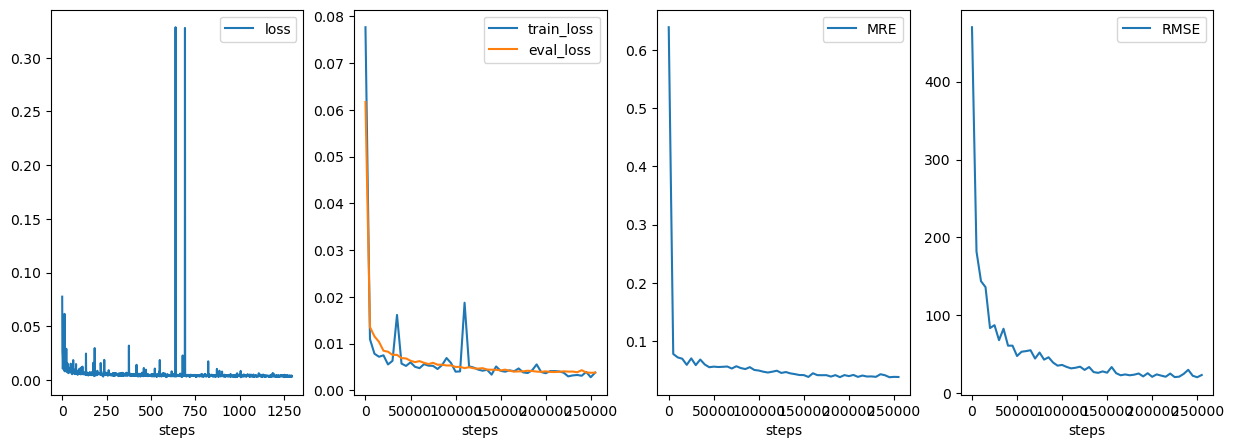

In [19]:
init_model_funcs = {
    ModelType.Transformer.name: init_Transformer_model,
    ModelType.GCNSubgraph.name: init_GCNSubgraph_model,
    ModelType.GRU.name: init_GRU_model,
    ModelType.LSTM.name: init_LSTM_model,
    ModelType.MLPTestSubgraph.name: init_MLPTestSubgraph_model,
    ModelType.RNN.name: init_RNN_model,
}

# model_type = ModelType.MLPTestSubgraph
model_type = ModelType.LSTM
# model_type = ModelType.GRU
# model_type = ModelType.Transformer
conf: Config = train_configs[model_type.name]
init_model = init_model_funcs[model_type.name]
model = init_model()
model = model.to(conf.device)
single_train_loop(model_type, conf, preprocessed_train_ds, preprocessed_eval_ds, model, compute_evaluate_metrics, to_device)



[2023-12-21 17:55:27,001] {executor.py:148} INFO - ModelType.MLPTestSubgraph start single training.
[2023-12-21 17:55:27,002] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 0


  0%|          | 0/2591 [00:00<?, ?it/s]

[2023-12-21 17:55:27,033] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 0.031173816 seconds.
[2023-12-21 17:55:27,033] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 0.
[2023-12-21 17:55:38,886] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.1446811854839325, eval metrics: {'eval_loss': 0.12764513640732839, 'MRE': 0.6941099362599862, 'MAE': 0.47300306813750903, 'RMSE': 471.6134158195526}
[2023-12-21 17:55:38,902] {executor.py:187} INFO - Saving model at step 0 with loss 0.1446811854839325,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:19<00:00, 132.11it/s]

[2023-12-21 17:55:46,617] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 1



 93%|█████████▎| 2406/2591 [00:06<00:00, 341.55it/s]

[2023-12-21 17:55:53,391] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 26.389850989 seconds.
[2023-12-21 17:55:53,392] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 5000.
[2023-12-21 17:56:03,638] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.027374770492315292, eval metrics: {'eval_loss': 0.03277700401493798, 'MRE': 0.12425681953564571, 'MAE': 0.22276265043768678, 'RMSE': 428.50458383759735}
[2023-12-21 17:56:03,647] {executor.py:187} INFO - Saving model at step 5000 with loss 0.027374770492315292,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:17<00:00, 146.43it/s]

[2023-12-21 17:56:04,314] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 2



100%|██████████| 2591/2591 [00:07<00:00, 351.78it/s]

[2023-12-21 17:56:11,683] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 3



 86%|████████▌ | 2217/2591 [00:06<00:01, 351.12it/s]

[2023-12-21 17:56:18,498] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 51.496753224 seconds.
[2023-12-21 17:56:18,499] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 10000.
[2023-12-21 17:56:29,075] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.0369090773165226, eval metrics: {'eval_loss': 0.031113031291731895, 'MRE': 0.13365646340902962, 'MAE': 0.2324775190989518, 'RMSE': 435.30031524957826}
[2023-12-21 17:56:29,093] {executor.py:187} INFO - Saving model at step 10000 with loss 0.0369090773165226,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:18<00:00, 138.20it/s]

[2023-12-21 17:56:30,434] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 4



100%|██████████| 2591/2591 [00:07<00:00, 353.96it/s]

[2023-12-21 17:56:37,757] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 5



 79%|███████▊  | 2036/2591 [00:05<00:01, 321.17it/s]

[2023-12-21 17:56:43,729] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 76.728097565 seconds.
[2023-12-21 17:56:43,730] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 15000.
[2023-12-21 17:56:54,531] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.014806650578975677, eval metrics: {'eval_loss': 0.0303983510268266, 'MRE': 0.12545664759996, 'MAE': 0.21952958518891164, 'RMSE': 425.25295306487567}
[2023-12-21 17:56:54,541] {executor.py:187} INFO - Saving model at step 15000 with loss 0.014806650578975677,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:18<00:00, 139.11it/s]

[2023-12-21 17:56:56,386] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 6



100%|██████████| 2591/2591 [00:07<00:00, 368.03it/s]

[2023-12-21 17:57:03,429] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 7



 71%|███████   | 1842/2591 [00:05<00:02, 374.04it/s]

[2023-12-21 17:57:08,578] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 101.576274471 seconds.
[2023-12-21 17:57:08,578] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 20000.
[2023-12-21 17:57:19,124] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.03830033540725708, eval metrics: {'eval_loss': 0.02990931475918891, 'MRE': 0.13769962697115823, 'MAE': 0.22844338036055237, 'RMSE': 431.15250969991956}
[2023-12-21 17:57:19,136] {executor.py:187} INFO - Saving model at step 20000 with loss 0.03830033540725708,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:18<00:00, 143.29it/s]

[2023-12-21 17:57:21,515] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 8



100%|██████████| 2591/2591 [00:07<00:00, 353.66it/s]

[2023-12-21 17:57:28,845] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 9



 64%|██████▎   | 1648/2591 [00:04<00:02, 382.14it/s]

[2023-12-21 17:57:33,312] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 126.310883725 seconds.
[2023-12-21 17:57:33,313] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 25000.
[2023-12-21 17:57:43,612] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.020409315824508667, eval metrics: {'eval_loss': 0.029517213929139804, 'MRE': 0.1296892200097176, 'MAE': 0.2234285265176694, 'RMSE': 427.1739833913749}
[2023-12-21 17:57:43,623] {executor.py:187} INFO - Saving model at step 25000 with loss 0.020409315824508667,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:17<00:00, 150.63it/s]

[2023-12-21 17:57:46,049] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 10



100%|██████████| 2591/2591 [00:06<00:00, 373.97it/s]

[2023-12-21 17:57:52,980] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 11



 58%|█████▊    | 1493/2591 [00:03<00:02, 372.22it/s]

[2023-12-21 17:57:56,986] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 149.984551142 seconds.
[2023-12-21 17:57:56,987] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 30000.
[2023-12-21 17:58:07,490] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.022329924628138542, eval metrics: {'eval_loss': 0.029202836846598357, 'MRE': 0.1298370920493302, 'MAE': 0.2183175028555358, 'RMSE': 424.73438992458705}
[2023-12-21 17:58:07,502] {executor.py:187} INFO - Saving model at step 30000 with loss 0.022329924628138542,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:17<00:00, 144.87it/s]

[2023-12-21 17:58:10,868] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 12



100%|██████████| 2591/2591 [00:07<00:00, 353.52it/s]

[2023-12-21 17:58:18,200] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 13



 51%|█████     | 1312/2591 [00:03<00:03, 372.83it/s]

[2023-12-21 17:58:21,794] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 174.792807482 seconds.
[2023-12-21 17:58:21,795] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 35000.
[2023-12-21 17:58:32,189] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.020487070083618164, eval metrics: {'eval_loss': 0.02865617022050444, 'MRE': 0.14613431974285065, 'MAE': 0.22578702537205994, 'RMSE': 413.2666638115486}
[2023-12-21 17:58:32,195] {executor.py:187} INFO - Saving model at step 35000 with loss 0.020487070083618164,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:17<00:00, 148.69it/s]

[2023-12-21 17:58:35,629] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 14



100%|██████████| 2591/2591 [00:07<00:00, 352.66it/s]

[2023-12-21 17:58:42,979] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 15



 44%|████▎     | 1133/2591 [00:03<00:05, 267.57it/s]

[2023-12-21 17:58:46,741] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 199.739131855 seconds.
[2023-12-21 17:58:46,741] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 40000.
[2023-12-21 17:58:58,589] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.01731192320585251, eval metrics: {'eval_loss': 0.02791336425263201, 'MRE': 0.11409744654789383, 'MAE': 0.19638636014167105, 'RMSE': 388.4731065572257}
[2023-12-21 17:58:58,607] {executor.py:187} INFO - Saving model at step 40000 with loss 0.01731192320585251,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:20<00:00, 124.25it/s]

[2023-12-21 17:59:03,835] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 16



100%|██████████| 2591/2591 [00:07<00:00, 326.67it/s]

[2023-12-21 17:59:11,770] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 17



 36%|███▌      | 926/2591 [00:02<00:04, 339.87it/s]

[2023-12-21 17:59:14,609] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 227.607690488 seconds.
[2023-12-21 17:59:14,610] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 45000.
[2023-12-21 17:59:25,227] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.035972584038972855, eval metrics: {'eval_loss': 0.027242366423647003, 'MRE': 0.12011395397066467, 'MAE': 0.19323833058284806, 'RMSE': 370.3806285615771}
[2023-12-21 17:59:25,236] {executor.py:187} INFO - Saving model at step 45000 with loss 0.035972584038972855,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:19<00:00, 133.22it/s]

[2023-12-21 17:59:31,222] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 18



100%|██████████| 2591/2591 [00:07<00:00, 325.90it/s]

[2023-12-21 17:59:39,176] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 19



 29%|██▉       | 760/2591 [00:02<00:05, 322.25it/s]

[2023-12-21 17:59:41,576] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 254.574522094 seconds.
[2023-12-21 17:59:41,577] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 50000.
[2023-12-21 17:59:52,223] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.01767576113343239, eval metrics: {'eval_loss': 0.026648719107119086, 'MRE': 0.13618117808998081, 'MAE': 0.1880537098299577, 'RMSE': 340.9992652699283}
[2023-12-21 17:59:52,230] {executor.py:187} INFO - Saving model at step 50000 with loss 0.01767576113343239,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:18<00:00, 139.28it/s]

[2023-12-21 17:59:57,781] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 20



100%|██████████| 2591/2591 [00:08<00:00, 305.99it/s]

[2023-12-21 18:00:06,252] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 21



 22%|██▏       | 571/2591 [00:01<00:06, 320.83it/s]

[2023-12-21 18:00:08,155] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 281.154040353 seconds.
[2023-12-21 18:00:08,156] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 55000.
[2023-12-21 18:00:20,044] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.024733513593673706, eval metrics: {'eval_loss': 0.02629715676889593, 'MRE': 0.13448817316685027, 'MAE': 0.18116469172369964, 'RMSE': 328.613056182079}
[2023-12-21 18:00:20,051] {executor.py:187} INFO - Saving model at step 55000 with loss 0.024733513593673706,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:20<00:00, 128.67it/s]

[2023-12-21 18:00:26,394] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 22



100%|██████████| 2591/2591 [00:08<00:00, 309.51it/s]

[2023-12-21 18:00:34,768] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 23



 15%|█▌        | 401/2591 [00:01<00:06, 319.09it/s]

[2023-12-21 18:00:36,112] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 309.110648887 seconds.
[2023-12-21 18:00:36,113] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 60000.
[2023-12-21 18:00:47,505] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.03462309390306473, eval metrics: {'eval_loss': 0.025548092472100898, 'MRE': 0.1296315759102399, 'MAE': 0.17267965847513356, 'RMSE': 317.1286838091267}
[2023-12-21 18:00:47,513] {executor.py:187} INFO - Saving model at step 60000 with loss 0.03462309390306473,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:19<00:00, 130.41it/s]

[2023-12-21 18:00:54,639] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 24



100%|██████████| 2591/2591 [00:08<00:00, 322.23it/s]

[2023-12-21 18:01:02,683] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 25



  8%|▊         | 202/2591 [00:00<00:06, 353.03it/s]

[2023-12-21 18:01:03,358] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 336.356333888 seconds.
[2023-12-21 18:01:03,358] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 65000.
[2023-12-21 18:01:19,549] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.04988175630569458, eval metrics: {'eval_loss': 0.025537954410650446, 'MRE': 0.1270886893307788, 'MAE': 0.17053803555551872, 'RMSE': 310.3485012902018}
[2023-12-21 18:01:19,562] {executor.py:187} INFO - Saving model at step 65000 with loss 0.04988175630569458,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:24<00:00, 107.91it/s]

[2023-12-21 18:01:26,697] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 26



100%|██████████| 2591/2591 [00:07<00:00, 352.61it/s]

[2023-12-21 18:01:34,050] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 27



  1%|          | 23/2591 [00:00<00:11, 225.92it/s]

[2023-12-21 18:01:34,227] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 367.225240589 seconds.
[2023-12-21 18:01:34,227] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 70000.
[2023-12-21 18:01:44,891] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.016805540770292282, eval metrics: {'eval_loss': 0.02481494497815255, 'MRE': 0.12595416571660098, 'MAE': 0.16464951418231785, 'RMSE': 299.3678282005666}
[2023-12-21 18:01:44,897] {executor.py:187} INFO - Saving model at step 70000 with loss 0.016805540770292282,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:18<00:00, 142.71it/s]

[2023-12-21 18:01:52,209] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 28



 94%|█████████▎| 2426/2591 [00:06<00:00, 385.85it/s]

[2023-12-21 18:01:58,902] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 391.900710067 seconds.
[2023-12-21 18:01:58,903] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 75000.
[2023-12-21 18:02:09,204] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.0160116795450449, eval metrics: {'eval_loss': 0.02468244529778271, 'MRE': 0.1290468042088291, 'MAE': 0.15135263695783244, 'RMSE': 281.6050954817409}
[2023-12-21 18:02:09,212] {executor.py:187} INFO - Saving model at step 75000 with loss 0.0160116795450449,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:17<00:00, 147.60it/s]

[2023-12-21 18:02:09,766] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 29



100%|██████████| 2591/2591 [00:06<00:00, 374.47it/s]

[2023-12-21 18:02:16,688] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 30



 87%|████████▋ | 2253/2591 [00:05<00:00, 380.98it/s]

[2023-12-21 18:02:22,652] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 415.650124477 seconds.
[2023-12-21 18:02:22,652] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 80000.


 87%|████████▋ | 2253/2591 [00:15<00:00, 380.98it/s]

[2023-12-21 18:02:33,017] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.0137557964771986, eval metrics: {'eval_loss': 0.02375915183914505, 'MRE': 0.13017034376204592, 'MAE': 0.15292889085086953, 'RMSE': 273.4627742689635}
[2023-12-21 18:02:33,023] {executor.py:187} INFO - Saving model at step 80000 with loss 0.0137557964771986,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:17<00:00, 149.14it/s]

[2023-12-21 18:02:34,065] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 31



100%|██████████| 2591/2591 [00:07<00:00, 358.67it/s]

[2023-12-21 18:02:41,293] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 32



 80%|████████  | 2085/2591 [00:05<00:01, 378.45it/s]

[2023-12-21 18:02:46,991] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 439.98987709 seconds.
[2023-12-21 18:02:46,992] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 85000.
[2023-12-21 18:02:57,296] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.019005466252565384, eval metrics: {'eval_loss': 0.02305828404395291, 'MRE': 0.13180162589316452, 'MAE': 0.14505904261478778, 'RMSE': 247.39361766597997}
[2023-12-21 18:02:57,306] {executor.py:187} INFO - Saving model at step 85000 with loss 0.019005466252565384,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:17<00:00, 147.14it/s]

[2023-12-21 18:02:58,905] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 33



100%|██████████| 2591/2591 [00:08<00:00, 319.73it/s]

[2023-12-21 18:03:07,012] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 34



 73%|███████▎  | 1890/2591 [00:05<00:01, 378.83it/s]

[2023-12-21 18:03:12,236] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 465.234632225 seconds.
[2023-12-21 18:03:12,237] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 90000.


 73%|███████▎  | 1890/2591 [00:15<00:01, 378.83it/s]

[2023-12-21 18:03:22,655] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.07347916811704636, eval metrics: {'eval_loss': 0.022804632706861606, 'MRE': 0.10679713010941733, 'MAE': 0.11789943797832861, 'RMSE': 233.57107847866425}
[2023-12-21 18:03:22,662] {executor.py:187} INFO - Saving model at step 90000 with loss 0.07347916811704636,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:17<00:00, 147.04it/s]

[2023-12-21 18:03:24,635] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 35



100%|██████████| 2591/2591 [00:08<00:00, 320.24it/s]

[2023-12-21 18:03:32,729] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 36



 66%|██████▌   | 1698/2591 [00:05<00:02, 316.65it/s]

[2023-12-21 18:03:38,218] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 491.216237175 seconds.
[2023-12-21 18:03:38,218] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 95000.
[2023-12-21 18:03:49,907] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.022673025727272034, eval metrics: {'eval_loss': 0.022498637620196948, 'MRE': 0.12577411316333512, 'MAE': 0.12737650999055086, 'RMSE': 223.47621018709722}
[2023-12-21 18:03:49,919] {executor.py:187} INFO - Saving model at step 95000 with loss 0.022673025727272034,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:19<00:00, 129.98it/s]

[2023-12-21 18:03:52,666] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 37



100%|██████████| 2591/2591 [00:07<00:00, 353.45it/s]

[2023-12-21 18:04:00,000] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 38



 58%|█████▊    | 1514/2591 [00:04<00:02, 378.13it/s]

[2023-12-21 18:04:04,446] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 517.444195981 seconds.
[2023-12-21 18:04:04,446] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 100000.
[2023-12-21 18:04:14,682] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.02246806025505066, eval metrics: {'eval_loss': 0.02256150696040976, 'MRE': 0.1103495318924208, 'MAE': 0.12436134349519022, 'RMSE': 229.2466996470238}
[2023-12-21 18:04:14,689] {executor.py:187} INFO - Saving model at step 100000 with loss 0.02246806025505066,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:17<00:00, 146.69it/s]

[2023-12-21 18:04:17,666] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 39



100%|██████████| 2591/2591 [00:06<00:00, 371.09it/s]

[2023-12-21 18:04:24,651] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 40



 52%|█████▏    | 1345/2591 [00:03<00:03, 362.59it/s]

[2023-12-21 18:04:28,462] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 541.460564644 seconds.
[2023-12-21 18:04:28,462] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 105000.
[2023-12-21 18:04:38,782] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.025332575663924217, eval metrics: {'eval_loss': 0.022079410645427563, 'MRE': 0.09244894211992646, 'MAE': 0.10376178543177354, 'RMSE': 211.8915588877414}
[2023-12-21 18:04:38,791] {executor.py:187} INFO - Saving model at step 105000 with loss 0.025332575663924217,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:17<00:00, 144.51it/s]


[2023-12-21 18:04:42,583] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 41


100%|██████████| 2591/2591 [00:08<00:00, 317.59it/s]

[2023-12-21 18:04:50,744] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 42



 45%|████▌     | 1169/2591 [00:03<00:04, 293.65it/s]

[2023-12-21 18:04:54,696] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 567.694767973 seconds.
[2023-12-21 18:04:54,697] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 110000.
[2023-12-21 18:05:06,248] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.018540680408477783, eval metrics: {'eval_loss': 0.021317304952769508, 'MRE': 0.10548897874281724, 'MAE': 0.10733932968689924, 'RMSE': 201.99635822738955}
[2023-12-21 18:05:06,255] {executor.py:187} INFO - Saving model at step 110000 with loss 0.018540680408477783,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:20<00:00, 126.91it/s]

[2023-12-21 18:05:11,164] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 43



100%|██████████| 2591/2591 [00:08<00:00, 307.64it/s]

[2023-12-21 18:05:19,589] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 44



 38%|███▊      | 994/2591 [00:03<00:05, 303.68it/s]

[2023-12-21 18:05:22,786] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 595.784358033 seconds.
[2023-12-21 18:05:22,786] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 115000.
[2023-12-21 18:05:34,738] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.029483776539564133, eval metrics: {'eval_loss': 0.02177843682246119, 'MRE': 0.1164256927978165, 'MAE': 0.10895408172461166, 'RMSE': 202.28508627054669}
[2023-12-21 18:05:34,749] {executor.py:187} INFO - Saving model at step 115000 with loss 0.029483776539564133,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:20<00:00, 124.01it/s]

[2023-12-21 18:05:40,486] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 45



100%|██████████| 2591/2591 [00:08<00:00, 304.77it/s]

[2023-12-21 18:05:48,991] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 46



 31%|███▏      | 813/2591 [00:02<00:05, 317.65it/s]

[2023-12-21 18:05:51,549] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 624.547800815 seconds.
[2023-12-21 18:05:51,550] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 120000.


 31%|███▏      | 813/2591 [00:13<00:05, 317.65it/s]

[2023-12-21 18:06:03,405] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.026318058371543884, eval metrics: {'eval_loss': 0.021324085984913935, 'MRE': 0.12335767738203667, 'MAE': 0.11170028976429489, 'RMSE': 196.39853183997036}
[2023-12-21 18:06:03,411] {executor.py:187} INFO - Saving model at step 120000 with loss 0.026318058371543884,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:20<00:00, 129.18it/s]

[2023-12-21 18:06:09,051] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 47



100%|██████████| 2591/2591 [00:07<00:00, 353.52it/s]

[2023-12-21 18:06:16,383] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 48



 24%|██▎       | 612/2591 [00:02<00:06, 307.33it/s]

[2023-12-21 18:06:18,484] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 651.482757977 seconds.
[2023-12-21 18:06:18,485] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 125000.
[2023-12-21 18:06:30,227] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.015111005865037441, eval metrics: {'eval_loss': 0.021319196538419398, 'MRE': 0.1392825742483657, 'MAE': 0.12659066773233402, 'RMSE': 190.15465543795554}
[2023-12-21 18:06:30,237] {executor.py:187} INFO - Saving model at step 125000 with loss 0.015111005865037441,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:20<00:00, 126.94it/s]

[2023-12-21 18:06:36,797] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 49



100%|██████████| 2591/2591 [00:07<00:00, 350.45it/s]

[2023-12-21 18:06:44,194] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 50



 17%|█▋        | 443/2591 [00:01<00:05, 375.64it/s]

[2023-12-21 18:06:45,436] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 678.434644815 seconds.
[2023-12-21 18:06:45,437] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 130000.
[2023-12-21 18:06:56,061] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.014573728665709496, eval metrics: {'eval_loss': 0.02105244108036153, 'MRE': 0.11568037825708612, 'MAE': 0.10582117028684403, 'RMSE': 174.9957057447075}
[2023-12-21 18:06:56,068] {executor.py:187} INFO - Saving model at step 130000 with loss 0.014573728665709496,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:18<00:00, 142.38it/s]

[2023-12-21 18:07:02,395] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 51



100%|██████████| 2591/2591 [00:07<00:00, 332.82it/s]

[2023-12-21 18:07:10,183] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 52



  9%|▉         | 244/2591 [00:00<00:06, 361.34it/s]

[2023-12-21 18:07:10,962] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 703.960914241 seconds.
[2023-12-21 18:07:10,963] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 135000.


  9%|▉         | 244/2591 [00:12<00:06, 361.34it/s]

[2023-12-21 18:07:28,390] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.018818728625774384, eval metrics: {'eval_loss': 0.020932827397918467, 'MRE': 0.12214437496605118, 'MAE': 0.11052025404959612, 'RMSE': 188.02739503722268}
[2023-12-21 18:07:28,398] {executor.py:187} INFO - Saving model at step 135000 with loss 0.018818728625774384,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:25<00:00, 101.31it/s]

[2023-12-21 18:07:35,762] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 53



100%|██████████| 2591/2591 [00:07<00:00, 359.74it/s]

[2023-12-21 18:07:42,967] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 54



  3%|▎         | 82/2591 [00:00<00:08, 279.54it/s]

[2023-12-21 18:07:43,292] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 736.290217244 seconds.
[2023-12-21 18:07:43,292] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 140000.
[2023-12-21 18:07:55,302] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.017776459455490112, eval metrics: {'eval_loss': 0.020677145428031424, 'MRE': 0.12388611598354425, 'MAE': 0.1068939925126882, 'RMSE': 174.7754559902249}
[2023-12-21 18:07:55,318] {executor.py:187} INFO - Saving model at step 140000 with loss 0.017776459455490112,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:21<00:00, 121.45it/s]

[2023-12-21 18:08:04,304] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 55



 96%|█████████▌| 2490/2591 [00:08<00:00, 318.27it/s]

[2023-12-21 18:08:12,406] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 765.404942669 seconds.
[2023-12-21 18:08:12,407] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 145000.


 96%|█████████▌| 2490/2591 [00:18<00:00, 318.27it/s]

[2023-12-21 18:08:24,167] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.042141757905483246, eval metrics: {'eval_loss': 0.020678971800818305, 'MRE': 0.11892390942955375, 'MAE': 0.10716222700890159, 'RMSE': 176.23757349241728}
[2023-12-21 18:08:24,174] {executor.py:187} INFO - Saving model at step 145000 with loss 0.042141757905483246,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:20<00:00, 127.04it/s]

[2023-12-21 18:08:24,702] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 56



100%|██████████| 2591/2591 [00:08<00:00, 319.88it/s]

[2023-12-21 18:08:32,805] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 57



 89%|████████▉ | 2313/2591 [00:06<00:00, 347.73it/s]

[2023-12-21 18:08:39,349] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 792.347589283 seconds.
[2023-12-21 18:08:39,350] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 150000.
[2023-12-21 18:08:49,956] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.014834756031632423, eval metrics: {'eval_loss': 0.02083291412595458, 'MRE': 0.12223417034080913, 'MAE': 0.11251679913493838, 'RMSE': 177.81326469716393}
[2023-12-21 18:08:49,968] {executor.py:187} INFO - Saving model at step 150000 with loss 0.014834756031632423,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:18<00:00, 141.43it/s]

[2023-12-21 18:08:51,128] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 58



100%|██████████| 2591/2591 [00:07<00:00, 362.60it/s]

[2023-12-21 18:08:58,276] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 59



 81%|████████▏ | 2109/2591 [00:05<00:01, 366.36it/s]

[2023-12-21 18:09:04,245] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 817.243751855 seconds.
[2023-12-21 18:09:04,246] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 155000.
[2023-12-21 18:09:14,446] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.028432313352823257, eval metrics: {'eval_loss': 0.020885190044780996, 'MRE': 0.12646676789773856, 'MAE': 0.11233732975654226, 'RMSE': 175.36029788859645}
[2023-12-21 18:09:14,452] {executor.py:187} INFO - Saving model at step 155000 with loss 0.028432313352823257,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:17<00:00, 146.79it/s]

[2023-12-21 18:09:15,929] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 60



100%|██████████| 2591/2591 [00:06<00:00, 371.68it/s]

[2023-12-21 18:09:22,903] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 61



 75%|███████▌  | 1948/2591 [00:05<00:01, 366.78it/s]

[2023-12-21 18:09:28,313] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 841.311620347 seconds.
[2023-12-21 18:09:28,314] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 160000.
[2023-12-21 18:09:38,426] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.014199541881680489, eval metrics: {'eval_loss': 0.020541204222856435, 'MRE': 0.10800040592449885, 'MAE': 0.09801555282930531, 'RMSE': 173.23473030015242}
[2023-12-21 18:09:38,436] {executor.py:187} INFO - Saving model at step 160000 with loss 0.014199541881680489,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:17<00:00, 146.37it/s]

[2023-12-21 18:09:40,609] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 62



100%|██████████| 2591/2591 [00:06<00:00, 373.06it/s]

[2023-12-21 18:09:47,557] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 63



 68%|██████▊   | 1763/2591 [00:04<00:02, 381.65it/s]

[2023-12-21 18:09:52,258] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 865.256796312 seconds.
[2023-12-21 18:09:52,259] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 165000.
[2023-12-21 18:10:02,362] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.026651084423065186, eval metrics: {'eval_loss': 0.02052305595786131, 'MRE': 0.10827873246826145, 'MAE': 0.09614606017149666, 'RMSE': 167.6132751300129}
[2023-12-21 18:10:02,369] {executor.py:187} INFO - Saving model at step 165000 with loss 0.026651084423065186,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:17<00:00, 150.23it/s]

[2023-12-21 18:10:04,806] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 64



100%|██████████| 2591/2591 [00:07<00:00, 356.79it/s]

[2023-12-21 18:10:12,071] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 65



 60%|██████    | 1561/2591 [00:04<00:02, 367.22it/s]

[2023-12-21 18:10:16,425] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 889.424002847 seconds.
[2023-12-21 18:10:16,426] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 170000.
[2023-12-21 18:10:26,596] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.014737427234649658, eval metrics: {'eval_loss': 0.020745960715585064, 'MRE': 0.1101535463133959, 'MAE': 0.09518612604984886, 'RMSE': 155.65298976775577}
[2023-12-21 18:10:26,608] {executor.py:187} INFO - Saving model at step 170000 with loss 0.014737427234649658,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:17<00:00, 143.95it/s]

[2023-12-21 18:10:30,074] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 66



100%|██████████| 2591/2591 [00:08<00:00, 316.70it/s]

[2023-12-21 18:10:38,258] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 67



 53%|█████▎    | 1385/2591 [00:03<00:03, 376.69it/s]

[2023-12-21 18:10:42,178] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 915.176802789 seconds.
[2023-12-21 18:10:42,179] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 175000.
[2023-12-21 18:10:52,766] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.016203386709094048, eval metrics: {'eval_loss': 0.019992216719219167, 'MRE': 0.11640965379104236, 'MAE': 0.10595944593604129, 'RMSE': 167.6752864910773}
[2023-12-21 18:10:52,772] {executor.py:187} INFO - Saving model at step 175000 with loss 0.016203386709094048,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:17<00:00, 144.71it/s]

[2023-12-21 18:10:56,166] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 68



100%|██████████| 2591/2591 [00:06<00:00, 371.72it/s]

[2023-12-21 18:11:03,140] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 69



 47%|████▋     | 1215/2591 [00:03<00:03, 380.29it/s]

[2023-12-21 18:11:06,419] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 939.417459809 seconds.
[2023-12-21 18:11:06,419] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 180000.
[2023-12-21 18:11:17,017] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.0158243328332901, eval metrics: {'eval_loss': 0.02038122831644224, 'MRE': 0.11999143321136492, 'MAE': 0.10480873289610713, 'RMSE': 159.26557541005687}
[2023-12-21 18:11:17,025] {executor.py:187} INFO - Saving model at step 180000 with loss 0.0158243328332901,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:18<00:00, 143.46it/s]

[2023-12-21 18:11:21,204] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 70



100%|██████████| 2591/2591 [00:08<00:00, 314.25it/s]

[2023-12-21 18:11:29,453] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 71



 40%|███▉      | 1031/2591 [00:02<00:04, 375.31it/s]

[2023-12-21 18:11:32,236] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 965.235100799 seconds.
[2023-12-21 18:11:32,237] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 185000.
[2023-12-21 18:11:42,532] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.015383138321340084, eval metrics: {'eval_loss': 0.020107749906922764, 'MRE': 0.11220579718612779, 'MAE': 0.10483592851323972, 'RMSE': 170.75824385092338}
[2023-12-21 18:11:42,545] {executor.py:187} INFO - Saving model at step 185000 with loss 0.015383138321340084,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:18<00:00, 143.87it/s]

[2023-12-21 18:11:47,465] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 72



100%|██████████| 2591/2591 [00:07<00:00, 338.06it/s]

[2023-12-21 18:11:55,132] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 73



 32%|███▏      | 837/2591 [00:02<00:05, 297.63it/s]

[2023-12-21 18:11:57,904] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 990.902719569 seconds.
[2023-12-21 18:11:57,905] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 190000.
[2023-12-21 18:12:09,447] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.012385080568492413, eval metrics: {'eval_loss': 0.02009186533982704, 'MRE': 0.11238790098581856, 'MAE': 0.09408322980548128, 'RMSE': 155.23586431534864}
[2023-12-21 18:12:09,454] {executor.py:187} INFO - Saving model at step 190000 with loss 0.012385080568492413,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:19<00:00, 129.93it/s]

[2023-12-21 18:12:15,077] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 74



100%|██████████| 2591/2591 [00:08<00:00, 320.51it/s]

[2023-12-21 18:12:23,164] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 75



 26%|██▌       | 673/2591 [00:02<00:05, 345.16it/s]

[2023-12-21 18:12:25,205] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 1018.204102631 seconds.
[2023-12-21 18:12:25,206] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 195000.
[2023-12-21 18:12:35,546] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.01851760968565941, eval metrics: {'eval_loss': 0.020340996386499492, 'MRE': 0.1031102543089723, 'MAE': 0.0997884463384815, 'RMSE': 167.77469600333325}
[2023-12-21 18:12:35,560] {executor.py:187} INFO - Saving model at step 195000 with loss 0.01851760968565941,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:18<00:00, 142.64it/s]

[2023-12-21 18:12:41,331] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 76



100%|██████████| 2591/2591 [00:06<00:00, 379.82it/s]

[2023-12-21 18:12:48,156] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 77



 18%|█▊        | 468/2591 [00:01<00:06, 331.19it/s]

[2023-12-21 18:12:49,602] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 1042.60053053 seconds.
[2023-12-21 18:12:49,603] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 200000.
[2023-12-21 18:13:01,478] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.01842629536986351, eval metrics: {'eval_loss': 0.020271522068269335, 'MRE': 0.10986953384845638, 'MAE': 0.09417216629225446, 'RMSE': 151.30341314930394}
[2023-12-21 18:13:01,496] {executor.py:187} INFO - Saving model at step 200000 with loss 0.01842629536986351,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:20<00:00, 124.83it/s]

[2023-12-21 18:13:08,915] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 78



100%|██████████| 2591/2591 [00:08<00:00, 322.27it/s]

[2023-12-21 18:13:16,958] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 79



 12%|█▏        | 310/2591 [00:00<00:06, 360.48it/s]

[2023-12-21 18:13:17,881] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 1070.88001432 seconds.
[2023-12-21 18:13:17,882] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 205000.


 12%|█▏        | 310/2591 [00:11<00:06, 360.48it/s]

[2023-12-21 18:13:34,509] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.021704483777284622, eval metrics: {'eval_loss': 0.02062677768954439, 'MRE': 0.10351527998746521, 'MAE': 0.09360768493270097, 'RMSE': 159.5946102662945}
[2023-12-21 18:13:34,516] {executor.py:187} INFO - Saving model at step 205000 with loss 0.021704483777284622,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:23<00:00, 107.98it/s]

[2023-12-21 18:13:40,957] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 80



100%|██████████| 2591/2591 [00:07<00:00, 351.20it/s]

[2023-12-21 18:13:48,338] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 81



  4%|▎         | 96/2591 [00:00<00:07, 331.02it/s]

[2023-12-21 18:13:48,738] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 1101.736989391 seconds.
[2023-12-21 18:13:48,739] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 210000.


  4%|▎         | 96/2591 [00:10<00:07, 331.02it/s]

[2023-12-21 18:13:59,070] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.021340027451515198, eval metrics: {'eval_loss': 0.02009918985712615, 'MRE': 0.10767374303725134, 'MAE': 0.0933152362840903, 'RMSE': 155.6814648308895}
[2023-12-21 18:13:59,082] {executor.py:187} INFO - Saving model at step 210000 with loss 0.021340027451515198,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:18<00:00, 141.30it/s]

[2023-12-21 18:14:06,678] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 82



 97%|█████████▋| 2518/2591 [00:06<00:00, 372.43it/s]

[2023-12-21 18:14:13,533] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 1126.532038034 seconds.
[2023-12-21 18:14:13,534] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 215000.
[2023-12-21 18:14:23,714] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.015708915889263153, eval metrics: {'eval_loss': 0.019927682944876412, 'MRE': 0.10107972047557445, 'MAE': 0.0928825739554803, 'RMSE': 160.72484292906012}
[2023-12-21 18:14:23,721] {executor.py:187} INFO - Saving model at step 215000 with loss 0.015708915889263153,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:17<00:00, 148.15it/s]

[2023-12-21 18:14:24,170] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 83



100%|██████████| 2591/2591 [00:06<00:00, 373.20it/s]

[2023-12-21 18:14:31,116] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 84



 91%|█████████ | 2347/2591 [00:06<00:00, 370.31it/s]

[2023-12-21 18:14:37,458] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 1150.456748007 seconds.
[2023-12-21 18:14:37,459] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 220000.
[2023-12-21 18:14:48,012] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.016027553007006645, eval metrics: {'eval_loss': 0.020151281977902998, 'MRE': 0.11545071771739539, 'MAE': 0.09905139985052004, 'RMSE': 156.68873981450426}
[2023-12-21 18:14:48,023] {executor.py:187} INFO - Saving model at step 220000 with loss 0.016027553007006645,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:17<00:00, 143.97it/s]

[2023-12-21 18:14:49,116] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 85



100%|██████████| 2591/2591 [00:07<00:00, 336.94it/s]

[2023-12-21 18:14:56,809] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 86



 83%|████████▎ | 2146/2591 [00:05<00:01, 366.43it/s]

[2023-12-21 18:15:02,734] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 1175.732879553 seconds.
[2023-12-21 18:15:02,735] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 225000.
[2023-12-21 18:15:13,046] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.01632974110543728, eval metrics: {'eval_loss': 0.019924584414219324, 'MRE': 0.11350363407111609, 'MAE': 0.09425342846533477, 'RMSE': 156.77210421099224}
[2023-12-21 18:15:13,053] {executor.py:187} INFO - Saving model at step 225000 with loss 0.01632974110543728,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:17<00:00, 146.65it/s]

[2023-12-21 18:15:14,480] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 87



100%|██████████| 2591/2591 [00:07<00:00, 367.28it/s]

[2023-12-21 18:15:21,537] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 88



 76%|███████▋  | 1980/2591 [00:05<00:01, 379.50it/s]

[2023-12-21 18:15:26,870] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 1199.868724589 seconds.
[2023-12-21 18:15:26,871] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 230000.
[2023-12-21 18:15:37,401] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.023698683828115463, eval metrics: {'eval_loss': 0.020018567937596172, 'MRE': 0.1056338724913815, 'MAE': 0.09351344536801272, 'RMSE': 160.73301240248622}
[2023-12-21 18:15:37,408] {executor.py:187} INFO - Saving model at step 230000 with loss 0.023698683828115463,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:17<00:00, 144.18it/s]

[2023-12-21 18:15:39,511] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 89



100%|██████████| 2591/2591 [00:07<00:00, 342.79it/s]

[2023-12-21 18:15:47,072] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 90



 69%|██████▉   | 1798/2591 [00:05<00:02, 364.44it/s]

[2023-12-21 18:15:52,433] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 1225.431566843 seconds.
[2023-12-21 18:15:52,434] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 235000.
[2023-12-21 18:16:02,767] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.01571798510849476, eval metrics: {'eval_loss': 0.019752132764664157, 'MRE': 0.10948662644778044, 'MAE': 0.09010712436438759, 'RMSE': 147.86063354512098}
[2023-12-21 18:16:02,783] {executor.py:187} INFO - Saving model at step 235000 with loss 0.01571798510849476,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:18<00:00, 139.54it/s]

[2023-12-21 18:16:05,644] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 91



100%|██████████| 2591/2591 [00:07<00:00, 343.84it/s]

[2023-12-21 18:16:13,182] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 92



 62%|██████▏   | 1599/2591 [00:04<00:02, 359.40it/s]

[2023-12-21 18:16:17,843] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 1250.84208845 seconds.
[2023-12-21 18:16:17,844] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 240000.
[2023-12-21 18:16:27,967] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.019507575780153275, eval metrics: {'eval_loss': 0.019588582624472734, 'MRE': 0.11172546485702804, 'MAE': 0.09801938553788044, 'RMSE': 153.31439180088256}
[2023-12-21 18:16:27,975] {executor.py:187} INFO - Saving model at step 240000 with loss 0.019507575780153275,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:17<00:00, 144.67it/s]

[2023-12-21 18:16:31,095] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 93



100%|██████████| 2591/2591 [00:07<00:00, 339.87it/s]

[2023-12-21 18:16:38,721] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 94



 55%|█████▍    | 1420/2591 [00:04<00:03, 302.42it/s]

[2023-12-21 18:16:42,958] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 1275.956332253 seconds.
[2023-12-21 18:16:42,958] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 245000.
[2023-12-21 18:16:53,726] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.023533489555120468, eval metrics: {'eval_loss': 0.019769348782167184, 'MRE': 0.1058985599294906, 'MAE': 0.09698512137045659, 'RMSE': 164.04174376604894}
[2023-12-21 18:16:53,742] {executor.py:187} INFO - Saving model at step 245000 with loss 0.023533489555120468,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:19<00:00, 136.15it/s]

[2023-12-21 18:16:57,755] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 95



100%|██████████| 2591/2591 [00:07<00:00, 357.08it/s]

[2023-12-21 18:17:05,015] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 96



 48%|████▊     | 1245/2591 [00:03<00:04, 276.83it/s]

[2023-12-21 18:17:09,043] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 1302.041608013 seconds.
[2023-12-21 18:17:09,044] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 250000.
[2023-12-21 18:17:19,909] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.012755866162478924, eval metrics: {'eval_loss': 0.019713894320691445, 'MRE': 0.12196834199099456, 'MAE': 0.09912052129866337, 'RMSE': 153.96262237552435}
[2023-12-21 18:17:19,927] {executor.py:187} INFO - Saving model at step 250000 with loss 0.012755866162478924,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:19<00:00, 131.82it/s]

[2023-12-21 18:17:24,674] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 97



100%|██████████| 2591/2591 [00:07<00:00, 357.54it/s]


[2023-12-21 18:17:31,924] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 98


 40%|████      | 1049/2591 [00:02<00:04, 353.84it/s]

[2023-12-21 18:17:34,982] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 1327.980323689 seconds.
[2023-12-21 18:17:34,982] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 255000.
[2023-12-21 18:17:45,302] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.02530781924724579, eval metrics: {'eval_loss': 0.019830278752229633, 'MRE': 0.10861153976296964, 'MAE': 0.10230288309738912, 'RMSE': 154.84620145030308}
[2023-12-21 18:17:45,312] {executor.py:187} INFO - Saving model at step 255000 with loss 0.02530781924724579,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/MLPTestSubgraph/single_train2023-12-21_17-55-26


100%|██████████| 2591/2591 [00:18<00:00, 139.01it/s]

[2023-12-21 18:17:50,567] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 99



100%|██████████| 2591/2591 [00:09<00:00, 283.57it/s]


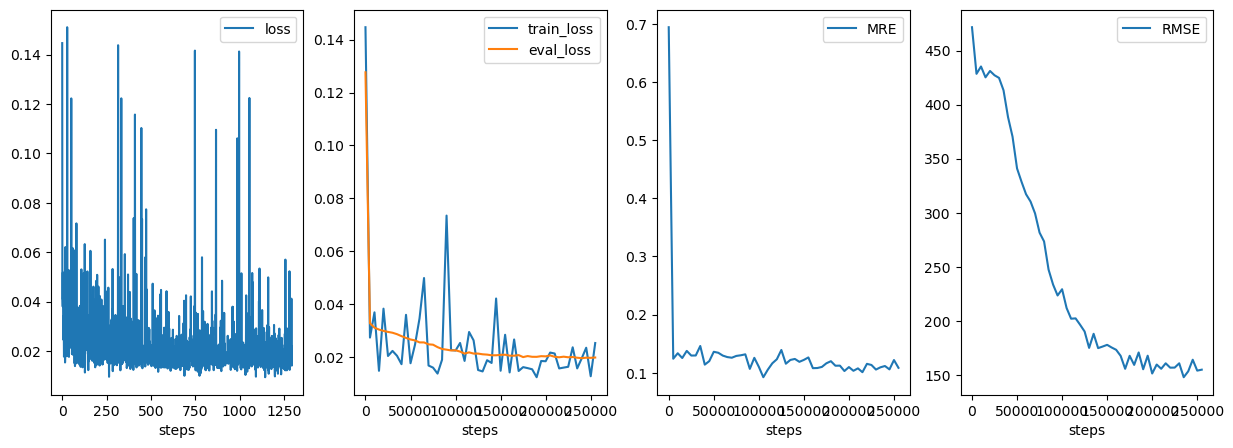

In [20]:
model_type = ModelType.MLPTestSubgraph
# model_type = ModelType.LSTM
# model_type = ModelType.GRU
# model_type = ModelType.Transformer
conf: Config = train_configs[model_type.name]
init_model = init_model_funcs[model_type.name]
model = init_model()
model = model.to(conf.device)
single_train_loop(model_type, conf, preprocessed_train_ds, preprocessed_eval_ds, model, compute_evaluate_metrics, to_device)

[2023-12-21 18:18:00,471] {executor.py:148} INFO - ModelType.GRU start single training.
[2023-12-21 18:18:00,471] {executor.py:150} INFO - ModelType.GRU training epoch 0


  0%|          | 0/2591 [00:00<?, ?it/s]

[2023-12-21 18:18:00,523] {executor.py:111} INFO - ModelType.GRU trained for 0.05259943 seconds.
[2023-12-21 18:18:00,524] {executor.py:112} INFO - ModelType.GRU eval at step 0.
[2023-12-21 18:18:13,345] {executor.py:116} INFO - ModelType.GRU train loss: 0.09960424900054932, eval metrics: {'eval_loss': 0.10375431093700144, 'MRE': 0.945889714982277, 'MAE': 0.9180313357930173, 'RMSE': 668.5768177553571}
[2023-12-21 18:18:13,362] {executor.py:187} INFO - Saving model at step 0 with loss 0.09960424900054932,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:38<00:00, 67.41it/s] 

[2023-12-21 18:18:38,911] {executor.py:150} INFO - ModelType.GRU training epoch 1



 93%|█████████▎| 2400/2591 [00:24<00:01, 99.08it/s] 

[2023-12-21 18:19:03,563] {executor.py:111} INFO - ModelType.GRU trained for 63.092034186 seconds.
[2023-12-21 18:19:03,564] {executor.py:112} INFO - ModelType.GRU eval at step 5000.
[2023-12-21 18:19:15,656] {executor.py:116} INFO - ModelType.GRU train loss: 0.010931788012385368, eval metrics: {'eval_loss': 0.015674334975241767, 'MRE': 0.07418231101246743, 'MAE': 0.10167715106266373, 'RMSE': 226.23056347085014}
[2023-12-21 18:19:15,669] {executor.py:187} INFO - Saving model at step 5000 with loss 0.010931788012385368,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:38<00:00, 67.12it/s] 

[2023-12-21 18:19:17,521] {executor.py:150} INFO - ModelType.GRU training epoch 2



100%|██████████| 2591/2591 [00:20<00:00, 123.56it/s]

[2023-12-21 18:19:38,493] {executor.py:150} INFO - ModelType.GRU training epoch 3



 85%|████████▌ | 2215/2591 [00:18<00:02, 126.62it/s]

[2023-12-21 18:19:56,635] {executor.py:111} INFO - ModelType.GRU trained for 116.164088143 seconds.
[2023-12-21 18:19:56,636] {executor.py:112} INFO - ModelType.GRU eval at step 10000.
[2023-12-21 18:20:07,548] {executor.py:116} INFO - ModelType.GRU train loss: 0.008173703216016293, eval metrics: {'eval_loss': 0.01318054279725114, 'MRE': 0.06746173165141812, 'MAE': 0.08662095163287405, 'RMSE': 188.71138493659097}
[2023-12-21 18:20:07,554] {executor.py:187} INFO - Saving model at step 10000 with loss 0.008173703216016293,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:32<00:00, 80.82it/s] 

[2023-12-21 18:20:10,555] {executor.py:150} INFO - ModelType.GRU training epoch 4



100%|██████████| 2591/2591 [00:20<00:00, 125.71it/s]

[2023-12-21 18:20:31,169] {executor.py:150} INFO - ModelType.GRU training epoch 5



 78%|███████▊  | 2033/2591 [00:16<00:04, 122.22it/s]

[2023-12-21 18:20:47,781] {executor.py:111} INFO - ModelType.GRU trained for 167.310262364 seconds.
[2023-12-21 18:20:47,782] {executor.py:112} INFO - ModelType.GRU eval at step 15000.


 78%|███████▊  | 2033/2591 [00:28<00:04, 122.22it/s]

[2023-12-21 18:21:04,808] {executor.py:116} INFO - ModelType.GRU train loss: 0.00672051589936018, eval metrics: {'eval_loss': 0.01212303904229038, 'MRE': 0.07303987326243767, 'MAE': 0.07626773539600835, 'RMSE': 155.2191220077901}
[2023-12-21 18:21:04,814] {executor.py:187} INFO - Saving model at step 15000 with loss 0.00672051589936018,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:38<00:00, 68.07it/s] 

[2023-12-21 18:21:09,234] {executor.py:150} INFO - ModelType.GRU training epoch 6



100%|██████████| 2591/2591 [00:21<00:00, 119.09it/s]

[2023-12-21 18:21:30,994] {executor.py:150} INFO - ModelType.GRU training epoch 7



 72%|███████▏  | 1858/2591 [00:15<00:06, 117.22it/s]

[2023-12-21 18:21:46,898] {executor.py:111} INFO - ModelType.GRU trained for 226.427186743 seconds.
[2023-12-21 18:21:46,899] {executor.py:112} INFO - ModelType.GRU eval at step 20000.
[2023-12-21 18:21:57,750] {executor.py:116} INFO - ModelType.GRU train loss: 0.0077461241744458675, eval metrics: {'eval_loss': 0.010603582902953504, 'MRE': 0.0753633142165307, 'MAE': 0.08061343306669291, 'RMSE': 140.76863416332057}
[2023-12-21 18:21:57,761] {executor.py:187} INFO - Saving model at step 20000 with loss 0.0077461241744458675,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:33<00:00, 78.15it/s] 

[2023-12-21 18:22:04,152] {executor.py:150} INFO - ModelType.GRU training epoch 8



100%|██████████| 2591/2591 [00:20<00:00, 125.13it/s]

[2023-12-21 18:22:24,861] {executor.py:150} INFO - ModelType.GRU training epoch 9



 64%|██████▍   | 1669/2591 [00:12<00:07, 128.00it/s]

[2023-12-21 18:22:37,809] {executor.py:111} INFO - ModelType.GRU trained for 277.337714701 seconds.
[2023-12-21 18:22:37,809] {executor.py:112} INFO - ModelType.GRU eval at step 25000.
[2023-12-21 18:22:48,841] {executor.py:116} INFO - ModelType.GRU train loss: 0.005565997213125229, eval metrics: {'eval_loss': 0.009633018371649536, 'MRE': 0.05712565833793201, 'MAE': 0.05758595680372739, 'RMSE': 114.60543988102106}
[2023-12-21 18:22:48,852] {executor.py:187} INFO - Saving model at step 25000 with loss 0.005565997213125229,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:31<00:00, 81.82it/s] 

[2023-12-21 18:22:56,532] {executor.py:150} INFO - ModelType.GRU training epoch 10



100%|██████████| 2591/2591 [00:27<00:00, 95.95it/s] 

[2023-12-21 18:23:23,539] {executor.py:150} INFO - ModelType.GRU training epoch 11



 58%|█████▊    | 1492/2591 [00:12<00:08, 123.34it/s]

[2023-12-21 18:23:35,957] {executor.py:111} INFO - ModelType.GRU trained for 335.486381006 seconds.
[2023-12-21 18:23:35,958] {executor.py:112} INFO - ModelType.GRU eval at step 30000.
[2023-12-21 18:23:47,066] {executor.py:116} INFO - ModelType.GRU train loss: 0.0062352134846150875, eval metrics: {'eval_loss': 0.008708026327784299, 'MRE': 0.055249826910648316, 'MAE': 0.055972253200239054, 'RMSE': 113.44511095379457}
[2023-12-21 18:23:47,072] {executor.py:187} INFO - Saving model at step 30000 with loss 0.0062352134846150875,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:32<00:00, 80.45it/s] 

[2023-12-21 18:23:55,751] {executor.py:150} INFO - ModelType.GRU training epoch 12



100%|██████████| 2591/2591 [00:21<00:00, 120.84it/s]

[2023-12-21 18:24:17,196] {executor.py:150} INFO - ModelType.GRU training epoch 13



 51%|█████     | 1310/2591 [00:10<00:10, 122.96it/s]

[2023-12-21 18:24:27,779] {executor.py:111} INFO - ModelType.GRU trained for 387.307974516 seconds.
[2023-12-21 18:24:27,779] {executor.py:112} INFO - ModelType.GRU eval at step 35000.
[2023-12-21 18:24:38,824] {executor.py:116} INFO - ModelType.GRU train loss: 0.012361012399196625, eval metrics: {'eval_loss': 0.008270185180979288, 'MRE': 0.05851183419051944, 'MAE': 0.05853498057453251, 'RMSE': 100.34728328089194}
[2023-12-21 18:24:38,830] {executor.py:187} INFO - Saving model at step 35000 with loss 0.012361012399196625,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:31<00:00, 81.65it/s] 

[2023-12-21 18:24:48,932] {executor.py:150} INFO - ModelType.GRU training epoch 14



100%|██████████| 2591/2591 [00:20<00:00, 128.49it/s]

[2023-12-21 18:25:09,100] {executor.py:150} INFO - ModelType.GRU training epoch 15



 44%|████▎     | 1133/2591 [00:11<00:14, 98.89it/s] 

[2023-12-21 18:25:20,647] {executor.py:111} INFO - ModelType.GRU trained for 440.176226241 seconds.
[2023-12-21 18:25:20,648] {executor.py:112} INFO - ModelType.GRU eval at step 40000.
[2023-12-21 18:25:33,008] {executor.py:116} INFO - ModelType.GRU train loss: 0.005634136497974396, eval metrics: {'eval_loss': 0.008211642621951645, 'MRE': 0.06310573527322516, 'MAE': 0.057070945845223806, 'RMSE': 97.21699670012063}
[2023-12-21 18:25:33,018] {executor.py:187} INFO - Saving model at step 40000 with loss 0.005634136497974396,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:39<00:00, 65.85it/s]

[2023-12-21 18:25:48,451] {executor.py:150} INFO - ModelType.GRU training epoch 16



100%|██████████| 2591/2591 [00:25<00:00, 100.21it/s]

[2023-12-21 18:26:14,312] {executor.py:150} INFO - ModelType.GRU training epoch 17



 37%|███▋      | 951/2591 [00:07<00:13, 119.89it/s]

[2023-12-21 18:26:22,256] {executor.py:111} INFO - ModelType.GRU trained for 501.785498344 seconds.
[2023-12-21 18:26:22,257] {executor.py:112} INFO - ModelType.GRU eval at step 45000.
[2023-12-21 18:26:33,246] {executor.py:116} INFO - ModelType.GRU train loss: 0.007770021911710501, eval metrics: {'eval_loss': 0.008116152184994254, 'MRE': 0.05458032075771578, 'MAE': 0.0530020370318332, 'RMSE': 94.44848695733148}
[2023-12-21 18:26:33,255] {executor.py:187} INFO - Saving model at step 45000 with loss 0.007770021911710501,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:32<00:00, 80.43it/s] 

[2023-12-21 18:26:46,530] {executor.py:150} INFO - ModelType.GRU training epoch 18



100%|██████████| 2591/2591 [00:20<00:00, 128.56it/s]

[2023-12-21 18:27:06,687] {executor.py:150} INFO - ModelType.GRU training epoch 19



 30%|██▉       | 768/2591 [00:06<00:14, 124.30it/s]

[2023-12-21 18:27:12,846] {executor.py:111} INFO - ModelType.GRU trained for 552.375123469 seconds.
[2023-12-21 18:27:12,847] {executor.py:112} INFO - ModelType.GRU eval at step 50000.
[2023-12-21 18:27:23,870] {executor.py:116} INFO - ModelType.GRU train loss: 0.005488410126417875, eval metrics: {'eval_loss': 0.007604976768596871, 'MRE': 0.05838155241949095, 'MAE': 0.05529894133674849, 'RMSE': 93.66237561168019}
[2023-12-21 18:27:23,880] {executor.py:187} INFO - Saving model at step 50000 with loss 0.005488410126417875,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:31<00:00, 81.42it/s] 

[2023-12-21 18:27:38,511] {executor.py:150} INFO - ModelType.GRU training epoch 20



100%|██████████| 2591/2591 [00:20<00:00, 126.00it/s]

[2023-12-21 18:27:59,078] {executor.py:150} INFO - ModelType.GRU training epoch 21



 22%|██▏       | 577/2591 [00:04<00:15, 126.59it/s]

[2023-12-21 18:28:03,718] {executor.py:111} INFO - ModelType.GRU trained for 603.247430114 seconds.
[2023-12-21 18:28:03,719] {executor.py:112} INFO - ModelType.GRU eval at step 55000.
[2023-12-21 18:28:14,405] {executor.py:116} INFO - ModelType.GRU train loss: 0.0064867413602769375, eval metrics: {'eval_loss': 0.007679341885694536, 'MRE': 0.05631883507934179, 'MAE': 0.05224689992854167, 'RMSE': 85.08472729527256}
[2023-12-21 18:28:14,415] {executor.py:187} INFO - Saving model at step 55000 with loss 0.0064867413602769375,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:32<00:00, 80.23it/s] 

[2023-12-21 18:28:31,376] {executor.py:150} INFO - ModelType.GRU training epoch 22



100%|██████████| 2591/2591 [00:20<00:00, 128.82it/s]

[2023-12-21 18:28:51,493] {executor.py:150} INFO - ModelType.GRU training epoch 23



 16%|█▌        | 405/2591 [00:03<00:17, 127.50it/s]

[2023-12-21 18:28:54,659] {executor.py:111} INFO - ModelType.GRU trained for 654.18831867 seconds.
[2023-12-21 18:28:54,660] {executor.py:112} INFO - ModelType.GRU eval at step 60000.
[2023-12-21 18:29:05,456] {executor.py:116} INFO - ModelType.GRU train loss: 0.005660072900354862, eval metrics: {'eval_loss': 0.007793938665519087, 'MRE': 0.057514844402846, 'MAE': 0.052923752965267266, 'RMSE': 89.59605005212383}
[2023-12-21 18:29:05,462] {executor.py:187} INFO - Saving model at step 60000 with loss 0.005660072900354862,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:31<00:00, 82.20it/s] 

[2023-12-21 18:29:23,018] {executor.py:150} INFO - ModelType.GRU training epoch 24



100%|██████████| 2591/2591 [00:20<00:00, 125.80it/s]


[2023-12-21 18:29:43,617] {executor.py:150} INFO - ModelType.GRU training epoch 25


  9%|▊         | 221/2591 [00:01<00:17, 131.85it/s]

[2023-12-21 18:29:45,420] {executor.py:111} INFO - ModelType.GRU trained for 704.949244136 seconds.
[2023-12-21 18:29:45,421] {executor.py:112} INFO - ModelType.GRU eval at step 65000.
[2023-12-21 18:29:56,322] {executor.py:116} INFO - ModelType.GRU train loss: 0.005852642934769392, eval metrics: {'eval_loss': 0.007595878155226909, 'MRE': 0.05137736106491192, 'MAE': 0.047559083903968596, 'RMSE': 82.30605826507319}
[2023-12-21 18:29:56,328] {executor.py:187} INFO - Saving model at step 65000 with loss 0.005852642934769392,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:31<00:00, 82.39it/s] 

[2023-12-21 18:30:15,067] {executor.py:150} INFO - ModelType.GRU training epoch 26



100%|██████████| 2591/2591 [00:25<00:00, 101.13it/s]

[2023-12-21 18:30:40,691] {executor.py:150} INFO - ModelType.GRU training epoch 27



  2%|▏         | 40/2591 [00:00<00:24, 103.91it/s]

[2023-12-21 18:30:41,148] {executor.py:111} INFO - ModelType.GRU trained for 760.676625102 seconds.
[2023-12-21 18:30:41,148] {executor.py:112} INFO - ModelType.GRU eval at step 70000.
[2023-12-21 18:30:52,025] {executor.py:116} INFO - ModelType.GRU train loss: 0.005573791917413473, eval metrics: {'eval_loss': 0.007206749562965167, 'MRE': 0.047357417084953446, 'MAE': 0.041784523728978895, 'RMSE': 81.33138416942201}
[2023-12-21 18:30:52,037] {executor.py:187} INFO - Saving model at step 70000 with loss 0.005573791917413473,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:33<00:00, 77.92it/s] 

[2023-12-21 18:31:13,946] {executor.py:150} INFO - ModelType.GRU training epoch 28



 94%|█████████▍| 2446/2591 [00:20<00:01, 119.36it/s]

[2023-12-21 18:31:34,237] {executor.py:111} INFO - ModelType.GRU trained for 813.765805771 seconds.
[2023-12-21 18:31:34,237] {executor.py:112} INFO - ModelType.GRU eval at step 75000.
[2023-12-21 18:31:45,440] {executor.py:116} INFO - ModelType.GRU train loss: 0.00574856624007225, eval metrics: {'eval_loss': 0.006930099572455079, 'MRE': 0.05491137227964021, 'MAE': 0.051454382093315876, 'RMSE': 80.84323099877825}
[2023-12-21 18:31:45,451] {executor.py:187} INFO - Saving model at step 75000 with loss 0.00574856624007225,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:32<00:00, 78.65it/s] 

[2023-12-21 18:31:46,892] {executor.py:150} INFO - ModelType.GRU training epoch 29



100%|██████████| 2591/2591 [00:20<00:00, 124.64it/s]

[2023-12-21 18:32:07,684] {executor.py:150} INFO - ModelType.GRU training epoch 30



 87%|████████▋ | 2265/2591 [00:22<00:03, 99.05it/s] 

[2023-12-21 18:32:29,857] {executor.py:111} INFO - ModelType.GRU trained for 869.386523765 seconds.
[2023-12-21 18:32:29,858] {executor.py:112} INFO - ModelType.GRU eval at step 80000.
[2023-12-21 18:32:42,251] {executor.py:116} INFO - ModelType.GRU train loss: 0.004111501853913069, eval metrics: {'eval_loss': 0.007108533657913305, 'MRE': 0.058079605137324936, 'MAE': 0.05022957877286053, 'RMSE': 74.91422345351765}
[2023-12-21 18:32:42,261] {executor.py:187} INFO - Saving model at step 80000 with loss 0.004111501853913069,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:38<00:00, 67.98it/s]


[2023-12-21 18:32:45,799] {executor.py:150} INFO - ModelType.GRU training epoch 31


100%|██████████| 2591/2591 [00:25<00:00, 100.47it/s]

[2023-12-21 18:33:11,591] {executor.py:150} INFO - ModelType.GRU training epoch 32



 80%|████████  | 2076/2591 [00:18<00:04, 122.49it/s]

[2023-12-21 18:33:30,088] {executor.py:111} INFO - ModelType.GRU trained for 929.61696747 seconds.
[2023-12-21 18:33:30,089] {executor.py:112} INFO - ModelType.GRU eval at step 85000.


 80%|████████  | 2076/2591 [00:31<00:04, 122.49it/s]

[2023-12-21 18:33:47,089] {executor.py:116} INFO - ModelType.GRU train loss: 0.005361901596188545, eval metrics: {'eval_loss': 0.0071129114463706015, 'MRE': 0.047287819007535654, 'MAE': 0.04475571872918865, 'RMSE': 77.68664731535628}
[2023-12-21 18:33:47,095] {executor.py:187} INFO - Saving model at step 85000 with loss 0.005361901596188545,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:39<00:00, 65.35it/s] 

[2023-12-21 18:33:51,241] {executor.py:150} INFO - ModelType.GRU training epoch 33



100%|██████████| 2591/2591 [00:20<00:00, 127.79it/s]

[2023-12-21 18:34:11,519] {executor.py:150} INFO - ModelType.GRU training epoch 34



 73%|███████▎  | 1901/2591 [00:14<00:05, 127.26it/s]

[2023-12-21 18:34:26,279] {executor.py:111} INFO - ModelType.GRU trained for 985.808188004 seconds.
[2023-12-21 18:34:26,280] {executor.py:112} INFO - ModelType.GRU eval at step 90000.
[2023-12-21 18:34:36,985] {executor.py:116} INFO - ModelType.GRU train loss: 0.005267388187348843, eval metrics: {'eval_loss': 0.006756499570814181, 'MRE': 0.0536458010925227, 'MAE': 0.04764316149869295, 'RMSE': 71.87621740715186}
[2023-12-21 18:34:36,994] {executor.py:187} INFO - Saving model at step 90000 with loss 0.005267388187348843,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:31<00:00, 82.97it/s] 

[2023-12-21 18:34:42,749] {executor.py:150} INFO - ModelType.GRU training epoch 35



100%|██████████| 2591/2591 [00:20<00:00, 127.30it/s]

[2023-12-21 18:35:03,105] {executor.py:150} INFO - ModelType.GRU training epoch 36



 66%|██████▌   | 1712/2591 [00:13<00:06, 129.93it/s]

[2023-12-21 18:35:16,585] {executor.py:111} INFO - ModelType.GRU trained for 1036.114108522 seconds.
[2023-12-21 18:35:16,586] {executor.py:112} INFO - ModelType.GRU eval at step 95000.
[2023-12-21 18:35:27,553] {executor.py:116} INFO - ModelType.GRU train loss: 0.004868755582720041, eval metrics: {'eval_loss': 0.006700882171487443, 'MRE': 0.049944177725627835, 'MAE': 0.04196360169614061, 'RMSE': 73.74065643799216}
[2023-12-21 18:35:27,561] {executor.py:187} INFO - Saving model at step 95000 with loss 0.004868755582720041,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:31<00:00, 81.75it/s] 

[2023-12-21 18:35:34,802] {executor.py:150} INFO - ModelType.GRU training epoch 37



100%|██████████| 2591/2591 [00:20<00:00, 125.83it/s]

[2023-12-21 18:35:55,396] {executor.py:150} INFO - ModelType.GRU training epoch 38



 59%|█████▉    | 1530/2591 [00:11<00:08, 123.85it/s]

[2023-12-21 18:36:07,405] {executor.py:111} INFO - ModelType.GRU trained for 1086.934157994 seconds.
[2023-12-21 18:36:07,406] {executor.py:112} INFO - ModelType.GRU eval at step 100000.
[2023-12-21 18:36:18,443] {executor.py:116} INFO - ModelType.GRU train loss: 0.004947078879922628, eval metrics: {'eval_loss': 0.0071295426864515, 'MRE': 0.05000018804611301, 'MAE': 0.04598775863329695, 'RMSE': 69.2885529561822}
[2023-12-21 18:36:18,450] {executor.py:187} INFO - Saving model at step 100000 with loss 0.004947078879922628,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:31<00:00, 82.17it/s] 

[2023-12-21 18:36:26,932] {executor.py:150} INFO - ModelType.GRU training epoch 39



100%|██████████| 2591/2591 [00:20<00:00, 128.04it/s]

[2023-12-21 18:36:47,171] {executor.py:150} INFO - ModelType.GRU training epoch 40



 52%|█████▏    | 1358/2591 [00:11<00:11, 103.44it/s]

[2023-12-21 18:36:58,658] {executor.py:111} INFO - ModelType.GRU trained for 1138.186847999 seconds.
[2023-12-21 18:36:58,658] {executor.py:112} INFO - ModelType.GRU eval at step 105000.
[2023-12-21 18:37:10,517] {executor.py:116} INFO - ModelType.GRU train loss: 0.0046167573891580105, eval metrics: {'eval_loss': 0.0065069947020702686, 'MRE': 0.05723703878651538, 'MAE': 0.04953632786159852, 'RMSE': 73.26830180014127}
[2023-12-21 18:37:10,522] {executor.py:187} INFO - Saving model at step 105000 with loss 0.0046167573891580105,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:35<00:00, 72.83it/s] 

[2023-12-21 18:37:22,752] {executor.py:150} INFO - ModelType.GRU training epoch 41



100%|██████████| 2591/2591 [00:25<00:00, 100.56it/s]

[2023-12-21 18:37:48,519] {executor.py:150} INFO - ModelType.GRU training epoch 42



 45%|████▌     | 1174/2591 [00:09<00:10, 130.56it/s]

[2023-12-21 18:37:58,138] {executor.py:111} INFO - ModelType.GRU trained for 1197.667058442 seconds.
[2023-12-21 18:37:58,139] {executor.py:112} INFO - ModelType.GRU eval at step 110000.
[2023-12-21 18:38:09,247] {executor.py:116} INFO - ModelType.GRU train loss: 0.004775326233357191, eval metrics: {'eval_loss': 0.006540282931537043, 'MRE': 0.0478356743140349, 'MAE': 0.042852902217239676, 'RMSE': 68.5803704572075}
[2023-12-21 18:38:09,253] {executor.py:187} INFO - Saving model at step 110000 with loss 0.004775326233357191,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:32<00:00, 80.70it/s] 

[2023-12-21 18:38:20,627] {executor.py:150} INFO - ModelType.GRU training epoch 43



100%|██████████| 2591/2591 [00:20<00:00, 127.21it/s]

[2023-12-21 18:38:40,999] {executor.py:150} INFO - ModelType.GRU training epoch 44



 38%|███▊      | 991/2591 [00:09<00:16, 99.57it/s] 

[2023-12-21 18:38:50,218] {executor.py:111} INFO - ModelType.GRU trained for 1249.747192495 seconds.
[2023-12-21 18:38:50,219] {executor.py:112} INFO - ModelType.GRU eval at step 115000.
[2023-12-21 18:39:02,437] {executor.py:116} INFO - ModelType.GRU train loss: 0.0043104104697704315, eval metrics: {'eval_loss': 0.006202524663257039, 'MRE': 0.048439691162577105, 'MAE': 0.04365507076361764, 'RMSE': 67.57367387022676}
[2023-12-21 18:39:02,445] {executor.py:187} INFO - Saving model at step 115000 with loss 0.0043104104697704315,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:34<00:00, 75.30it/s] 

[2023-12-21 18:39:15,412] {executor.py:150} INFO - ModelType.GRU training epoch 45



100%|██████████| 2591/2591 [00:20<00:00, 126.13it/s]

[2023-12-21 18:39:35,958] {executor.py:150} INFO - ModelType.GRU training epoch 46



 31%|███       | 803/2591 [00:06<00:14, 123.17it/s]

[2023-12-21 18:39:42,905] {executor.py:111} INFO - ModelType.GRU trained for 1302.43455956 seconds.
[2023-12-21 18:39:42,906] {executor.py:112} INFO - ModelType.GRU eval at step 120000.


 31%|███       | 803/2591 [00:17<00:14, 123.17it/s]

[2023-12-21 18:39:53,959] {executor.py:116} INFO - ModelType.GRU train loss: 0.005408237688243389, eval metrics: {'eval_loss': 0.006327574162786237, 'MRE': 0.045695340657062405, 'MAE': 0.042294170474579965, 'RMSE': 67.14505107639827}
[2023-12-21 18:39:53,967] {executor.py:187} INFO - Saving model at step 120000 with loss 0.005408237688243389,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:32<00:00, 79.97it/s] 

[2023-12-21 18:40:08,361] {executor.py:150} INFO - ModelType.GRU training epoch 47



100%|██████████| 2591/2591 [00:20<00:00, 127.36it/s]

[2023-12-21 18:40:28,709] {executor.py:150} INFO - ModelType.GRU training epoch 48



 24%|██▍       | 621/2591 [00:05<00:15, 127.95it/s]

[2023-12-21 18:40:33,814] {executor.py:111} INFO - ModelType.GRU trained for 1353.343298177 seconds.
[2023-12-21 18:40:33,815] {executor.py:112} INFO - ModelType.GRU eval at step 125000.
[2023-12-21 18:40:44,947] {executor.py:116} INFO - ModelType.GRU train loss: 0.00423521688207984, eval metrics: {'eval_loss': 0.006371586804137058, 'MRE': 0.045929829647069015, 'MAE': 0.03874489515255119, 'RMSE': 67.41797838029993}
[2023-12-21 18:40:44,957] {executor.py:187} INFO - Saving model at step 125000 with loss 0.00423521688207984,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:37<00:00, 69.52it/s]

[2023-12-21 18:41:05,980] {executor.py:150} INFO - ModelType.GRU training epoch 49



100%|██████████| 2591/2591 [00:22<00:00, 114.94it/s]

[2023-12-21 18:41:28,525] {executor.py:150} INFO - ModelType.GRU training epoch 50



 17%|█▋        | 441/2591 [00:03<00:17, 124.09it/s]

[2023-12-21 18:41:32,311] {executor.py:111} INFO - ModelType.GRU trained for 1411.840217168 seconds.
[2023-12-21 18:41:32,312] {executor.py:112} INFO - ModelType.GRU eval at step 130000.


 17%|█▋        | 441/2591 [00:14<00:17, 124.09it/s]

[2023-12-21 18:41:43,494] {executor.py:116} INFO - ModelType.GRU train loss: 0.004840990528464317, eval metrics: {'eval_loss': 0.006326023600707873, 'MRE': 0.040703015184443456, 'MAE': 0.034108308247016536, 'RMSE': 60.618638871455325}
[2023-12-21 18:41:43,500] {executor.py:187} INFO - Saving model at step 130000 with loss 0.004840990528464317,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:32<00:00, 79.58it/s] 

[2023-12-21 18:42:01,088] {executor.py:150} INFO - ModelType.GRU training epoch 51



100%|██████████| 2591/2591 [00:26<00:00, 99.38it/s] 

[2023-12-21 18:42:27,163] {executor.py:150} INFO - ModelType.GRU training epoch 52



 10%|█         | 264/2591 [00:02<00:18, 126.18it/s]

[2023-12-21 18:42:29,315] {executor.py:111} INFO - ModelType.GRU trained for 1468.843747169 seconds.
[2023-12-21 18:42:29,315] {executor.py:112} INFO - ModelType.GRU eval at step 135000.
[2023-12-21 18:42:40,228] {executor.py:116} INFO - ModelType.GRU train loss: 0.004575899336487055, eval metrics: {'eval_loss': 0.006392560125590197, 'MRE': 0.047160051588756344, 'MAE': 0.041211601412265715, 'RMSE': 63.21680585539022}
[2023-12-21 18:42:40,235] {executor.py:187} INFO - Saving model at step 135000 with loss 0.004575899336487055,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:32<00:00, 80.59it/s] 

[2023-12-21 18:42:59,317] {executor.py:150} INFO - ModelType.GRU training epoch 53



100%|██████████| 2591/2591 [00:20<00:00, 124.52it/s]

[2023-12-21 18:43:20,128] {executor.py:150} INFO - ModelType.GRU training epoch 54



  3%|▎         | 86/2591 [00:00<00:19, 126.17it/s]

[2023-12-21 18:43:20,867] {executor.py:111} INFO - ModelType.GRU trained for 1520.396086295 seconds.
[2023-12-21 18:43:20,868] {executor.py:112} INFO - ModelType.GRU eval at step 140000.
[2023-12-21 18:43:31,818] {executor.py:116} INFO - ModelType.GRU train loss: 0.004830165766179562, eval metrics: {'eval_loss': 0.006261136845951185, 'MRE': 0.049391627168974134, 'MAE': 0.04258053815658102, 'RMSE': 63.887139954786534}
[2023-12-21 18:43:31,824] {executor.py:187} INFO - Saving model at step 140000 with loss 0.004830165766179562,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:32<00:00, 79.07it/s] 

[2023-12-21 18:43:52,901] {executor.py:150} INFO - ModelType.GRU training epoch 55



 96%|█████████▌| 2485/2591 [00:21<00:00, 119.96it/s]

[2023-12-21 18:44:14,242] {executor.py:111} INFO - ModelType.GRU trained for 1573.77146267 seconds.
[2023-12-21 18:44:14,243] {executor.py:112} INFO - ModelType.GRU eval at step 145000.
[2023-12-21 18:44:25,276] {executor.py:116} INFO - ModelType.GRU train loss: 0.0044533489271998405, eval metrics: {'eval_loss': 0.006116806762068241, 'MRE': 0.05307423338802004, 'MAE': 0.04440144813936573, 'RMSE': 58.790085040583854}
[2023-12-21 18:44:25,282] {executor.py:187} INFO - Saving model at step 145000 with loss 0.0044533489271998405,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:33<00:00, 77.54it/s] 

[2023-12-21 18:44:26,318] {executor.py:150} INFO - ModelType.GRU training epoch 56



100%|██████████| 2591/2591 [00:21<00:00, 121.57it/s]

[2023-12-21 18:44:47,636] {executor.py:150} INFO - ModelType.GRU training epoch 57



 89%|████████▉ | 2305/2591 [00:19<00:02, 127.72it/s]

[2023-12-21 18:45:07,159] {executor.py:111} INFO - ModelType.GRU trained for 1626.688495902 seconds.
[2023-12-21 18:45:07,160] {executor.py:112} INFO - ModelType.GRU eval at step 150000.
[2023-12-21 18:45:18,143] {executor.py:116} INFO - ModelType.GRU train loss: 0.006398919969797134, eval metrics: {'eval_loss': 0.006180610385861402, 'MRE': 0.04761388913494854, 'MAE': 0.040832282789602534, 'RMSE': 64.94681685739175}
[2023-12-21 18:45:18,152] {executor.py:187} INFO - Saving model at step 150000 with loss 0.006398919969797134,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:33<00:00, 78.38it/s] 

[2023-12-21 18:45:20,694] {executor.py:150} INFO - ModelType.GRU training epoch 58



100%|██████████| 2591/2591 [00:20<00:00, 125.07it/s]

[2023-12-21 18:45:41,413] {executor.py:150} INFO - ModelType.GRU training epoch 59



 82%|████████▏ | 2124/2591 [00:16<00:03, 126.79it/s]

[2023-12-21 18:45:57,999] {executor.py:111} INFO - ModelType.GRU trained for 1677.528601999 seconds.
[2023-12-21 18:45:58,000] {executor.py:112} INFO - ModelType.GRU eval at step 155000.


 82%|████████▏ | 2124/2591 [00:31<00:03, 126.79it/s]

[2023-12-21 18:46:15,185] {executor.py:116} INFO - ModelType.GRU train loss: 0.003953235223889351, eval metrics: {'eval_loss': 0.006173119193060291, 'MRE': 0.04621752158302112, 'MAE': 0.03824868114648008, 'RMSE': 60.03901789249925}
[2023-12-21 18:46:15,194] {executor.py:187} INFO - Saving model at step 155000 with loss 0.003953235223889351,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:38<00:00, 67.07it/s] 

[2023-12-21 18:46:20,049] {executor.py:150} INFO - ModelType.GRU training epoch 60



100%|██████████| 2591/2591 [00:21<00:00, 120.72it/s]

[2023-12-21 18:46:41,515] {executor.py:150} INFO - ModelType.GRU training epoch 61



 75%|███████▌  | 1945/2591 [00:16<00:05, 117.22it/s]

[2023-12-21 18:46:58,528] {executor.py:111} INFO - ModelType.GRU trained for 1738.056866291 seconds.
[2023-12-21 18:46:58,528] {executor.py:112} INFO - ModelType.GRU eval at step 160000.
[2023-12-21 18:47:09,605] {executor.py:116} INFO - ModelType.GRU train loss: 0.005083560012280941, eval metrics: {'eval_loss': 0.006172643650151676, 'MRE': 0.04306534832585961, 'MAE': 0.03632927848557448, 'RMSE': 60.13124435717035}
[2023-12-21 18:47:09,611] {executor.py:187} INFO - Saving model at step 160000 with loss 0.005083560012280941,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:33<00:00, 76.84it/s] 

[2023-12-21 18:47:15,237] {executor.py:150} INFO - ModelType.GRU training epoch 62



100%|██████████| 2591/2591 [00:20<00:00, 125.40it/s]

[2023-12-21 18:47:35,902] {executor.py:150} INFO - ModelType.GRU training epoch 63



 68%|██████▊   | 1766/2591 [00:14<00:06, 120.57it/s]

[2023-12-21 18:47:49,967] {executor.py:111} INFO - ModelType.GRU trained for 1789.496423069 seconds.
[2023-12-21 18:47:49,968] {executor.py:112} INFO - ModelType.GRU eval at step 165000.
[2023-12-21 18:48:01,036] {executor.py:116} INFO - ModelType.GRU train loss: 0.004135604947805405, eval metrics: {'eval_loss': 0.006333075966627578, 'MRE': 0.04828392744231424, 'MAE': 0.04087621452415887, 'RMSE': 55.532349646254175}
[2023-12-21 18:48:01,042] {executor.py:187} INFO - Saving model at step 165000 with loss 0.004135604947805405,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:31<00:00, 81.20it/s] 

[2023-12-21 18:48:07,813] {executor.py:150} INFO - ModelType.GRU training epoch 64



100%|██████████| 2591/2591 [00:23<00:00, 110.20it/s]

[2023-12-21 18:48:31,329] {executor.py:150} INFO - ModelType.GRU training epoch 65



 61%|██████    | 1574/2591 [00:12<00:08, 122.54it/s]

[2023-12-21 18:48:44,080] {executor.py:111} INFO - ModelType.GRU trained for 1843.609143529 seconds.
[2023-12-21 18:48:44,081] {executor.py:112} INFO - ModelType.GRU eval at step 170000.
[2023-12-21 18:48:55,201] {executor.py:116} INFO - ModelType.GRU train loss: 0.004982819780707359, eval metrics: {'eval_loss': 0.006277653920638616, 'MRE': 0.04726636521983111, 'MAE': 0.041814099156789096, 'RMSE': 63.77342581296879}
[2023-12-21 18:48:55,209] {executor.py:187} INFO - Saving model at step 170000 with loss 0.004982819780707359,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:32<00:00, 79.87it/s] 

[2023-12-21 18:49:03,772] {executor.py:150} INFO - ModelType.GRU training epoch 66



100%|██████████| 2591/2591 [00:20<00:00, 124.91it/s]

[2023-12-21 18:49:24,519] {executor.py:150} INFO - ModelType.GRU training epoch 67



 54%|█████▍    | 1399/2591 [00:11<00:09, 126.44it/s]

[2023-12-21 18:49:35,837] {executor.py:111} INFO - ModelType.GRU trained for 1895.366511542 seconds.
[2023-12-21 18:49:35,838] {executor.py:112} INFO - ModelType.GRU eval at step 175000.
[2023-12-21 18:49:46,951] {executor.py:116} INFO - ModelType.GRU train loss: 0.0037809971254318953, eval metrics: {'eval_loss': 0.006032788584415143, 'MRE': 0.042071747680795975, 'MAE': 0.037175383473519515, 'RMSE': 60.93286364317568}
[2023-12-21 18:49:46,958] {executor.py:187} INFO - Saving model at step 175000 with loss 0.0037809971254318953,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:32<00:00, 79.22it/s] 

[2023-12-21 18:49:57,229] {executor.py:150} INFO - ModelType.GRU training epoch 68



100%|██████████| 2591/2591 [00:20<00:00, 125.60it/s]

[2023-12-21 18:50:17,861] {executor.py:150} INFO - ModelType.GRU training epoch 69



 47%|████▋     | 1219/2591 [00:10<00:10, 128.87it/s]

[2023-12-21 18:50:28,048] {executor.py:111} INFO - ModelType.GRU trained for 1947.576576537 seconds.
[2023-12-21 18:50:28,048] {executor.py:112} INFO - ModelType.GRU eval at step 180000.
[2023-12-21 18:50:38,817] {executor.py:116} INFO - ModelType.GRU train loss: 0.008936924859881401, eval metrics: {'eval_loss': 0.005813401448517916, 'MRE': 0.04123861151698395, 'MAE': 0.03723399044170528, 'RMSE': 60.18109183163105}
[2023-12-21 18:50:38,830] {executor.py:187} INFO - Saving model at step 180000 with loss 0.008936924859881401,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:33<00:00, 78.47it/s] 

[2023-12-21 18:50:50,883] {executor.py:150} INFO - ModelType.GRU training epoch 70



100%|██████████| 2591/2591 [00:26<00:00, 95.99it/s] 

[2023-12-21 18:51:17,878] {executor.py:150} INFO - ModelType.GRU training epoch 71



 40%|███▉      | 1029/2591 [00:08<00:12, 120.53it/s]

[2023-12-21 18:51:26,608] {executor.py:111} INFO - ModelType.GRU trained for 2006.137562536 seconds.
[2023-12-21 18:51:26,609] {executor.py:112} INFO - ModelType.GRU eval at step 185000.
[2023-12-21 18:51:37,576] {executor.py:116} INFO - ModelType.GRU train loss: 0.005305058788508177, eval metrics: {'eval_loss': 0.006042789338600667, 'MRE': 0.04475046850389951, 'MAE': 0.038972228839956755, 'RMSE': 63.607426799499116}
[2023-12-21 18:51:37,582] {executor.py:187} INFO - Saving model at step 185000 with loss 0.005305058788508177,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:35<00:00, 73.56it/s] 

[2023-12-21 18:51:53,103] {executor.py:150} INFO - ModelType.GRU training epoch 72



100%|██████████| 2591/2591 [00:21<00:00, 120.78it/s]

[2023-12-21 18:52:14,559] {executor.py:150} INFO - ModelType.GRU training epoch 73



 33%|███▎      | 855/2591 [00:07<00:14, 116.20it/s]

[2023-12-21 18:52:21,846] {executor.py:111} INFO - ModelType.GRU trained for 2061.374831201 seconds.
[2023-12-21 18:52:21,846] {executor.py:112} INFO - ModelType.GRU eval at step 190000.
[2023-12-21 18:52:32,963] {executor.py:116} INFO - ModelType.GRU train loss: 0.004905125126242638, eval metrics: {'eval_loss': 0.005754208164108678, 'MRE': 0.044316930132725155, 'MAE': 0.03660729665462376, 'RMSE': 53.734235635063904}
[2023-12-21 18:52:32,969] {executor.py:187} INFO - Saving model at step 190000 with loss 0.004905125126242638,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:32<00:00, 79.10it/s] 

[2023-12-21 18:52:47,318] {executor.py:150} INFO - ModelType.GRU training epoch 74



100%|██████████| 2591/2591 [00:21<00:00, 122.20it/s]

[2023-12-21 18:53:08,524] {executor.py:150} INFO - ModelType.GRU training epoch 75



 26%|██▌       | 665/2591 [00:05<00:14, 129.71it/s]

[2023-12-21 18:53:13,916] {executor.py:111} INFO - ModelType.GRU trained for 2113.445576664 seconds.
[2023-12-21 18:53:13,917] {executor.py:112} INFO - ModelType.GRU eval at step 195000.
[2023-12-21 18:53:24,705] {executor.py:116} INFO - ModelType.GRU train loss: 0.004773085005581379, eval metrics: {'eval_loss': 0.005648730674296263, 'MRE': 0.045214374953191055, 'MAE': 0.03607224833977133, 'RMSE': 58.30257733306117}
[2023-12-21 18:53:24,711] {executor.py:187} INFO - Saving model at step 195000 with loss 0.004773085005581379,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:31<00:00, 83.10it/s] 

[2023-12-21 18:53:39,706] {executor.py:150} INFO - ModelType.GRU training epoch 76



100%|██████████| 2591/2591 [00:21<00:00, 121.35it/s]

[2023-12-21 18:54:01,060] {executor.py:150} INFO - ModelType.GRU training epoch 77



 19%|█▉        | 486/2591 [00:04<00:17, 123.39it/s]

[2023-12-21 18:54:05,166] {executor.py:111} INFO - ModelType.GRU trained for 2164.694952009 seconds.
[2023-12-21 18:54:05,167] {executor.py:112} INFO - ModelType.GRU eval at step 200000.
[2023-12-21 18:54:16,214] {executor.py:116} INFO - ModelType.GRU train loss: 0.006015860941261053, eval metrics: {'eval_loss': 0.005881962259425907, 'MRE': 0.043270666062471014, 'MAE': 0.03851489530585437, 'RMSE': 60.07284583371045}
[2023-12-21 18:54:16,220] {executor.py:187} INFO - Saving model at step 200000 with loss 0.006015860941261053,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:32<00:00, 80.34it/s] 

[2023-12-21 18:54:33,315] {executor.py:150} INFO - ModelType.GRU training epoch 78



100%|██████████| 2591/2591 [00:21<00:00, 122.98it/s]

[2023-12-21 18:54:54,387] {executor.py:150} INFO - ModelType.GRU training epoch 79



 12%|█▏        | 309/2591 [00:02<00:18, 126.57it/s]

[2023-12-21 18:54:56,892] {executor.py:111} INFO - ModelType.GRU trained for 2216.420791056 seconds.
[2023-12-21 18:54:56,892] {executor.py:112} INFO - ModelType.GRU eval at step 205000.
[2023-12-21 18:55:07,792] {executor.py:116} INFO - ModelType.GRU train loss: 0.006660254206508398, eval metrics: {'eval_loss': 0.005694836018653991, 'MRE': 0.04374524484437406, 'MAE': 0.03411482881069433, 'RMSE': 53.333624723790805}
[2023-12-21 18:55:07,798] {executor.py:187} INFO - Saving model at step 205000 with loss 0.006660254206508398,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:31<00:00, 82.01it/s] 

[2023-12-21 18:55:25,983] {executor.py:150} INFO - ModelType.GRU training epoch 80



100%|██████████| 2591/2591 [00:20<00:00, 127.01it/s]

[2023-12-21 18:55:46,387] {executor.py:150} INFO - ModelType.GRU training epoch 81



  5%|▍         | 123/2591 [00:01<00:19, 124.29it/s]

[2023-12-21 18:55:47,482] {executor.py:111} INFO - ModelType.GRU trained for 2267.01142188 seconds.
[2023-12-21 18:55:47,483] {executor.py:112} INFO - ModelType.GRU eval at step 210000.
[2023-12-21 18:55:58,471] {executor.py:116} INFO - ModelType.GRU train loss: 0.004722937475889921, eval metrics: {'eval_loss': 0.006092167563258192, 'MRE': 0.04412222834353163, 'MAE': 0.03769066145535466, 'RMSE': 63.332659955390106}
[2023-12-21 18:55:58,482] {executor.py:187} INFO - Saving model at step 210000 with loss 0.004722937475889921,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:33<00:00, 78.33it/s] 

[2023-12-21 18:56:19,469] {executor.py:150} INFO - ModelType.GRU training epoch 82



 98%|█████████▊| 2532/2591 [00:23<00:00, 101.88it/s]

[2023-12-21 18:56:42,611] {executor.py:111} INFO - ModelType.GRU trained for 2322.140369004 seconds.
[2023-12-21 18:56:42,612] {executor.py:112} INFO - ModelType.GRU eval at step 215000.


 98%|█████████▊| 2532/2591 [00:33<00:00, 101.88it/s]

[2023-12-21 18:56:53,478] {executor.py:116} INFO - ModelType.GRU train loss: 0.008223475888371468, eval metrics: {'eval_loss': 0.006287987788699335, 'MRE': 0.044718899959472126, 'MAE': 0.03848741125592787, 'RMSE': 57.05099555865262}
[2023-12-21 18:56:53,487] {executor.py:187} INFO - Saving model at step 215000 with loss 0.008223475888371468,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:34<00:00, 74.37it/s] 

[2023-12-21 18:56:54,309] {executor.py:150} INFO - ModelType.GRU training epoch 83



100%|██████████| 2591/2591 [00:21<00:00, 122.09it/s]

[2023-12-21 18:57:15,534] {executor.py:150} INFO - ModelType.GRU training epoch 84



 91%|█████████ | 2349/2591 [00:18<00:01, 122.53it/s]

[2023-12-21 18:57:34,162] {executor.py:111} INFO - ModelType.GRU trained for 2373.691445299 seconds.
[2023-12-21 18:57:34,163] {executor.py:112} INFO - ModelType.GRU eval at step 220000.
[2023-12-21 18:57:45,139] {executor.py:116} INFO - ModelType.GRU train loss: 0.004937783814966679, eval metrics: {'eval_loss': 0.005862104923284117, 'MRE': 0.04473084143521848, 'MAE': 0.03843055648374732, 'RMSE': 58.43072881660345}
[2023-12-21 18:57:45,148] {executor.py:187} INFO - Saving model at step 220000 with loss 0.004937783814966679,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:32<00:00, 80.78it/s] 

[2023-12-21 18:57:47,613] {executor.py:150} INFO - ModelType.GRU training epoch 85



100%|██████████| 2591/2591 [00:21<00:00, 120.79it/s]

[2023-12-21 18:58:09,067] {executor.py:150} INFO - ModelType.GRU training epoch 86



 84%|████████▍ | 2174/2591 [00:19<00:03, 116.48it/s]

[2023-12-21 18:58:28,914] {executor.py:111} INFO - ModelType.GRU trained for 2428.443589448 seconds.
[2023-12-21 18:58:28,915] {executor.py:112} INFO - ModelType.GRU eval at step 225000.
[2023-12-21 18:58:39,958] {executor.py:116} INFO - ModelType.GRU train loss: 0.004682811442762613, eval metrics: {'eval_loss': 0.005808608804060358, 'MRE': 0.039775504515856146, 'MAE': 0.03451575454719023, 'RMSE': 58.51637427218032}
[2023-12-21 18:58:39,964] {executor.py:187} INFO - Saving model at step 225000 with loss 0.004682811442762613,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:34<00:00, 74.97it/s] 

[2023-12-21 18:58:43,634] {executor.py:150} INFO - ModelType.GRU training epoch 87



100%|██████████| 2591/2591 [00:20<00:00, 124.55it/s]

[2023-12-21 18:59:04,441] {executor.py:150} INFO - ModelType.GRU training epoch 88



 76%|███████▋  | 1980/2591 [00:16<00:04, 125.05it/s]

[2023-12-21 18:59:20,903] {executor.py:111} INFO - ModelType.GRU trained for 2480.431932496 seconds.
[2023-12-21 18:59:20,904] {executor.py:112} INFO - ModelType.GRU eval at step 230000.


 76%|███████▋  | 1980/2591 [00:28<00:04, 125.05it/s]

[2023-12-21 18:59:38,861] {executor.py:116} INFO - ModelType.GRU train loss: 0.005455113016068935, eval metrics: {'eval_loss': 0.005686887175591552, 'MRE': 0.04661940462824611, 'MAE': 0.0420642853953157, 'RMSE': 61.05875857242819}
[2023-12-21 18:59:38,872] {executor.py:187} INFO - Saving model at step 230000 with loss 0.005455113016068935,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:39<00:00, 64.89it/s] 

[2023-12-21 18:59:44,374] {executor.py:150} INFO - ModelType.GRU training epoch 89



100%|██████████| 2591/2591 [00:22<00:00, 116.81it/s]

[2023-12-21 19:00:06,558] {executor.py:150} INFO - ModelType.GRU training epoch 90



 70%|██████▉   | 1804/2591 [00:15<00:06, 119.38it/s]

[2023-12-21 19:00:22,239] {executor.py:111} INFO - ModelType.GRU trained for 2541.767752896 seconds.
[2023-12-21 19:00:22,239] {executor.py:112} INFO - ModelType.GRU eval at step 235000.
[2023-12-21 19:00:33,196] {executor.py:116} INFO - ModelType.GRU train loss: 0.005068300291895866, eval metrics: {'eval_loss': 0.0056468141791947875, 'MRE': 0.04116784722670591, 'MAE': 0.034067363969795116, 'RMSE': 49.57573515447485}
[2023-12-21 19:00:33,201] {executor.py:187} INFO - Saving model at step 235000 with loss 0.005068300291895866,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:33<00:00, 77.81it/s] 

[2023-12-21 19:00:39,861] {executor.py:150} INFO - ModelType.GRU training epoch 91



100%|██████████| 2591/2591 [00:20<00:00, 126.00it/s]

[2023-12-21 19:01:00,427] {executor.py:150} INFO - ModelType.GRU training epoch 92



 62%|██████▏   | 1618/2591 [00:13<00:07, 123.59it/s]

[2023-12-21 19:01:13,600] {executor.py:111} INFO - ModelType.GRU trained for 2593.128790157 seconds.
[2023-12-21 19:01:13,600] {executor.py:112} INFO - ModelType.GRU eval at step 240000.
[2023-12-21 19:01:24,605] {executor.py:116} INFO - ModelType.GRU train loss: 0.0060068098828196526, eval metrics: {'eval_loss': 0.0056735741168215175, 'MRE': 0.04190664628920934, 'MAE': 0.03566703464242965, 'RMSE': 54.62604765587685}
[2023-12-21 19:01:24,615] {executor.py:187} INFO - Saving model at step 240000 with loss 0.0060068098828196526,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:32<00:00, 79.95it/s] 

[2023-12-21 19:01:32,837] {executor.py:150} INFO - ModelType.GRU training epoch 93



100%|██████████| 2591/2591 [00:22<00:00, 116.19it/s]

[2023-12-21 19:01:55,141] {executor.py:150} INFO - ModelType.GRU training epoch 94



 56%|█████▌    | 1442/2591 [00:12<00:09, 123.45it/s]

[2023-12-21 19:02:07,876] {executor.py:111} INFO - ModelType.GRU trained for 2647.405305578 seconds.
[2023-12-21 19:02:07,877] {executor.py:112} INFO - ModelType.GRU eval at step 245000.
[2023-12-21 19:02:18,865] {executor.py:116} INFO - ModelType.GRU train loss: 0.0038917195051908493, eval metrics: {'eval_loss': 0.00570535164561395, 'MRE': 0.03983161291627124, 'MAE': 0.03434801345213225, 'RMSE': 53.06069847579979}
[2023-12-21 19:02:18,875] {executor.py:187} INFO - Saving model at step 245000 with loss 0.0038917195051908493,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:33<00:00, 77.65it/s] 

[2023-12-21 19:02:28,514] {executor.py:150} INFO - ModelType.GRU training epoch 95



100%|██████████| 2591/2591 [00:20<00:00, 126.64it/s]

[2023-12-21 19:02:48,977] {executor.py:150} INFO - ModelType.GRU training epoch 96



 49%|████▊     | 1259/2591 [00:11<00:14, 90.78it/s]

[2023-12-21 19:03:00,144] {executor.py:111} INFO - ModelType.GRU trained for 2699.673455766 seconds.
[2023-12-21 19:03:00,145] {executor.py:112} INFO - ModelType.GRU eval at step 250000.
[2023-12-21 19:03:12,667] {executor.py:116} INFO - ModelType.GRU train loss: 0.006474223919212818, eval metrics: {'eval_loss': 0.005838440647002662, 'MRE': 0.040065032780038284, 'MAE': 0.0359124512631989, 'RMSE': 60.15838779891094}
[2023-12-21 19:03:12,685] {executor.py:187} INFO - Saving model at step 250000 with loss 0.006474223919212818,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:37<00:00, 68.20it/s] 

[2023-12-21 19:03:26,972] {executor.py:150} INFO - ModelType.GRU training epoch 97



100%|██████████| 2591/2591 [00:25<00:00, 100.22it/s]

[2023-12-21 19:03:52,828] {executor.py:150} INFO - ModelType.GRU training epoch 98



 42%|████▏     | 1082/2591 [00:08<00:12, 120.64it/s]

[2023-12-21 19:04:01,776] {executor.py:111} INFO - ModelType.GRU trained for 2761.305048717 seconds.
[2023-12-21 19:04:01,777] {executor.py:112} INFO - ModelType.GRU eval at step 255000.
[2023-12-21 19:04:12,538] {executor.py:116} INFO - ModelType.GRU train loss: 0.005724004469811916, eval metrics: {'eval_loss': 0.005841775814303454, 'MRE': 0.042135172580748434, 'MAE': 0.03602491863982455, 'RMSE': 57.60491172977402}
[2023-12-21 19:04:12,548] {executor.py:187} INFO - Saving model at step 255000 with loss 0.005724004469811916,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GRU/single_train2023-12-21_18-18-00


100%|██████████| 2591/2591 [00:33<00:00, 77.68it/s] 

[2023-12-21 19:04:26,189] {executor.py:150} INFO - ModelType.GRU training epoch 99



100%|██████████| 2591/2591 [00:25<00:00, 101.69it/s]


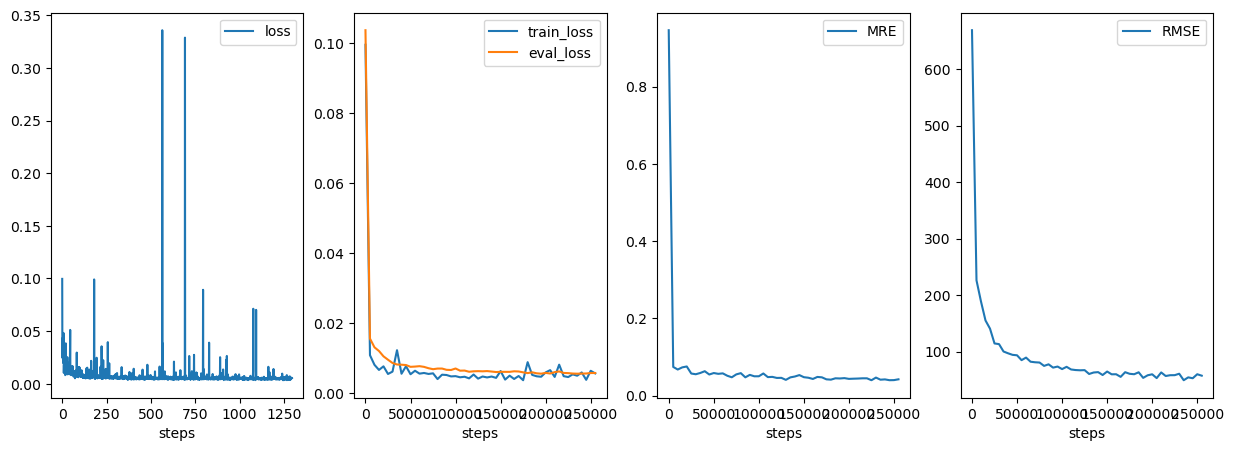

In [21]:
# model_type = ModelType.MLPTestSubgraph
# model_type = ModelType.LSTM
model_type = ModelType.GRU
# model_type = ModelType.Transformer
conf: Config = train_configs[model_type.name]
init_model = init_model_funcs[model_type.name]
model = init_model()
model = model.to(conf.device)
single_train_loop(model_type, conf, preprocessed_train_ds, preprocessed_eval_ds, model, compute_evaluate_metrics, to_device)

[2023-12-21 19:04:52,390] {535122644.py:28} INFO - Transformer nhead set to 6.
[2023-12-21 19:04:52,391] {transformer.py:74} INFO - Transformer model inited, hyper parameters: {'self': TransformerModel(), 'd_model': 66, 'nhead': 6, 'd_hid': 64, 'nlayers': 6, 'dropout': 0.0, 'output_d': 2, '__class__': <class 'transformer.TransformerModel'>}
[2023-12-21 19:04:52,401] {executor.py:148} INFO - ModelType.Transformer start single training.
[2023-12-21 19:04:52,402] {executor.py:150} INFO - ModelType.Transformer training epoch 0


  0%|          | 0/2591 [00:00<?, ?it/s]

[2023-12-21 19:04:52,461] {executor.py:111} INFO - ModelType.Transformer trained for 0.059914472 seconds.
[2023-12-21 19:04:52,462] {executor.py:112} INFO - ModelType.Transformer eval at step 0.
[2023-12-21 19:05:04,197] {executor.py:116} INFO - ModelType.Transformer train loss: 0.4186943769454956, eval metrics: {'eval_loss': 1.0683226779563546, 'MRE': 7.446001937618026, 'MAE': 5.369212220598461, 'RMSE': 3063.8245327718932}
[2023-12-21 19:05:04,209] {executor.py:187} INFO - Saving model at step 0 with loss 0.4186943769454956,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:08<00:00, 37.98it/s]

[2023-12-21 19:06:00,623] {executor.py:150} INFO - ModelType.Transformer training epoch 1



 93%|█████████▎| 2408/2591 [01:00<00:04, 40.41it/s]

[2023-12-21 19:07:00,934] {executor.py:111} INFO - ModelType.Transformer trained for 128.532269825 seconds.
[2023-12-21 19:07:00,935] {executor.py:112} INFO - ModelType.Transformer eval at step 5000.
[2023-12-21 19:07:12,658] {executor.py:116} INFO - ModelType.Transformer train loss: 0.08888991177082062, eval metrics: {'eval_loss': 0.4224724741135706, 'MRE': 0.6005321387369879, 'MAE': 0.3183858429329557, 'RMSE': 244.4508883193133}
[2023-12-21 19:07:12,664] {executor.py:187} INFO - Saving model at step 5000 with loss 0.08888991177082062,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:16<00:00, 33.91it/s]

[2023-12-21 19:07:17,034] {executor.py:150} INFO - ModelType.Transformer training epoch 2



100%|██████████| 2591/2591 [01:03<00:00, 40.79it/s]

[2023-12-21 19:08:20,561] {executor.py:150} INFO - ModelType.Transformer training epoch 3



 86%|████████▌ | 2225/2591 [00:55<00:08, 43.19it/s]

[2023-12-21 19:09:15,839] {executor.py:111} INFO - ModelType.Transformer trained for 263.437836767 seconds.
[2023-12-21 19:09:15,840] {executor.py:112} INFO - ModelType.Transformer eval at step 10000.
[2023-12-21 19:09:27,336] {executor.py:116} INFO - ModelType.Transformer train loss: 0.02032826840877533, eval metrics: {'eval_loss': 0.3481784503040017, 'MRE': 0.42426808729767335, 'MAE': 0.2920467271609115, 'RMSE': 183.6259150423295}
[2023-12-21 19:09:27,343] {executor.py:187} INFO - Saving model at step 10000 with loss 0.02032826840877533,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:15<00:00, 34.15it/s]

[2023-12-21 19:09:36,431] {executor.py:150} INFO - ModelType.Transformer training epoch 4



100%|██████████| 2591/2591 [01:02<00:00, 41.75it/s]

[2023-12-21 19:10:38,499] {executor.py:150} INFO - ModelType.Transformer training epoch 5



 79%|███████▉  | 2041/2591 [00:48<00:12, 43.79it/s]

[2023-12-21 19:11:27,469] {executor.py:111} INFO - ModelType.Transformer trained for 395.067463449 seconds.
[2023-12-21 19:11:27,470] {executor.py:112} INFO - ModelType.Transformer eval at step 15000.
[2023-12-21 19:11:39,366] {executor.py:116} INFO - ModelType.Transformer train loss: 0.00896795466542244, eval metrics: {'eval_loss': 0.3268583850403816, 'MRE': 1.7497443246875692, 'MAE': 0.9345929392238285, 'RMSE': 538.2316758481381}
[2023-12-21 19:11:39,376] {executor.py:187} INFO - Saving model at step 15000 with loss 0.00896795466542244,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:13<00:00, 35.48it/s]

[2023-12-21 19:11:51,521] {executor.py:150} INFO - ModelType.Transformer training epoch 6



100%|██████████| 2591/2591 [01:01<00:00, 42.10it/s]

[2023-12-21 19:12:53,063] {executor.py:150} INFO - ModelType.Transformer training epoch 7



 72%|███████▏  | 1860/2591 [00:46<00:18, 40.00it/s]

[2023-12-21 19:13:39,928] {executor.py:111} INFO - ModelType.Transformer trained for 527.526929897 seconds.
[2023-12-21 19:13:39,929] {executor.py:112} INFO - ModelType.Transformer eval at step 20000.
[2023-12-21 19:13:52,014] {executor.py:116} INFO - ModelType.Transformer train loss: 0.09031429141759872, eval metrics: {'eval_loss': 0.7168468742929831, 'MRE': 1.9494272896335214, 'MAE': 1.0816428977147747, 'RMSE': 684.2545430815687}
[2023-12-21 19:13:52,021] {executor.py:187} INFO - Saving model at step 20000 with loss 0.09031429141759872,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:17<00:00, 33.53it/s]

[2023-12-21 19:14:10,335] {executor.py:150} INFO - ModelType.Transformer training epoch 8



100%|██████████| 2591/2591 [01:01<00:00, 42.23it/s]

[2023-12-21 19:15:11,690] {executor.py:150} INFO - ModelType.Transformer training epoch 9



 65%|██████▍   | 1681/2591 [00:37<00:21, 42.84it/s]

[2023-12-21 19:15:49,456] {executor.py:111} INFO - ModelType.Transformer trained for 657.054120684 seconds.
[2023-12-21 19:15:49,456] {executor.py:112} INFO - ModelType.Transformer eval at step 25000.
[2023-12-21 19:16:01,558] {executor.py:116} INFO - ModelType.Transformer train loss: 0.12239422649145126, eval metrics: {'eval_loss': 0.7057988381433089, 'MRE': 0.7029088777367524, 'MAE': 0.4881711204788013, 'RMSE': 472.3804014276844}
[2023-12-21 19:16:01,570] {executor.py:187} INFO - Saving model at step 25000 with loss 0.12239422649145126,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:10<00:00, 36.63it/s]

[2023-12-21 19:16:22,419] {executor.py:150} INFO - ModelType.Transformer training epoch 10



100%|██████████| 2591/2591 [00:58<00:00, 44.67it/s]

[2023-12-21 19:17:20,430] {executor.py:150} INFO - ModelType.Transformer training epoch 11



 58%|█████▊    | 1497/2591 [00:36<00:23, 47.18it/s]

[2023-12-21 19:17:57,307] {executor.py:111} INFO - ModelType.Transformer trained for 784.906002355 seconds.
[2023-12-21 19:17:57,308] {executor.py:112} INFO - ModelType.Transformer eval at step 30000.
[2023-12-21 19:18:09,078] {executor.py:116} INFO - ModelType.Transformer train loss: 0.06782273203134537, eval metrics: {'eval_loss': 0.7058188843423533, 'MRE': 0.7095570630108481, 'MAE': 0.485739072405035, 'RMSE': 472.0530103607177}
[2023-12-21 19:18:09,085] {executor.py:187} INFO - Saving model at step 30000 with loss 0.06782273203134537,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:13<00:00, 35.32it/s]

[2023-12-21 19:18:33,801] {executor.py:150} INFO - ModelType.Transformer training epoch 12



100%|██████████| 2591/2591 [00:58<00:00, 44.34it/s]

[2023-12-21 19:19:32,238] {executor.py:150} INFO - ModelType.Transformer training epoch 13



 51%|█████     | 1317/2591 [00:29<00:28, 43.96it/s]

[2023-12-21 19:20:01,359] {executor.py:111} INFO - ModelType.Transformer trained for 908.958034784 seconds.
[2023-12-21 19:20:01,360] {executor.py:112} INFO - ModelType.Transformer eval at step 35000.
[2023-12-21 19:20:13,149] {executor.py:116} INFO - ModelType.Transformer train loss: 0.05615108460187912, eval metrics: {'eval_loss': 0.7056271951251418, 'MRE': 0.732337828299298, 'MAE': 0.4774136703414412, 'RMSE': 471.4086172483599}
[2023-12-21 19:20:13,157] {executor.py:187} INFO - Saving model at step 35000 with loss 0.05615108460187912,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:08<00:00, 37.90it/s]

[2023-12-21 19:20:40,601] {executor.py:150} INFO - ModelType.Transformer training epoch 14



100%|██████████| 2591/2591 [00:57<00:00, 45.06it/s]

[2023-12-21 19:21:38,111] {executor.py:150} INFO - ModelType.Transformer training epoch 15



 44%|████▎     | 1132/2591 [00:24<00:33, 43.87it/s]

[2023-12-21 19:22:02,957] {executor.py:111} INFO - ModelType.Transformer trained for 1030.555213078 seconds.
[2023-12-21 19:22:02,958] {executor.py:112} INFO - ModelType.Transformer eval at step 40000.


 44%|████▎     | 1132/2591 [00:35<00:33, 43.87it/s]

[2023-12-21 19:22:20,564] {executor.py:116} INFO - ModelType.Transformer train loss: 0.14018991589546204, eval metrics: {'eval_loss': 0.7057430896890965, 'MRE': 0.7280433549816786, 'MAE': 0.4789833273187371, 'RMSE': 471.47386358108713}
[2023-12-21 19:22:20,575] {executor.py:187} INFO - Saving model at step 40000 with loss 0.14018991589546204,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:16<00:00, 33.78it/s]

[2023-12-21 19:22:54,827] {executor.py:150} INFO - ModelType.Transformer training epoch 16



100%|██████████| 2591/2591 [01:10<00:00, 36.78it/s]

[2023-12-21 19:24:05,274] {executor.py:150} INFO - ModelType.Transformer training epoch 17



 37%|███▋      | 952/2591 [00:21<00:36, 45.02it/s]

[2023-12-21 19:24:26,457] {executor.py:111} INFO - ModelType.Transformer trained for 1174.05605705 seconds.
[2023-12-21 19:24:26,458] {executor.py:112} INFO - ModelType.Transformer eval at step 45000.
[2023-12-21 19:24:38,367] {executor.py:116} INFO - ModelType.Transformer train loss: 0.03852130472660065, eval metrics: {'eval_loss': 0.7060645523441292, 'MRE': 0.6773284490264205, 'MAE': 0.4973488083741104, 'RMSE': 474.13821822788583}
[2023-12-21 19:24:38,373] {executor.py:187} INFO - Saving model at step 45000 with loss 0.03852130472660065,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:16<00:00, 33.85it/s]

[2023-12-21 19:25:21,829] {executor.py:150} INFO - ModelType.Transformer training epoch 18



100%|██████████| 2591/2591 [01:02<00:00, 41.71it/s]

[2023-12-21 19:26:23,951] {executor.py:150} INFO - ModelType.Transformer training epoch 19



 30%|██▉       | 770/2591 [00:19<00:45, 40.01it/s]

[2023-12-21 19:26:43,225] {executor.py:111} INFO - ModelType.Transformer trained for 1310.823910071 seconds.
[2023-12-21 19:26:43,226] {executor.py:112} INFO - ModelType.Transformer eval at step 50000.


 30%|██▉       | 770/2591 [00:29<00:45, 40.01it/s]

[2023-12-21 19:26:55,177] {executor.py:116} INFO - ModelType.Transformer train loss: 0.07868152111768723, eval metrics: {'eval_loss': 0.6502671916191239, 'MRE': 0.39414893945376983, 'MAE': 0.3976839341807247, 'RMSE': 276.9987046972888}
[2023-12-21 19:26:55,186] {executor.py:187} INFO - Saving model at step 50000 with loss 0.07868152111768723,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:17<00:00, 33.32it/s]

[2023-12-21 19:27:41,715] {executor.py:150} INFO - ModelType.Transformer training epoch 20



100%|██████████| 2591/2591 [00:58<00:00, 44.38it/s]

[2023-12-21 19:28:40,105] {executor.py:150} INFO - ModelType.Transformer training epoch 21



 23%|██▎       | 585/2591 [00:14<00:49, 40.14it/s]

[2023-12-21 19:28:54,715] {executor.py:111} INFO - ModelType.Transformer trained for 1442.313322629 seconds.
[2023-12-21 19:28:54,716] {executor.py:112} INFO - ModelType.Transformer eval at step 55000.
[2023-12-21 19:29:06,632] {executor.py:116} INFO - ModelType.Transformer train loss: 0.016447583213448524, eval metrics: {'eval_loss': 0.6668890985171109, 'MRE': 0.6752965612395834, 'MAE': 0.38588237206517273, 'RMSE': 233.79410008735275}
[2023-12-21 19:29:06,638] {executor.py:187} INFO - Saving model at step 55000 with loss 0.016447583213448524,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:15<00:00, 34.41it/s]

[2023-12-21 19:29:55,410] {executor.py:150} INFO - ModelType.Transformer training epoch 22



100%|██████████| 2591/2591 [00:56<00:00, 45.59it/s]

[2023-12-21 19:30:52,247] {executor.py:150} INFO - ModelType.Transformer training epoch 23



 16%|█▌        | 407/2591 [00:09<00:49, 43.87it/s]

[2023-12-21 19:31:01,605] {executor.py:111} INFO - ModelType.Transformer trained for 1569.203803911 seconds.
[2023-12-21 19:31:01,606] {executor.py:112} INFO - ModelType.Transformer eval at step 60000.


 16%|█▌        | 407/2591 [00:21<00:49, 43.87it/s]

[2023-12-21 19:31:13,679] {executor.py:116} INFO - ModelType.Transformer train loss: 0.015571429394185543, eval metrics: {'eval_loss': 0.6900672222439085, 'MRE': 1.208876822507896, 'MAE': 0.642380702581756, 'RMSE': 508.30976623049804}
[2023-12-21 19:31:13,685] {executor.py:187} INFO - Saving model at step 60000 with loss 0.015571429394185543,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:10<00:00, 36.51it/s]

[2023-12-21 19:32:03,222] {executor.py:150} INFO - ModelType.Transformer training epoch 24



100%|██████████| 2591/2591 [00:55<00:00, 46.89it/s]

[2023-12-21 19:32:58,479] {executor.py:150} INFO - ModelType.Transformer training epoch 25



  9%|▊         | 224/2591 [00:05<01:04, 36.44it/s]

[2023-12-21 19:33:04,446] {executor.py:111} INFO - ModelType.Transformer trained for 1692.044746797 seconds.
[2023-12-21 19:33:04,447] {executor.py:112} INFO - ModelType.Transformer eval at step 65000.
[2023-12-21 19:33:18,443] {executor.py:116} INFO - ModelType.Transformer train loss: 0.042273398488759995, eval metrics: {'eval_loss': 0.7064958988467742, 'MRE': 0.804886027914385, 'MAE': 0.4511555733204985, 'RMSE': 474.24661852162336}
[2023-12-21 19:33:18,456] {executor.py:187} INFO - Saving model at step 65000 with loss 0.042273398488759995,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:12<00:00, 35.87it/s]

[2023-12-21 19:34:10,710] {executor.py:150} INFO - ModelType.Transformer training epoch 26



100%|██████████| 2591/2591 [00:56<00:00, 45.60it/s]

[2023-12-21 19:35:07,536] {executor.py:150} INFO - ModelType.Transformer training epoch 27



  2%|▏         | 42/2591 [00:01<00:58, 43.36it/s]

[2023-12-21 19:35:08,625] {executor.py:111} INFO - ModelType.Transformer trained for 1816.223819538 seconds.
[2023-12-21 19:35:08,626] {executor.py:112} INFO - ModelType.Transformer eval at step 70000.
[2023-12-21 19:35:20,511] {executor.py:116} INFO - ModelType.Transformer train loss: 0.8390654921531677, eval metrics: {'eval_loss': 0.705619486008814, 'MRE': 0.7691100933451896, 'MAE': 0.4639720199803623, 'RMSE': 471.924272022145}
[2023-12-21 19:35:20,519] {executor.py:187} INFO - Saving model at step 70000 with loss 0.8390654921531677,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:22<00:00, 31.37it/s]

[2023-12-21 19:36:30,122] {executor.py:150} INFO - ModelType.Transformer training epoch 28



 95%|█████████▍| 2451/2591 [00:53<00:03, 45.21it/s]

[2023-12-21 19:37:23,667] {executor.py:111} INFO - ModelType.Transformer trained for 1951.265406061 seconds.
[2023-12-21 19:37:23,668] {executor.py:112} INFO - ModelType.Transformer eval at step 75000.
[2023-12-21 19:37:35,776] {executor.py:116} INFO - ModelType.Transformer train loss: 0.14645765721797943, eval metrics: {'eval_loss': 0.7057993473760643, 'MRE': 0.7496326700952738, 'MAE': 0.47109157849770195, 'RMSE': 471.41171957177255}
[2023-12-21 19:37:35,787] {executor.py:187} INFO - Saving model at step 75000 with loss 0.14645765721797943,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:08<00:00, 37.57it/s]

[2023-12-21 19:37:39,097] {executor.py:150} INFO - ModelType.Transformer training epoch 29



100%|██████████| 2591/2591 [01:00<00:00, 43.00it/s]

[2023-12-21 19:38:39,354] {executor.py:150} INFO - ModelType.Transformer training epoch 30



 87%|████████▋ | 2267/2591 [00:49<00:06, 46.36it/s]

[2023-12-21 19:39:29,219] {executor.py:111} INFO - ModelType.Transformer trained for 2076.81795077 seconds.
[2023-12-21 19:39:29,220] {executor.py:112} INFO - ModelType.Transformer eval at step 80000.
[2023-12-21 19:39:40,974] {executor.py:116} INFO - ModelType.Transformer train loss: 0.7700916528701782, eval metrics: {'eval_loss': 0.7057372540533076, 'MRE': 0.8366236358016993, 'MAE': 0.4492528448797786, 'RMSE': 477.0873437244885}
[2023-12-21 19:39:40,980] {executor.py:187} INFO - Saving model at step 80000 with loss 0.7700916528701782,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:08<00:00, 37.79it/s]

[2023-12-21 19:39:47,929] {executor.py:150} INFO - ModelType.Transformer training epoch 31



100%|██████████| 2591/2591 [00:57<00:00, 45.33it/s]

[2023-12-21 19:40:45,094] {executor.py:150} INFO - ModelType.Transformer training epoch 32



 81%|████████  | 2087/2591 [00:45<00:10, 46.37it/s]

[2023-12-21 19:41:30,737] {executor.py:111} INFO - ModelType.Transformer trained for 2198.335395755 seconds.
[2023-12-21 19:41:30,738] {executor.py:112} INFO - ModelType.Transformer eval at step 85000.
[2023-12-21 19:41:42,455] {executor.py:116} INFO - ModelType.Transformer train loss: 0.010371141135692596, eval metrics: {'eval_loss': 0.7059129309019301, 'MRE': 0.691301529048426, 'MAE': 0.4924132331912938, 'RMSE': 473.1009575324487}
[2023-12-21 19:41:42,463] {executor.py:187} INFO - Saving model at step 85000 with loss 0.010371141135692596,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:08<00:00, 37.88it/s]

[2023-12-21 19:41:53,504] {executor.py:150} INFO - ModelType.Transformer training epoch 33



100%|██████████| 2591/2591 [00:56<00:00, 46.07it/s]

[2023-12-21 19:42:49,746] {executor.py:150} INFO - ModelType.Transformer training epoch 34



 73%|███████▎  | 1902/2591 [00:41<00:16, 42.69it/s]

[2023-12-21 19:43:31,547] {executor.py:111} INFO - ModelType.Transformer trained for 2319.145546708 seconds.
[2023-12-21 19:43:31,548] {executor.py:112} INFO - ModelType.Transformer eval at step 90000.
[2023-12-21 19:43:43,048] {executor.py:116} INFO - ModelType.Transformer train loss: 0.009066750295460224, eval metrics: {'eval_loss': 0.705715536543988, 'MRE': 0.7389057723299253, 'MAE': 0.47501254734764325, 'RMSE': 471.3597348381605}
[2023-12-21 19:43:43,060] {executor.py:187} INFO - Saving model at step 90000 with loss 0.009066750295460224,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:10<00:00, 36.68it/s]

[2023-12-21 19:44:00,397] {executor.py:150} INFO - ModelType.Transformer training epoch 35



100%|██████████| 2591/2591 [00:56<00:00, 45.47it/s]

[2023-12-21 19:44:57,378] {executor.py:150} INFO - ModelType.Transformer training epoch 36



 66%|██████▋   | 1722/2591 [00:41<00:17, 48.57it/s]

[2023-12-21 19:45:39,140] {executor.py:111} INFO - ModelType.Transformer trained for 2446.738552496 seconds.
[2023-12-21 19:45:39,141] {executor.py:112} INFO - ModelType.Transformer eval at step 95000.
[2023-12-21 19:45:50,874] {executor.py:116} INFO - ModelType.Transformer train loss: 0.3732227087020874, eval metrics: {'eval_loss': 0.7063810645875028, 'MRE': 0.49380086689207087, 'MAE': 0.567909798586327, 'RMSE': 514.6723853803243}
[2023-12-21 19:45:50,881] {executor.py:187} INFO - Saving model at step 95000 with loss 0.3732227087020874,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:12<00:00, 35.79it/s]

[2023-12-21 19:46:09,779] {executor.py:150} INFO - ModelType.Transformer training epoch 37



100%|██████████| 2591/2591 [01:01<00:00, 42.03it/s]

[2023-12-21 19:47:11,429] {executor.py:150} INFO - ModelType.Transformer training epoch 38



 60%|█████▉    | 1542/2591 [00:33<00:23, 44.70it/s]

[2023-12-21 19:47:45,268] {executor.py:111} INFO - ModelType.Transformer trained for 2572.866591834 seconds.
[2023-12-21 19:47:45,269] {executor.py:112} INFO - ModelType.Transformer eval at step 100000.
[2023-12-21 19:47:57,087] {executor.py:116} INFO - ModelType.Transformer train loss: 0.764575183391571, eval metrics: {'eval_loss': 0.70588173910975, 'MRE': 0.6953932002030462, 'MAE': 0.4909176090742825, 'RMSE': 472.8253228066043}
[2023-12-21 19:47:57,093] {executor.py:187} INFO - Saving model at step 100000 with loss 0.764575183391571,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:08<00:00, 37.70it/s]

[2023-12-21 19:48:20,164] {executor.py:150} INFO - ModelType.Transformer training epoch 39



100%|██████████| 2591/2591 [00:56<00:00, 45.65it/s]

[2023-12-21 19:49:16,919] {executor.py:150} INFO - ModelType.Transformer training epoch 40



 52%|█████▏    | 1357/2591 [00:28<00:27, 45.49it/s]

[2023-12-21 19:49:45,771] {executor.py:111} INFO - ModelType.Transformer trained for 2693.369869176 seconds.
[2023-12-21 19:49:45,772] {executor.py:112} INFO - ModelType.Transformer eval at step 105000.
[2023-12-21 19:49:58,056] {executor.py:116} INFO - ModelType.Transformer train loss: 0.08961497992277145, eval metrics: {'eval_loss': 0.7066596938845462, 'MRE': 0.6102774045985693, 'MAE': 0.5220298468985504, 'RMSE': 483.334602277799}
[2023-12-21 19:49:58,066] {executor.py:187} INFO - Saving model at step 105000 with loss 0.08961497992277145,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:09<00:00, 37.22it/s]

[2023-12-21 19:50:26,532] {executor.py:150} INFO - ModelType.Transformer training epoch 41



100%|██████████| 2591/2591 [00:56<00:00, 45.77it/s]

[2023-12-21 19:51:23,142] {executor.py:150} INFO - ModelType.Transformer training epoch 42



 45%|████▌     | 1177/2591 [00:25<00:29, 47.93it/s]

[2023-12-21 19:51:48,259] {executor.py:111} INFO - ModelType.Transformer trained for 2815.857740734 seconds.
[2023-12-21 19:51:48,260] {executor.py:112} INFO - ModelType.Transformer eval at step 110000.
[2023-12-21 19:52:05,779] {executor.py:116} INFO - ModelType.Transformer train loss: 0.249711811542511, eval metrics: {'eval_loss': 0.7056596157739737, 'MRE': 0.7818149047653807, 'MAE': 0.4593280583957904, 'RMSE': 472.54849536422563}
[2023-12-21 19:52:05,789] {executor.py:187} INFO - Saving model at step 110000 with loss 0.249711811542511,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:14<00:00, 34.98it/s]

[2023-12-21 19:52:37,219] {executor.py:150} INFO - ModelType.Transformer training epoch 43



100%|██████████| 2591/2591 [00:56<00:00, 45.82it/s]

[2023-12-21 19:53:33,774] {executor.py:150} INFO - ModelType.Transformer training epoch 44



 38%|███▊      | 995/2591 [00:22<00:34, 46.10it/s]

[2023-12-21 19:53:56,762] {executor.py:111} INFO - ModelType.Transformer trained for 2944.360840874 seconds.
[2023-12-21 19:53:56,763] {executor.py:112} INFO - ModelType.Transformer eval at step 115000.


 38%|███▊      | 995/2591 [00:33<00:34, 46.10it/s]

[2023-12-21 19:54:08,790] {executor.py:116} INFO - ModelType.Transformer train loss: 0.06991361081600189, eval metrics: {'eval_loss': 0.7057102301147223, 'MRE': 0.7252130048769412, 'MAE': 0.48001764507350775, 'RMSE': 471.5311810402834}
[2023-12-21 19:54:08,797] {executor.py:187} INFO - Saving model at step 115000 with loss 0.06991361081600189,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:09<00:00, 37.36it/s]

[2023-12-21 19:54:43,134] {executor.py:150} INFO - ModelType.Transformer training epoch 45



100%|██████████| 2591/2591 [01:00<00:00, 43.14it/s]

[2023-12-21 19:55:43,198] {executor.py:150} INFO - ModelType.Transformer training epoch 46



 31%|███▏      | 811/2591 [00:22<00:50, 35.14it/s]

[2023-12-21 19:56:05,944] {executor.py:111} INFO - ModelType.Transformer trained for 3073.542534283 seconds.
[2023-12-21 19:56:05,945] {executor.py:112} INFO - ModelType.Transformer eval at step 120000.


 31%|███▏      | 811/2591 [00:34<00:50, 35.14it/s]

[2023-12-21 19:56:19,689] {executor.py:116} INFO - ModelType.Transformer train loss: 0.016594935208559036, eval metrics: {'eval_loss': 0.7060194264546317, 'MRE': 0.6972509183983643, 'MAE': 0.4902385730939908, 'RMSE': 472.7079649109125}
[2023-12-21 19:56:19,701] {executor.py:187} INFO - Saving model at step 120000 with loss 0.016594935208559036,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:17<00:00, 33.43it/s]

[2023-12-21 19:57:00,702] {executor.py:150} INFO - ModelType.Transformer training epoch 47



100%|██████████| 2591/2591 [00:57<00:00, 44.83it/s]

[2023-12-21 19:57:58,503] {executor.py:150} INFO - ModelType.Transformer training epoch 48



 24%|██▍       | 630/2591 [00:15<00:48, 40.19it/s]

[2023-12-21 19:58:14,200] {executor.py:111} INFO - ModelType.Transformer trained for 3201.79866765 seconds.
[2023-12-21 19:58:14,201] {executor.py:112} INFO - ModelType.Transformer eval at step 125000.
[2023-12-21 19:58:26,181] {executor.py:116} INFO - ModelType.Transformer train loss: 0.37705135345458984, eval metrics: {'eval_loss': 0.7056827237171078, 'MRE': 0.7317291540514914, 'MAE': 0.4776358053408407, 'RMSE': 471.4163345209644}
[2023-12-21 19:58:26,192] {executor.py:187} INFO - Saving model at step 125000 with loss 0.37705135345458984,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:15<00:00, 34.40it/s]

[2023-12-21 19:59:13,834] {executor.py:150} INFO - ModelType.Transformer training epoch 49



100%|██████████| 2591/2591 [01:03<00:00, 41.03it/s]

[2023-12-21 20:00:16,979] {executor.py:150} INFO - ModelType.Transformer training epoch 50



 17%|█▋        | 447/2591 [00:10<00:49, 43.03it/s]

[2023-12-21 20:00:27,746] {executor.py:111} INFO - ModelType.Transformer trained for 3335.344959732 seconds.
[2023-12-21 20:00:27,747] {executor.py:112} INFO - ModelType.Transformer eval at step 130000.


 17%|█▋        | 447/2591 [00:20<00:49, 43.03it/s]

[2023-12-21 20:00:39,408] {executor.py:116} INFO - ModelType.Transformer train loss: 0.1587977409362793, eval metrics: {'eval_loss': 0.7059127168310086, 'MRE': 0.8272539298769686, 'MAE': 0.44840600822246846, 'RMSE': 476.2409662262177}
[2023-12-21 20:00:39,418] {executor.py:187} INFO - Saving model at step 130000 with loss 0.1587977409362793,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:13<00:00, 35.22it/s]

[2023-12-21 20:01:30,541] {executor.py:150} INFO - ModelType.Transformer training epoch 51



100%|██████████| 2591/2591 [00:59<00:00, 43.68it/s]

[2023-12-21 20:02:29,866] {executor.py:150} INFO - ModelType.Transformer training epoch 52



 10%|█         | 267/2591 [00:05<00:53, 43.35it/s]

[2023-12-21 20:02:35,822] {executor.py:111} INFO - ModelType.Transformer trained for 3463.420200276 seconds.
[2023-12-21 20:02:35,822] {executor.py:112} INFO - ModelType.Transformer eval at step 135000.


 10%|█         | 267/2591 [00:17<00:53, 43.35it/s]

[2023-12-21 20:02:47,906] {executor.py:116} INFO - ModelType.Transformer train loss: 0.12234705686569214, eval metrics: {'eval_loss': 0.7056230267713882, 'MRE': 0.7805525395788174, 'MAE': 0.4597894864312433, 'RMSE': 472.47626104990036}
[2023-12-21 20:02:47,912] {executor.py:187} INFO - Saving model at step 135000 with loss 0.12234705686569214,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:12<00:00, 35.81it/s]

[2023-12-21 20:03:42,224] {executor.py:150} INFO - ModelType.Transformer training epoch 53



100%|██████████| 2591/2591 [00:57<00:00, 45.06it/s]

[2023-12-21 20:04:39,727] {executor.py:150} INFO - ModelType.Transformer training epoch 54



  3%|▎         | 82/2591 [00:01<00:57, 43.49it/s]

[2023-12-21 20:04:41,783] {executor.py:111} INFO - ModelType.Transformer trained for 3589.381199655 seconds.
[2023-12-21 20:04:41,783] {executor.py:112} INFO - ModelType.Transformer eval at step 140000.
[2023-12-21 20:04:53,949] {executor.py:116} INFO - ModelType.Transformer train loss: 0.00989055261015892, eval metrics: {'eval_loss': 0.7056393411343569, 'MRE': 0.7404029423927918, 'MAE': 0.47446529876949967, 'RMSE': 471.35716303175747}
[2023-12-21 20:04:53,958] {executor.py:187} INFO - Saving model at step 140000 with loss 0.00989055261015892,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:09<00:00, 37.32it/s]

[2023-12-21 20:05:49,148] {executor.py:150} INFO - ModelType.Transformer training epoch 55



 96%|█████████▌| 2492/2591 [00:54<00:02, 46.38it/s]

[2023-12-21 20:06:43,919] {executor.py:111} INFO - ModelType.Transformer trained for 3711.517319436 seconds.
[2023-12-21 20:06:43,920] {executor.py:112} INFO - ModelType.Transformer eval at step 145000.
[2023-12-21 20:06:55,841] {executor.py:116} INFO - ModelType.Transformer train loss: 0.6612625122070312, eval metrics: {'eval_loss': 0.7059421946445631, 'MRE': 0.9074130113503913, 'MAE': 0.4782581172944089, 'RMSE': 483.16871605996073}
[2023-12-21 20:06:55,848] {executor.py:187} INFO - Saving model at step 145000 with loss 0.6612625122070312,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:08<00:00, 37.56it/s]

[2023-12-21 20:06:58,141] {executor.py:150} INFO - ModelType.Transformer training epoch 56



100%|██████████| 2591/2591 [01:01<00:00, 41.85it/s]

[2023-12-21 20:08:00,055] {executor.py:150} INFO - ModelType.Transformer training epoch 57



 89%|████████▉ | 2310/2591 [00:54<00:07, 38.75it/s]

[2023-12-21 20:08:55,030] {executor.py:111} INFO - ModelType.Transformer trained for 3842.628779503 seconds.
[2023-12-21 20:08:55,031] {executor.py:112} INFO - ModelType.Transformer eval at step 150000.


 89%|████████▉ | 2310/2591 [01:07<00:07, 38.75it/s]

[2023-12-21 20:09:08,368] {executor.py:116} INFO - ModelType.Transformer train loss: 0.8316118717193604, eval metrics: {'eval_loss': 0.7056265969101778, 'MRE': 0.7752671614162171, 'MAE': 0.4617214376138492, 'RMSE': 472.19826467474326}
[2023-12-21 20:09:08,378] {executor.py:187} INFO - Saving model at step 150000 with loss 0.8316118717193604,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:16<00:00, 33.95it/s]

[2023-12-21 20:09:16,367] {executor.py:150} INFO - ModelType.Transformer training epoch 58



100%|██████████| 2591/2591 [01:09<00:00, 37.39it/s]

[2023-12-21 20:10:25,675] {executor.py:150} INFO - ModelType.Transformer training epoch 59



 82%|████████▏ | 2130/2591 [00:50<00:09, 46.57it/s]

[2023-12-21 20:11:16,001] {executor.py:111} INFO - ModelType.Transformer trained for 3983.599472901 seconds.
[2023-12-21 20:11:16,002] {executor.py:112} INFO - ModelType.Transformer eval at step 155000.


 82%|████████▏ | 2130/2591 [01:02<00:09, 46.57it/s]

[2023-12-21 20:11:27,939] {executor.py:116} INFO - ModelType.Transformer train loss: 3.5734457969665527, eval metrics: {'eval_loss': 0.7056376026994117, 'MRE': 0.7523683338667215, 'MAE': 0.47009160336227557, 'RMSE': 471.451174499487}
[2023-12-21 20:11:27,949] {executor.py:187} INFO - Saving model at step 155000 with loss 3.5734457969665527,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:12<00:00, 35.62it/s]

[2023-12-21 20:11:38,427] {executor.py:150} INFO - ModelType.Transformer training epoch 60



100%|██████████| 2591/2591 [00:56<00:00, 45.72it/s]

[2023-12-21 20:12:35,107] {executor.py:150} INFO - ModelType.Transformer training epoch 61



 75%|███████▌  | 1947/2591 [00:42<00:13, 47.26it/s]

[2023-12-21 20:13:17,884] {executor.py:111} INFO - ModelType.Transformer trained for 4105.4827071 seconds.
[2023-12-21 20:13:17,885] {executor.py:112} INFO - ModelType.Transformer eval at step 160000.


 75%|███████▌  | 1947/2591 [00:52<00:13, 47.26it/s]

[2023-12-21 20:13:29,283] {executor.py:116} INFO - ModelType.Transformer train loss: 0.4571239650249481, eval metrics: {'eval_loss': 0.705946245722016, 'MRE': 0.922168606975045, 'MAE': 0.48591740499051983, 'RMSE': 484.52615018620907}
[2023-12-21 20:13:29,289] {executor.py:187} INFO - Saving model at step 160000 with loss 0.4571239650249481,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:08<00:00, 38.05it/s]

[2023-12-21 20:13:43,205] {executor.py:150} INFO - ModelType.Transformer training epoch 62



100%|██████████| 2591/2591 [00:56<00:00, 45.99it/s]

[2023-12-21 20:14:39,543] {executor.py:150} INFO - ModelType.Transformer training epoch 63



 68%|██████▊   | 1765/2591 [00:41<00:21, 39.28it/s]

[2023-12-21 20:15:20,699] {executor.py:111} INFO - ModelType.Transformer trained for 4228.297882607 seconds.
[2023-12-21 20:15:20,700] {executor.py:112} INFO - ModelType.Transformer eval at step 165000.
[2023-12-21 20:15:32,804] {executor.py:116} INFO - ModelType.Transformer train loss: 0.028312504291534424, eval metrics: {'eval_loss': 0.705643253666115, 'MRE': 0.7919048856809556, 'MAE': 0.45563988963124447, 'RMSE': 473.20664947869955}
[2023-12-21 20:15:32,815] {executor.py:187} INFO - Saving model at step 165000 with loss 0.028312504291534424,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:13<00:00, 35.07it/s]

[2023-12-21 20:15:53,421] {executor.py:150} INFO - ModelType.Transformer training epoch 64



100%|██████████| 2591/2591 [00:56<00:00, 45.90it/s]

[2023-12-21 20:16:49,877] {executor.py:150} INFO - ModelType.Transformer training epoch 65



 61%|██████    | 1581/2591 [00:38<00:24, 40.45it/s]

[2023-12-21 20:17:28,779] {executor.py:111} INFO - ModelType.Transformer trained for 4356.377374957 seconds.
[2023-12-21 20:17:28,780] {executor.py:112} INFO - ModelType.Transformer eval at step 170000.
[2023-12-21 20:17:40,577] {executor.py:116} INFO - ModelType.Transformer train loss: 0.3280259370803833, eval metrics: {'eval_loss': 0.7058223901544859, 'MRE': 0.6796687645034505, 'MAE': 0.4966653440563278, 'RMSE': 474.0131658480585}
[2023-12-21 20:17:40,586] {executor.py:187} INFO - Saving model at step 170000 with loss 0.3280259370803833,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:14<00:00, 34.82it/s]

[2023-12-21 20:18:04,282] {executor.py:150} INFO - ModelType.Transformer training epoch 66



100%|██████████| 2591/2591 [00:57<00:00, 45.22it/s]

[2023-12-21 20:19:01,588] {executor.py:150} INFO - ModelType.Transformer training epoch 67



 54%|█████▍    | 1402/2591 [00:30<00:24, 47.86it/s]

[2023-12-21 20:19:31,752] {executor.py:111} INFO - ModelType.Transformer trained for 4479.351014769 seconds.
[2023-12-21 20:19:31,753] {executor.py:112} INFO - ModelType.Transformer eval at step 175000.
[2023-12-21 20:19:43,702] {executor.py:116} INFO - ModelType.Transformer train loss: 1.7108033895492554, eval metrics: {'eval_loss': 0.7057457987392595, 'MRE': 0.7069950258338343, 'MAE': 0.4866768333563645, 'RMSE': 472.17219378670495}
[2023-12-21 20:19:43,709] {executor.py:187} INFO - Saving model at step 175000 with loss 1.7108033895492554,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:12<00:00, 35.89it/s]

[2023-12-21 20:20:13,775] {executor.py:150} INFO - ModelType.Transformer training epoch 68



100%|██████████| 2591/2591 [00:55<00:00, 46.34it/s]

[2023-12-21 20:21:09,688] {executor.py:150} INFO - ModelType.Transformer training epoch 69



 47%|████▋     | 1220/2591 [00:29<00:31, 42.86it/s]

[2023-12-21 20:21:39,221] {executor.py:111} INFO - ModelType.Transformer trained for 4606.819307983 seconds.
[2023-12-21 20:21:39,221] {executor.py:112} INFO - ModelType.Transformer eval at step 180000.


 47%|████▋     | 1220/2591 [00:39<00:31, 42.86it/s]

[2023-12-21 20:21:56,438] {executor.py:116} INFO - ModelType.Transformer train loss: 0.3296111226081848, eval metrics: {'eval_loss': 0.7056658513692089, 'MRE': 0.8215674728793525, 'MAE': 0.4483956845827442, 'RMSE': 475.7321997845657}
[2023-12-21 20:21:56,444] {executor.py:187} INFO - Saving model at step 180000 with loss 0.3296111226081848,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:20<00:00, 32.01it/s]

[2023-12-21 20:22:30,644] {executor.py:150} INFO - ModelType.Transformer training epoch 70



100%|██████████| 2591/2591 [01:00<00:00, 42.98it/s]

[2023-12-21 20:23:30,926] {executor.py:150} INFO - ModelType.Transformer training epoch 71



 40%|████      | 1038/2591 [00:22<00:33, 46.83it/s]

[2023-12-21 20:23:53,437] {executor.py:111} INFO - ModelType.Transformer trained for 4741.035697211 seconds.
[2023-12-21 20:23:53,438] {executor.py:112} INFO - ModelType.Transformer eval at step 185000.
[2023-12-21 20:24:05,078] {executor.py:116} INFO - ModelType.Transformer train loss: 0.12121793627738953, eval metrics: {'eval_loss': 0.7056241797685127, 'MRE': 0.7819608407571842, 'MAE': 0.45927471278223675, 'RMSE': 472.55699259960807}
[2023-12-21 20:24:05,084] {executor.py:187} INFO - Saving model at step 185000 with loss 0.12121793627738953,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:08<00:00, 37.96it/s]

[2023-12-21 20:24:39,184] {executor.py:150} INFO - ModelType.Transformer training epoch 72



100%|██████████| 2591/2591 [00:56<00:00, 46.08it/s]

[2023-12-21 20:25:35,410] {executor.py:150} INFO - ModelType.Transformer training epoch 73



 33%|███▎      | 857/2591 [00:20<00:40, 42.40it/s]

[2023-12-21 20:25:55,610] {executor.py:111} INFO - ModelType.Transformer trained for 4863.208819609 seconds.
[2023-12-21 20:25:55,611] {executor.py:112} INFO - ModelType.Transformer eval at step 190000.
[2023-12-21 20:26:07,556] {executor.py:116} INFO - ModelType.Transformer train loss: 4.432767868041992, eval metrics: {'eval_loss': 0.705915957653664, 'MRE': 0.7017134356975844, 'MAE': 0.488607401163864, 'RMSE': 472.44593891680273}
[2023-12-21 20:26:07,567] {executor.py:187} INFO - Saving model at step 190000 with loss 4.432767868041992,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:10<00:00, 36.71it/s]

[2023-12-21 20:26:46,003] {executor.py:150} INFO - ModelType.Transformer training epoch 74



100%|██████████| 2591/2591 [01:00<00:00, 42.81it/s]

[2023-12-21 20:27:46,526] {executor.py:150} INFO - ModelType.Transformer training epoch 75



 26%|██▌       | 672/2591 [00:14<00:42, 45.59it/s]

[2023-12-21 20:28:01,434] {executor.py:111} INFO - ModelType.Transformer trained for 4989.032366502 seconds.
[2023-12-21 20:28:01,435] {executor.py:112} INFO - ModelType.Transformer eval at step 195000.
[2023-12-21 20:28:13,350] {executor.py:116} INFO - ModelType.Transformer train loss: 2.711038589477539, eval metrics: {'eval_loss': 0.7056830816665793, 'MRE': 0.6827601722549178, 'MAE': 0.49553534776024905, 'RMSE': 473.7522349369556}
[2023-12-21 20:28:13,358] {executor.py:187} INFO - Saving model at step 195000 with loss 2.711038589477539,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:09<00:00, 37.46it/s]

[2023-12-21 20:28:55,689] {executor.py:150} INFO - ModelType.Transformer training epoch 76



100%|██████████| 2591/2591 [01:04<00:00, 40.42it/s]

[2023-12-21 20:29:59,790] {executor.py:150} INFO - ModelType.Transformer training epoch 77



 19%|█▉        | 489/2591 [00:10<00:45, 46.56it/s]

[2023-12-21 20:30:10,569] {executor.py:111} INFO - ModelType.Transformer trained for 5118.167637124 seconds.
[2023-12-21 20:30:10,570] {executor.py:112} INFO - ModelType.Transformer eval at step 200000.
[2023-12-21 20:30:22,480] {executor.py:116} INFO - ModelType.Transformer train loss: 0.041283026337623596, eval metrics: {'eval_loss': 0.705655273304925, 'MRE': 0.7977673150805914, 'MAE': 0.4535385174466152, 'RMSE': 473.65238302952326}
[2023-12-21 20:30:22,492] {executor.py:187} INFO - Saving model at step 200000 with loss 0.041283026337623596,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:12<00:00, 35.95it/s]

[2023-12-21 20:31:11,861] {executor.py:150} INFO - ModelType.Transformer training epoch 78



100%|██████████| 2591/2591 [00:56<00:00, 45.72it/s]

[2023-12-21 20:32:08,534] {executor.py:150} INFO - ModelType.Transformer training epoch 79



 12%|█▏        | 307/2591 [00:06<00:48, 46.90it/s]

[2023-12-21 20:32:15,346] {executor.py:111} INFO - ModelType.Transformer trained for 5242.944437985 seconds.
[2023-12-21 20:32:15,347] {executor.py:112} INFO - ModelType.Transformer eval at step 205000.
[2023-12-21 20:32:27,016] {executor.py:116} INFO - ModelType.Transformer train loss: 0.7771126627922058, eval metrics: {'eval_loss': 0.7056204128918745, 'MRE': 0.7843295750158228, 'MAE': 0.45840887361563987, 'RMSE': 472.69909868411435}
[2023-12-21 20:32:27,027] {executor.py:187} INFO - Saving model at step 205000 with loss 0.7771126627922058,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:07<00:00, 38.21it/s]

[2023-12-21 20:33:16,347] {executor.py:150} INFO - ModelType.Transformer training epoch 80



100%|██████████| 2591/2591 [01:01<00:00, 41.86it/s]

[2023-12-21 20:34:18,243] {executor.py:150} INFO - ModelType.Transformer training epoch 81



  5%|▍         | 129/2591 [00:02<00:51, 47.84it/s]

[2023-12-21 20:34:21,087] {executor.py:111} INFO - ModelType.Transformer trained for 5368.685181801 seconds.
[2023-12-21 20:34:21,087] {executor.py:112} INFO - ModelType.Transformer eval at step 210000.
[2023-12-21 20:34:32,932] {executor.py:116} INFO - ModelType.Transformer train loss: 0.01802617311477661, eval metrics: {'eval_loss': 0.7056837641361212, 'MRE': 0.7610908200181614, 'MAE': 0.4669032928734861, 'RMSE': 471.64799883252516}
[2023-12-21 20:34:32,940] {executor.py:187} INFO - Saving model at step 210000 with loss 0.01802617311477661,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:08<00:00, 37.90it/s]

[2023-12-21 20:35:26,607] {executor.py:150} INFO - ModelType.Transformer training epoch 82



 98%|█████████▊| 2537/2591 [00:58<00:01, 43.22it/s]

[2023-12-21 20:36:24,796] {executor.py:111} INFO - ModelType.Transformer trained for 5492.394239454 seconds.
[2023-12-21 20:36:24,797] {executor.py:112} INFO - ModelType.Transformer eval at step 215000.
[2023-12-21 20:36:37,006] {executor.py:116} INFO - ModelType.Transformer train loss: 0.2699015736579895, eval metrics: {'eval_loss': 0.7056232222412536, 'MRE': 0.7788782721873811, 'MAE': 0.460401484508482, 'RMSE': 472.38392507322556}
[2023-12-21 20:36:37,013] {executor.py:187} INFO - Saving model at step 215000 with loss 0.2699015736579895,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:11<00:00, 36.02it/s]

[2023-12-21 20:36:38,543] {executor.py:150} INFO - ModelType.Transformer training epoch 83



100%|██████████| 2591/2591 [00:57<00:00, 45.44it/s]

[2023-12-21 20:37:35,570] {executor.py:150} INFO - ModelType.Transformer training epoch 84



 91%|█████████ | 2352/2591 [00:56<00:05, 40.16it/s]

[2023-12-21 20:38:32,075] {executor.py:111} INFO - ModelType.Transformer trained for 5619.673266704 seconds.
[2023-12-21 20:38:32,075] {executor.py:112} INFO - ModelType.Transformer eval at step 220000.
[2023-12-21 20:38:44,003] {executor.py:116} INFO - ModelType.Transformer train loss: 0.35818275809288025, eval metrics: {'eval_loss': 0.7056227370617465, 'MRE': 0.7558978037927108, 'MAE': 0.4688014867836717, 'RMSE': 471.5177966184598}
[2023-12-21 20:38:44,009] {executor.py:187} INFO - Saving model at step 220000 with loss 0.35818275809288025,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:15<00:00, 34.42it/s]

[2023-12-21 20:38:50,839] {executor.py:150} INFO - ModelType.Transformer training epoch 85



100%|██████████| 2591/2591 [00:56<00:00, 45.55it/s]

[2023-12-21 20:39:47,720] {executor.py:150} INFO - ModelType.Transformer training epoch 86



 84%|████████▍ | 2172/2591 [00:47<00:08, 46.64it/s]

[2023-12-21 20:40:34,910] {executor.py:111} INFO - ModelType.Transformer trained for 5742.508498113 seconds.
[2023-12-21 20:40:34,911] {executor.py:112} INFO - ModelType.Transformer eval at step 225000.
[2023-12-21 20:40:46,507] {executor.py:116} INFO - ModelType.Transformer train loss: 0.04359787330031395, eval metrics: {'eval_loss': 0.7057526068717895, 'MRE': 0.7397897358494957, 'MAE': 0.47468943823499105, 'RMSE': 471.3578291561972}
[2023-12-21 20:40:46,514] {executor.py:187} INFO - Saving model at step 225000 with loss 0.04359787330031395,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:08<00:00, 37.95it/s]

[2023-12-21 20:40:55,992] {executor.py:150} INFO - ModelType.Transformer training epoch 87



100%|██████████| 2591/2591 [00:57<00:00, 45.26it/s]

[2023-12-21 20:41:53,237] {executor.py:150} INFO - ModelType.Transformer training epoch 88



 77%|███████▋  | 1992/2591 [00:52<00:15, 39.28it/s]

[2023-12-21 20:42:45,988] {executor.py:111} INFO - ModelType.Transformer trained for 5873.587102648 seconds.
[2023-12-21 20:42:45,989] {executor.py:112} INFO - ModelType.Transformer eval at step 230000.
[2023-12-21 20:42:58,145] {executor.py:116} INFO - ModelType.Transformer train loss: 0.04742954671382904, eval metrics: {'eval_loss': 0.7057320037360023, 'MRE': 0.7292567374688933, 'MAE': 0.47853954539826854, 'RMSE': 471.4528045119659}
[2023-12-21 20:42:58,151] {executor.py:187} INFO - Saving model at step 230000 with loss 0.04742954671382904,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:19<00:00, 32.55it/s]

[2023-12-21 20:43:12,850] {executor.py:150} INFO - ModelType.Transformer training epoch 89



100%|██████████| 2591/2591 [00:56<00:00, 45.70it/s]

[2023-12-21 20:44:09,548] {executor.py:150} INFO - ModelType.Transformer training epoch 90



 70%|██████▉   | 1810/2591 [00:40<00:23, 33.10it/s]

[2023-12-21 20:44:49,736] {executor.py:111} INFO - ModelType.Transformer trained for 5997.334250909 seconds.
[2023-12-21 20:44:49,737] {executor.py:112} INFO - ModelType.Transformer eval at step 235000.
[2023-12-21 20:45:03,480] {executor.py:116} INFO - ModelType.Transformer train loss: 0.01945074088871479, eval metrics: {'eval_loss': 0.7056235566197689, 'MRE': 0.7835339039849447, 'MAE': 0.45869971031018403, 'RMSE': 472.6504787846033}
[2023-12-21 20:45:03,489] {executor.py:187} INFO - Saving model at step 235000 with loss 0.01945074088871479,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:17<00:00, 33.38it/s]

[2023-12-21 20:45:27,171] {executor.py:150} INFO - ModelType.Transformer training epoch 91



100%|██████████| 2591/2591 [01:04<00:00, 40.01it/s]

[2023-12-21 20:46:31,925] {executor.py:150} INFO - ModelType.Transformer training epoch 92



 63%|██████▎   | 1626/2591 [00:40<00:23, 40.27it/s]

[2023-12-21 20:47:12,858] {executor.py:111} INFO - ModelType.Transformer trained for 6140.456720847 seconds.
[2023-12-21 20:47:12,859] {executor.py:112} INFO - ModelType.Transformer eval at step 240000.
[2023-12-21 20:47:24,827] {executor.py:116} INFO - ModelType.Transformer train loss: 0.0183570459485054, eval metrics: {'eval_loss': 0.7056522503451167, 'MRE': 0.7938956607525186, 'MAE': 0.4549122010070949, 'RMSE': 473.35343333080874}
[2023-12-21 20:47:24,833] {executor.py:187} INFO - Saving model at step 240000 with loss 0.0183570459485054,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:13<00:00, 35.11it/s]

[2023-12-21 20:47:45,723] {executor.py:150} INFO - ModelType.Transformer training epoch 93



100%|██████████| 2591/2591 [01:09<00:00, 37.50it/s]

[2023-12-21 20:48:54,813] {executor.py:150} INFO - ModelType.Transformer training epoch 94



 56%|█████▌    | 1446/2591 [00:38<00:29, 38.92it/s]

[2023-12-21 20:49:32,853] {executor.py:111} INFO - ModelType.Transformer trained for 6280.45106101 seconds.
[2023-12-21 20:49:32,853] {executor.py:112} INFO - ModelType.Transformer eval at step 245000.
[2023-12-21 20:49:46,315] {executor.py:116} INFO - ModelType.Transformer train loss: 0.07024355977773666, eval metrics: {'eval_loss': 0.7058418555729968, 'MRE': 0.9308052271208228, 'MAE': 0.49049252712538033, 'RMSE': 485.34613294546745}
[2023-12-21 20:49:46,325] {executor.py:187} INFO - Saving model at step 245000 with loss 0.07024355977773666,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:23<00:00, 31.17it/s]

[2023-12-21 20:50:17,935] {executor.py:150} INFO - ModelType.Transformer training epoch 95



100%|██████████| 2591/2591 [01:04<00:00, 40.22it/s]

[2023-12-21 20:51:22,357] {executor.py:150} INFO - ModelType.Transformer training epoch 96



 49%|████▊     | 1262/2591 [00:26<00:28, 46.70it/s]

[2023-12-21 20:51:49,117] {executor.py:111} INFO - ModelType.Transformer trained for 6416.715437643 seconds.
[2023-12-21 20:51:49,118] {executor.py:112} INFO - ModelType.Transformer eval at step 250000.


 49%|████▊     | 1262/2591 [00:38<00:28, 46.70it/s]

[2023-12-21 20:52:06,853] {executor.py:116} INFO - ModelType.Transformer train loss: 0.8586789965629578, eval metrics: {'eval_loss': 0.70579779887429, 'MRE': 0.7026941628406723, 'MAE': 0.48824891402169274, 'RMSE': 472.3921230478941}
[2023-12-21 20:52:06,861] {executor.py:187} INFO - Saving model at step 250000 with loss 0.8586789965629578,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:18<00:00, 32.81it/s]

[2023-12-21 20:52:41,341] {executor.py:150} INFO - ModelType.Transformer training epoch 97



100%|██████████| 2591/2591 [01:00<00:00, 42.83it/s]

[2023-12-21 20:53:41,833] {executor.py:150} INFO - ModelType.Transformer training epoch 98



 42%|████▏     | 1080/2591 [00:28<00:32, 46.74it/s]

[2023-12-21 20:54:10,167] {executor.py:111} INFO - ModelType.Transformer trained for 6557.765753106 seconds.
[2023-12-21 20:54:10,168] {executor.py:112} INFO - ModelType.Transformer eval at step 255000.


 42%|████▏     | 1080/2591 [00:39<00:32, 46.74it/s]

[2023-12-21 20:54:22,050] {executor.py:116} INFO - ModelType.Transformer train loss: 322.2513122558594, eval metrics: {'eval_loss': 0.7057045068093809, 'MRE': 0.8680641118334035, 'MAE': 0.4591159086217798, 'RMSE': 479.7931347981234}
[2023-12-21 20:54:22,067] {executor.py:187} INFO - Saving model at step 255000 with loss 322.2513122558594,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/Transformer/single_train2023-12-21_19-04-52


100%|██████████| 2591/2591 [01:14<00:00, 34.92it/s]

[2023-12-21 20:54:56,033] {executor.py:150} INFO - ModelType.Transformer training epoch 99



100%|██████████| 2591/2591 [01:11<00:00, 36.39it/s]


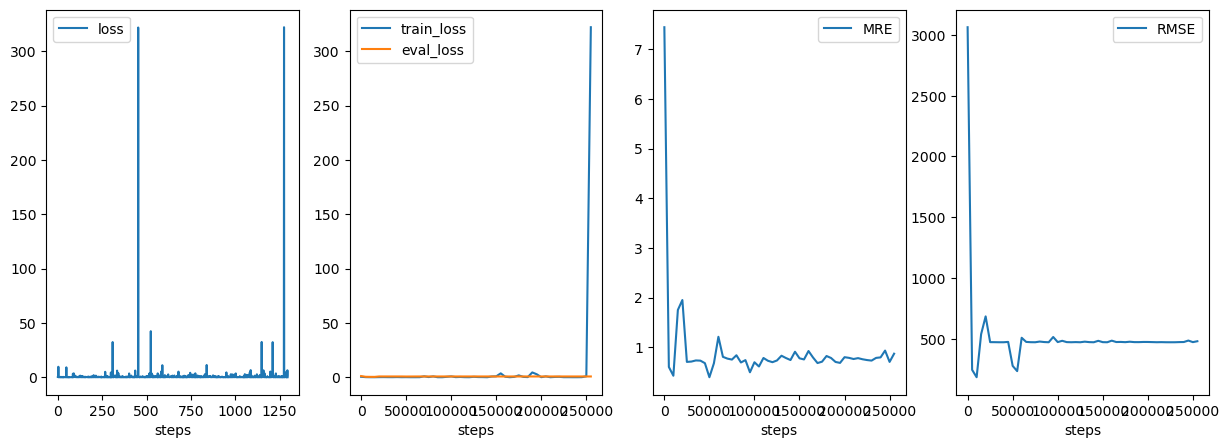

In [22]:
# model_type = ModelType.MLPTestSubgraph
# model_type = ModelType.LSTM
# model_type = ModelType.GRU
model_type = ModelType.Transformer
conf: Config = train_configs[model_type.name]
init_model = init_model_funcs[model_type.name]
model = init_model()
model = model.to(conf.device)
single_train_loop(model_type, conf, preprocessed_train_ds, preprocessed_eval_ds, model, compute_evaluate_metrics, to_device)

[2023-12-21 20:56:07,969] {executor.py:148} INFO - ModelType.GCNSubgraph start single training.
[2023-12-21 20:56:07,970] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 0


  0%|          | 0/2591 [00:00<?, ?it/s]

[2023-12-21 20:56:08,002] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 0.032166788 seconds.
[2023-12-21 20:56:08,002] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 0.
[2023-12-21 20:56:20,393] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.42334192991256714, eval metrics: {'eval_loss': 0.3348136902660937, 'MRE': 7.352571721847296, 'MAE': 3.902170793081653, 'RMSE': 2214.7121371251333}
[2023-12-21 20:56:20,411] {executor.py:187} INFO - Saving model at step 0 with loss 0.42334192991256714,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:23<00:00, 110.38it/s]

[2023-12-21 20:56:31,445] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 1



 92%|█████████▏| 2390/2591 [00:10<00:00, 221.51it/s]

[2023-12-21 20:56:42,277] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 34.30795713 seconds.
[2023-12-21 20:56:42,278] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 5000.
[2023-12-21 20:56:54,670] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.028037570416927338, eval metrics: {'eval_loss': 0.04618081984512012, 'MRE': 0.3156202104438794, 'MAE': 0.4219218371725466, 'RMSE': 477.07993416061095}
[2023-12-21 20:56:54,676] {executor.py:187} INFO - Saving model at step 5000 with loss 0.028037570416927338,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:24<00:00, 107.20it/s]

[2023-12-21 20:56:55,617] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 2



100%|██████████| 2591/2591 [00:10<00:00, 240.22it/s]

[2023-12-21 20:57:06,406] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 3



 85%|████████▌ | 2203/2591 [00:08<00:01, 252.53it/s]

[2023-12-21 20:57:15,442] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 67.47216603 seconds.
[2023-12-21 20:57:15,442] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 10000.
[2023-12-21 20:57:25,927] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.03746179863810539, eval metrics: {'eval_loss': 0.045462938371243884, 'MRE': 0.29878406529101686, 'MAE': 0.4061658549448213, 'RMSE': 470.3074363331753}
[2023-12-21 20:57:25,936] {executor.py:187} INFO - Saving model at step 10000 with loss 0.03746179863810539,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:20<00:00, 123.72it/s]

[2023-12-21 20:57:27,351] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 4



100%|██████████| 2591/2591 [00:08<00:00, 291.54it/s]

[2023-12-21 20:57:36,242] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 5



 79%|███████▉  | 2045/2591 [00:08<00:02, 238.60it/s]

[2023-12-21 20:57:44,738] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 96.768085315 seconds.
[2023-12-21 20:57:44,738] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 15000.
[2023-12-21 20:57:57,065] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.032045863568782806, eval metrics: {'eval_loss': 0.045073807864534424, 'MRE': 0.28699101449107955, 'MAE': 0.4043242996075229, 'RMSE': 471.1965592306254}
[2023-12-21 20:57:57,081] {executor.py:187} INFO - Saving model at step 15000 with loss 0.032045863568782806,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:23<00:00, 110.44it/s]

[2023-12-21 20:57:59,706] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 6



100%|██████████| 2591/2591 [00:09<00:00, 283.47it/s]

[2023-12-21 20:58:08,850] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 7



 72%|███████▏  | 1854/2591 [00:07<00:02, 263.86it/s]

[2023-12-21 20:58:16,216] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 128.246200974 seconds.
[2023-12-21 20:58:16,216] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 20000.
[2023-12-21 20:58:27,053] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.04025498032569885, eval metrics: {'eval_loss': 0.04495787676167584, 'MRE': 0.283147164105855, 'MAE': 0.3924103542446207, 'RMSE': 467.4391400634268}
[2023-12-21 20:58:27,069] {executor.py:187} INFO - Saving model at step 20000 with loss 0.04025498032569885,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:21<00:00, 121.04it/s]

[2023-12-21 20:58:30,258] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 8



100%|██████████| 2591/2591 [00:09<00:00, 282.39it/s]

[2023-12-21 20:58:39,436] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 9



 64%|██████▍   | 1671/2591 [00:07<00:03, 248.29it/s]

[2023-12-21 20:58:46,632] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 158.662373355 seconds.
[2023-12-21 20:58:46,633] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 25000.
[2023-12-21 20:58:58,781] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.04160521179437637, eval metrics: {'eval_loss': 0.04495368485809142, 'MRE': 0.2801038054849155, 'MAE': 0.40182924719703556, 'RMSE': 471.3765683831926}
[2023-12-21 20:58:58,797] {executor.py:187} INFO - Saving model at step 25000 with loss 0.04160521179437637,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:23<00:00, 112.33it/s]

[2023-12-21 20:59:02,506] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 10



100%|██████████| 2591/2591 [00:09<00:00, 277.61it/s]

[2023-12-21 20:59:11,843] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 11



 57%|█████▋    | 1489/2591 [00:05<00:03, 283.93it/s]

[2023-12-21 20:59:17,220] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 189.250429886 seconds.
[2023-12-21 20:59:17,220] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 30000.
[2023-12-21 20:59:27,781] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.04187115654349327, eval metrics: {'eval_loss': 0.044924934552649835, 'MRE': 0.28514577948498604, 'MAE': 0.40011765968427065, 'RMSE': 468.30373563325514}
[2023-12-21 20:59:27,788] {executor.py:187} INFO - Saving model at step 30000 with loss 0.04187115654349327,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:20<00:00, 127.82it/s]

[2023-12-21 20:59:32,117] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 12



100%|██████████| 2591/2591 [00:09<00:00, 273.05it/s]

[2023-12-21 20:59:41,609] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 13



 50%|█████     | 1306/2591 [00:04<00:04, 281.55it/s]

[2023-12-21 20:59:46,357] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 218.387768849 seconds.
[2023-12-21 20:59:46,358] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 35000.
[2023-12-21 20:59:57,009] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.05868365615606308, eval metrics: {'eval_loss': 0.044671416935973, 'MRE': 0.28165259916871543, 'MAE': 0.39765466653506515, 'RMSE': 466.78596863010273}
[2023-12-21 20:59:57,020] {executor.py:187} INFO - Saving model at step 35000 with loss 0.05868365615606308,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:20<00:00, 128.84it/s]

[2023-12-21 21:00:01,722] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 14



100%|██████████| 2591/2591 [00:09<00:00, 286.17it/s]

[2023-12-21 21:00:10,780] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 15



 43%|████▎     | 1127/2591 [00:03<00:05, 288.06it/s]

[2023-12-21 21:00:14,797] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 246.827654237 seconds.
[2023-12-21 21:00:14,798] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 40000.
[2023-12-21 21:00:25,663] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.036237575113773346, eval metrics: {'eval_loss': 0.044574668790523006, 'MRE': 0.2883660182114728, 'MAE': 0.39681648496405736, 'RMSE': 464.557511103444}
[2023-12-21 21:00:25,669] {executor.py:187} INFO - Saving model at step 40000 with loss 0.036237575113773346,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:20<00:00, 129.23it/s]

[2023-12-21 21:00:30,833] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 16



100%|██████████| 2591/2591 [00:09<00:00, 280.24it/s]

[2023-12-21 21:00:40,082] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 17



 37%|███▋      | 948/2591 [00:03<00:05, 296.37it/s]

[2023-12-21 21:00:43,368] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 275.398931851 seconds.
[2023-12-21 21:00:43,369] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 45000.
[2023-12-21 21:00:53,989] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.06332956254482269, eval metrics: {'eval_loss': 0.04475342573527908, 'MRE': 0.2875659967064552, 'MAE': 0.3979262206427622, 'RMSE': 463.6400269057184}
[2023-12-21 21:00:53,997] {executor.py:187} INFO - Saving model at step 45000 with loss 0.06332956254482269,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:19<00:00, 131.84it/s]

[2023-12-21 21:00:59,737] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 18



100%|██████████| 2591/2591 [00:08<00:00, 298.28it/s]

[2023-12-21 21:01:08,427] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 19



 29%|██▉       | 756/2591 [00:02<00:06, 303.62it/s]

[2023-12-21 21:01:11,038] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 303.068860908 seconds.
[2023-12-21 21:01:11,039] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 50000.


 29%|██▉       | 756/2591 [00:12<00:06, 303.62it/s]

[2023-12-21 21:01:21,454] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.0346609428524971, eval metrics: {'eval_loss': 0.044683165763078694, 'MRE': 0.2859034914443483, 'MAE': 0.4051996465032891, 'RMSE': 470.0138744860301}
[2023-12-21 21:01:21,460] {executor.py:187} INFO - Saving model at step 50000 with loss 0.0346609428524971,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:19<00:00, 133.56it/s]

[2023-12-21 21:01:27,830] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 20



100%|██████████| 2591/2591 [00:10<00:00, 247.10it/s]

[2023-12-21 21:01:38,320] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 21



 22%|██▏       | 568/2591 [00:02<00:09, 224.23it/s]

[2023-12-21 21:01:40,910] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 332.940391726 seconds.
[2023-12-21 21:01:40,910] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 55000.


 22%|██▏       | 568/2591 [00:12<00:09, 224.23it/s]

[2023-12-21 21:01:52,963] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.04462631791830063, eval metrics: {'eval_loss': 0.044699932865233924, 'MRE': 0.2860078755017479, 'MAE': 0.40415846579944736, 'RMSE': 469.9104389401925}
[2023-12-21 21:01:52,980] {executor.py:187} INFO - Saving model at step 55000 with loss 0.04462631791830063,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:23<00:00, 110.91it/s]

[2023-12-21 21:02:01,683] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 22



100%|██████████| 2591/2591 [00:09<00:00, 276.12it/s]

[2023-12-21 21:02:11,070] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 23



 15%|█▌        | 401/2591 [00:01<00:07, 292.27it/s]

[2023-12-21 21:02:12,533] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 364.563974583 seconds.
[2023-12-21 21:02:12,534] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 60000.


 15%|█▌        | 401/2591 [00:12<00:07, 292.27it/s]

[2023-12-21 21:02:29,278] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.03460816666483879, eval metrics: {'eval_loss': 0.04469188700320422, 'MRE': 0.28678427876759915, 'MAE': 0.4011767105815201, 'RMSE': 464.5062566276124}
[2023-12-21 21:02:29,284] {executor.py:187} INFO - Saving model at step 60000 with loss 0.03460816666483879,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:25<00:00, 100.91it/s]

[2023-12-21 21:02:36,750] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 24



100%|██████████| 2591/2591 [00:09<00:00, 279.17it/s]

[2023-12-21 21:02:46,035] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 25



  9%|▊         | 221/2591 [00:00<00:09, 251.39it/s]

[2023-12-21 21:02:46,978] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 399.008632406 seconds.
[2023-12-21 21:02:46,979] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 65000.
[2023-12-21 21:02:58,683] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.03446289896965027, eval metrics: {'eval_loss': 0.044445575613835935, 'MRE': 0.2816234367337037, 'MAE': 0.39649112866733593, 'RMSE': 463.83737119341794}
[2023-12-21 21:02:58,692] {executor.py:187} INFO - Saving model at step 65000 with loss 0.03446289896965027,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:22<00:00, 117.13it/s]

[2023-12-21 21:03:08,159] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 26



100%|██████████| 2591/2591 [00:09<00:00, 269.30it/s]

[2023-12-21 21:03:17,783] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 27



  1%|          | 32/2591 [00:00<00:15, 162.27it/s]

[2023-12-21 21:03:18,042] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 430.072974124 seconds.
[2023-12-21 21:03:18,043] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 70000.
[2023-12-21 21:03:28,751] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.041272591799497604, eval metrics: {'eval_loss': 0.0445926726636617, 'MRE': 0.2840862411999311, 'MAE': 0.39569797510941684, 'RMSE': 463.2459130836097}
[2023-12-21 21:03:28,766] {executor.py:187} INFO - Saving model at step 70000 with loss 0.041272591799497604,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:21<00:00, 122.96it/s]

[2023-12-21 21:03:38,859] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 28



 94%|█████████▍| 2441/2591 [00:09<00:00, 240.47it/s]

[2023-12-21 21:03:48,171] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 460.201613013 seconds.
[2023-12-21 21:03:48,172] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 75000.
[2023-12-21 21:04:00,081] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.03361675888299942, eval metrics: {'eval_loss': 0.044466172347454765, 'MRE': 0.282986185393774, 'MAE': 0.39356350966883935, 'RMSE': 461.0302543164081}
[2023-12-21 21:04:00,090] {executor.py:187} INFO - Saving model at step 75000 with loss 0.03361675888299942,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:22<00:00, 117.72it/s]

[2023-12-21 21:04:00,872] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 29



100%|██████████| 2591/2591 [00:09<00:00, 271.87it/s]

[2023-12-21 21:04:10,405] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 30



 87%|████████▋ | 2262/2591 [00:08<00:01, 244.01it/s]

[2023-12-21 21:04:19,328] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 491.358525408 seconds.
[2023-12-21 21:04:19,329] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 80000.
[2023-12-21 21:04:31,518] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.03252746909856796, eval metrics: {'eval_loss': 0.04447538846664124, 'MRE': 0.28444109228514686, 'MAE': 0.39546212864552716, 'RMSE': 465.49273647088137}
[2023-12-21 21:04:31,525] {executor.py:187} INFO - Saving model at step 80000 with loss 0.03252746909856796,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:22<00:00, 114.52it/s]

[2023-12-21 21:04:33,032] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 31



100%|██████████| 2591/2591 [00:10<00:00, 237.72it/s]

[2023-12-21 21:04:43,935] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 32



 80%|███████▉  | 2071/2591 [00:07<00:01, 271.24it/s]

[2023-12-21 21:04:51,394] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 523.424443181 seconds.
[2023-12-21 21:04:51,394] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 85000.
[2023-12-21 21:05:02,117] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.03978384658694267, eval metrics: {'eval_loss': 0.04446688708606532, 'MRE': 0.28223613803082764, 'MAE': 0.3951120977235443, 'RMSE': 468.64194203985636}
[2023-12-21 21:05:02,127] {executor.py:187} INFO - Saving model at step 85000 with loss 0.03978384658694267,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:20<00:00, 127.36it/s]

[2023-12-21 21:05:04,282] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 33



100%|██████████| 2591/2591 [00:09<00:00, 277.13it/s]

[2023-12-21 21:05:13,635] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 34



 73%|███████▎  | 1887/2591 [00:06<00:02, 282.33it/s]

[2023-12-21 21:05:20,389] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 552.419578594 seconds.
[2023-12-21 21:05:20,390] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 90000.
[2023-12-21 21:05:31,249] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.05994473025202751, eval metrics: {'eval_loss': 0.04439365295679794, 'MRE': 0.2805935468414821, 'MAE': 0.39427982123852734, 'RMSE': 458.46046924655354}
[2023-12-21 21:05:31,255] {executor.py:187} INFO - Saving model at step 90000 with loss 0.05994473025202751,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:20<00:00, 129.09it/s]

[2023-12-21 21:05:33,709] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 35



100%|██████████| 2591/2591 [00:08<00:00, 290.67it/s]

[2023-12-21 21:05:42,626] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 36



 66%|██████▌   | 1709/2591 [00:06<00:03, 286.58it/s]

[2023-12-21 21:05:48,732] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 580.762564065 seconds.
[2023-12-21 21:05:48,733] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 95000.
[2023-12-21 21:05:59,449] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.05417194962501526, eval metrics: {'eval_loss': 0.04447877813673589, 'MRE': 0.2789583498478179, 'MAE': 0.40065888165289565, 'RMSE': 466.6091050509795}
[2023-12-21 21:05:59,458] {executor.py:187} INFO - Saving model at step 95000 with loss 0.05417194962501526,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:20<00:00, 128.89it/s]

[2023-12-21 21:06:02,732] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 37



100%|██████████| 2591/2591 [00:08<00:00, 292.63it/s]

[2023-12-21 21:06:11,589] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 38



 59%|█████▉    | 1523/2591 [00:05<00:03, 304.10it/s]

[2023-12-21 21:06:16,800] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 608.830152653 seconds.
[2023-12-21 21:06:16,800] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 100000.
[2023-12-21 21:06:27,546] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.025832485407590866, eval metrics: {'eval_loss': 0.044320975567850654, 'MRE': 0.27918097925466795, 'MAE': 0.396201625470859, 'RMSE': 460.3328118748272}
[2023-12-21 21:06:27,553] {executor.py:187} INFO - Saving model at step 100000 with loss 0.025832485407590866,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:19<00:00, 130.59it/s]

[2023-12-21 21:06:31,434] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 39



100%|██████████| 2591/2591 [00:09<00:00, 280.99it/s]

[2023-12-21 21:06:40,658] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 40



 52%|█████▏    | 1357/2591 [00:05<00:04, 250.16it/s]

[2023-12-21 21:06:46,337] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 638.36699427 seconds.
[2023-12-21 21:06:46,337] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 105000.
[2023-12-21 21:06:58,532] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.03578365594148636, eval metrics: {'eval_loss': 0.044619754576178186, 'MRE': 0.28498685580853134, 'MAE': 0.3964853062471107, 'RMSE': 467.17326453242424}
[2023-12-21 21:06:58,548] {executor.py:187} INFO - Saving model at step 105000 with loss 0.03578365594148636,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:23<00:00, 110.39it/s]

[2023-12-21 21:07:04,132] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 41



100%|██████████| 2591/2591 [00:10<00:00, 237.30it/s]

[2023-12-21 21:07:15,054] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 42



 45%|████▌     | 1177/2591 [00:04<00:04, 286.95it/s]

[2023-12-21 21:07:19,776] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 671.806684578 seconds.
[2023-12-21 21:07:19,777] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 110000.
[2023-12-21 21:07:30,673] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.026498770341277122, eval metrics: {'eval_loss': 0.04441556138050307, 'MRE': 0.2874903286810106, 'MAE': 0.39641595080822994, 'RMSE': 462.5596008329717}
[2023-12-21 21:07:30,679] {executor.py:187} INFO - Saving model at step 110000 with loss 0.026498770341277122,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:22<00:00, 117.40it/s]

[2023-12-21 21:07:37,127] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 43



100%|██████████| 2591/2591 [00:10<00:00, 239.08it/s]

[2023-12-21 21:07:47,968] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 44



 38%|███▊      | 986/2591 [00:04<00:06, 246.13it/s]

[2023-12-21 21:07:52,218] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 704.248462509 seconds.
[2023-12-21 21:07:52,219] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 115000.


 38%|███▊      | 986/2591 [00:16<00:06, 246.13it/s]

[2023-12-21 21:08:04,544] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.03342582285404205, eval metrics: {'eval_loss': 0.04443935320409676, 'MRE': 0.2822480365002032, 'MAE': 0.3934969689118228, 'RMSE': 465.09694964556394}
[2023-12-21 21:08:04,556] {executor.py:187} INFO - Saving model at step 115000 with loss 0.03342582285404205,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:23<00:00, 109.18it/s]

[2023-12-21 21:08:11,703] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 45



100%|██████████| 2591/2591 [00:08<00:00, 288.92it/s]

[2023-12-21 21:08:20,674] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 46



 30%|███       | 788/2591 [00:02<00:05, 306.06it/s]

[2023-12-21 21:08:23,422] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 735.452741093 seconds.
[2023-12-21 21:08:23,423] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 120000.
[2023-12-21 21:08:33,833] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.031196150928735733, eval metrics: {'eval_loss': 0.044420735146418845, 'MRE': 0.2811357059985943, 'MAE': 0.39068167038141544, 'RMSE': 459.40586446647853}
[2023-12-21 21:08:33,841] {executor.py:187} INFO - Saving model at step 120000 with loss 0.031196150928735733,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:20<00:00, 127.92it/s]

[2023-12-21 21:08:40,931] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 47



100%|██████████| 2591/2591 [00:09<00:00, 280.17it/s]

[2023-12-21 21:08:50,182] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 48



 24%|██▍       | 630/2591 [00:02<00:06, 281.65it/s]

[2023-12-21 21:08:52,547] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 764.57710185 seconds.
[2023-12-21 21:08:52,547] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 125000.
[2023-12-21 21:09:03,285] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.04459494352340698, eval metrics: {'eval_loss': 0.044538196841970405, 'MRE': 0.2843022566621316, 'MAE': 0.3930063688284667, 'RMSE': 462.885732957411}
[2023-12-21 21:09:03,291] {executor.py:187} INFO - Saving model at step 125000 with loss 0.04459494352340698,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:20<00:00, 128.63it/s]

[2023-12-21 21:09:10,329] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 49



100%|██████████| 2591/2591 [00:09<00:00, 281.05it/s]

[2023-12-21 21:09:19,551] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 50



 17%|█▋        | 437/2591 [00:02<00:09, 219.74it/s]

[2023-12-21 21:09:21,676] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 793.706684051 seconds.
[2023-12-21 21:09:21,677] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 130000.


 17%|█▋        | 437/2591 [00:16<00:09, 219.74it/s]

[2023-12-21 21:09:39,529] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.03799418732523918, eval metrics: {'eval_loss': 0.04463692966684102, 'MRE': 0.28966668208940227, 'MAE': 0.40729298524356566, 'RMSE': 466.82877623671385}
[2023-12-21 21:09:39,536] {executor.py:187} INFO - Saving model at step 130000 with loss 0.03799418732523918,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:27<00:00, 92.92it/s] 

[2023-12-21 21:09:47,440] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 51



100%|██████████| 2591/2591 [00:10<00:00, 248.96it/s]

[2023-12-21 21:09:57,851] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 52



 10%|▉         | 249/2591 [00:01<00:10, 223.15it/s]

[2023-12-21 21:09:59,074] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 831.1047845 seconds.
[2023-12-21 21:09:59,075] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 135000.
[2023-12-21 21:10:10,115] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.029615920037031174, eval metrics: {'eval_loss': 0.04461305949978106, 'MRE': 0.2868304294837082, 'MAE': 0.3944324825709483, 'RMSE': 457.3675795093798}
[2023-12-21 21:10:10,133] {executor.py:187} INFO - Saving model at step 135000 with loss 0.029615920037031174,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:21<00:00, 122.22it/s]

[2023-12-21 21:10:19,053] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 53



100%|██████████| 2591/2591 [00:08<00:00, 288.93it/s]

[2023-12-21 21:10:28,024] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 54



  2%|▏         | 63/2591 [00:00<00:11, 217.47it/s]

[2023-12-21 21:10:28,426] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 860.45629398 seconds.
[2023-12-21 21:10:28,426] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 140000.
[2023-12-21 21:10:39,075] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.0430230014026165, eval metrics: {'eval_loss': 0.044454925056883136, 'MRE': 0.2872906880376152, 'MAE': 0.40043588811502806, 'RMSE': 464.98818639159003}
[2023-12-21 21:10:39,085] {executor.py:187} INFO - Saving model at step 140000 with loss 0.0430230014026165,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:20<00:00, 125.92it/s]

[2023-12-21 21:10:48,603] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 55



 96%|█████████▌| 2490/2591 [00:08<00:00, 283.07it/s]

[2023-12-21 21:10:57,137] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 889.16777391 seconds.
[2023-12-21 21:10:57,138] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 145000.
[2023-12-21 21:11:07,853] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.04697008058428764, eval metrics: {'eval_loss': 0.04449587336693743, 'MRE': 0.2820347562801961, 'MAE': 0.39231995666402963, 'RMSE': 461.2354972262566}
[2023-12-21 21:11:07,864] {executor.py:187} INFO - Saving model at step 145000 with loss 0.04697008058428764,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:19<00:00, 130.25it/s]

[2023-12-21 21:11:08,500] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 56



100%|██████████| 2591/2591 [00:09<00:00, 274.35it/s]

[2023-12-21 21:11:17,947] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 57



 88%|████████▊ | 2292/2591 [00:08<00:01, 276.51it/s]

[2023-12-21 21:11:26,259] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 918.289221857 seconds.
[2023-12-21 21:11:26,259] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 150000.
[2023-12-21 21:11:37,195] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.05684667080640793, eval metrics: {'eval_loss': 0.0443671972076876, 'MRE': 0.2827305801637036, 'MAE': 0.39241678118447954, 'RMSE': 461.97850717046407}
[2023-12-21 21:11:37,204] {executor.py:187} INFO - Saving model at step 150000 with loss 0.05684667080640793,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:20<00:00, 125.65it/s]

[2023-12-21 21:11:38,571] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 58



100%|██████████| 2591/2591 [00:09<00:00, 267.93it/s]

[2023-12-21 21:11:48,245] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 59



 82%|████████▏ | 2122/2591 [00:07<00:01, 298.42it/s]

[2023-12-21 21:11:55,554] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 947.584153 seconds.
[2023-12-21 21:11:55,554] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 155000.


 82%|████████▏ | 2122/2591 [00:17<00:01, 298.42it/s]

[2023-12-21 21:12:06,348] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.04319433495402336, eval metrics: {'eval_loss': 0.04439997034570792, 'MRE': 0.2826426176918043, 'MAE': 0.3978803723205246, 'RMSE': 465.4197248842655}
[2023-12-21 21:12:06,354] {executor.py:187} INFO - Saving model at step 155000 with loss 0.04319433495402336,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:19<00:00, 130.22it/s]

[2023-12-21 21:12:08,145] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 60



100%|██████████| 2591/2591 [00:09<00:00, 284.90it/s]

[2023-12-21 21:12:17,242] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 61



 75%|███████▌  | 1948/2591 [00:07<00:02, 263.68it/s]

[2023-12-21 21:12:24,627] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 976.657884973 seconds.
[2023-12-21 21:12:24,628] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 160000.
[2023-12-21 21:12:35,359] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.039858460426330566, eval metrics: {'eval_loss': 0.044201400449893236, 'MRE': 0.284107136078498, 'MAE': 0.3944789242912764, 'RMSE': 460.3202625795174}
[2023-12-21 21:12:35,367] {executor.py:187} INFO - Saving model at step 160000 with loss 0.039858460426330566,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:20<00:00, 124.38it/s]

[2023-12-21 21:12:38,077] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 62



100%|██████████| 2591/2591 [00:09<00:00, 264.90it/s]

[2023-12-21 21:12:47,861] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 63



 68%|██████▊   | 1759/2591 [00:06<00:02, 280.81it/s]

[2023-12-21 21:12:54,665] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 1006.695339149 seconds.
[2023-12-21 21:12:54,666] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 165000.
[2023-12-21 21:13:05,656] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.036250390112400055, eval metrics: {'eval_loss': 0.04443111182882677, 'MRE': 0.28998010736678465, 'MAE': 0.40092327996131566, 'RMSE': 462.54462991608204}
[2023-12-21 21:13:05,671] {executor.py:187} INFO - Saving model at step 165000 with loss 0.036250390112400055,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:21<00:00, 120.76it/s]

[2023-12-21 21:13:09,321] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 64



100%|██████████| 2591/2591 [00:09<00:00, 274.19it/s]

[2023-12-21 21:13:18,773] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 65



 61%|██████    | 1571/2591 [00:05<00:03, 288.24it/s]

[2023-12-21 21:13:24,681] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 1036.711967309 seconds.
[2023-12-21 21:13:24,682] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 170000.
[2023-12-21 21:13:35,455] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.03828856721520424, eval metrics: {'eval_loss': 0.04441027618444823, 'MRE': 0.28758697020286766, 'MAE': 0.39838787632321226, 'RMSE': 462.2371550799096}
[2023-12-21 21:13:35,461] {executor.py:187} INFO - Saving model at step 170000 with loss 0.03828856721520424,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:20<00:00, 126.78it/s]

[2023-12-21 21:13:39,214] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 66



100%|██████████| 2591/2591 [00:08<00:00, 288.95it/s]

[2023-12-21 21:13:48,185] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 67



 54%|█████▎    | 1391/2591 [00:05<00:04, 281.13it/s]

[2023-12-21 21:13:53,244] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 1065.27499205 seconds.
[2023-12-21 21:13:53,245] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 175000.
[2023-12-21 21:14:03,997] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.06859342753887177, eval metrics: {'eval_loss': 0.044538047359977635, 'MRE': 0.2778414726563875, 'MAE': 0.3914335921976226, 'RMSE': 460.5591359418615}
[2023-12-21 21:14:04,010] {executor.py:187} INFO - Saving model at step 175000 with loss 0.06859342753887177,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:21<00:00, 122.32it/s]

[2023-12-21 21:14:09,371] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 68



100%|██████████| 2591/2591 [00:09<00:00, 279.54it/s]

[2023-12-21 21:14:18,643] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 69



 47%|████▋     | 1207/2591 [00:04<00:05, 270.73it/s]

[2023-12-21 21:14:23,342] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 1095.37208574 seconds.
[2023-12-21 21:14:23,342] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 180000.
[2023-12-21 21:14:34,002] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.02737385593354702, eval metrics: {'eval_loss': 0.04442704652892749, 'MRE': 0.29011747832332063, 'MAE': 0.4009693290488562, 'RMSE': 463.53529847288223}
[2023-12-21 21:14:34,010] {executor.py:187} INFO - Saving model at step 180000 with loss 0.02737385593354702,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:21<00:00, 119.16it/s]

[2023-12-21 21:14:40,390] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 70



100%|██████████| 2591/2591 [00:10<00:00, 258.29it/s]

[2023-12-21 21:14:50,424] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 71



 39%|███▉      | 1019/2591 [00:03<00:05, 279.23it/s]

[2023-12-21 21:14:54,295] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 1126.325359547 seconds.
[2023-12-21 21:14:54,296] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 185000.
[2023-12-21 21:15:05,046] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.05823531001806259, eval metrics: {'eval_loss': 0.04446642566157656, 'MRE': 0.2909520289655064, 'MAE': 0.3998707631199379, 'RMSE': 463.53881698897965}
[2023-12-21 21:15:05,056] {executor.py:187} INFO - Saving model at step 185000 with loss 0.05823531001806259,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:20<00:00, 124.02it/s]

[2023-12-21 21:15:11,319] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 72



100%|██████████| 2591/2591 [00:09<00:00, 284.40it/s]

[2023-12-21 21:15:20,433] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 73



 32%|███▏      | 836/2591 [00:03<00:06, 268.93it/s]

[2023-12-21 21:15:23,583] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 1155.614031411 seconds.
[2023-12-21 21:15:23,584] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 190000.
[2023-12-21 21:15:34,522] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.04046681523323059, eval metrics: {'eval_loss': 0.044517660228999396, 'MRE': 0.2803008017581811, 'MAE': 0.40173211371276024, 'RMSE': 466.00454284990826}
[2023-12-21 21:15:34,529] {executor.py:187} INFO - Saving model at step 190000 with loss 0.04046681523323059,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:20<00:00, 125.45it/s]

[2023-12-21 21:15:41,091] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 74



100%|██████████| 2591/2591 [00:09<00:00, 285.95it/s]

[2023-12-21 21:15:50,155] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 75



 26%|██▌       | 675/2591 [00:02<00:06, 290.09it/s]

[2023-12-21 21:15:52,521] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 1184.551449415 seconds.
[2023-12-21 21:15:52,521] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 195000.
[2023-12-21 21:16:02,966] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.0347469225525856, eval metrics: {'eval_loss': 0.04432403115968267, 'MRE': 0.284746779936097, 'MAE': 0.40007413384806984, 'RMSE': 465.41828709663685}
[2023-12-21 21:16:02,972] {executor.py:187} INFO - Saving model at step 195000 with loss 0.0347469225525856,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:19<00:00, 132.95it/s]

[2023-12-21 21:16:09,646] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 76



100%|██████████| 2591/2591 [00:08<00:00, 293.07it/s]

[2023-12-21 21:16:18,490] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 77



 18%|█▊        | 465/2591 [00:01<00:07, 298.30it/s]

[2023-12-21 21:16:20,217] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 1212.247508994 seconds.
[2023-12-21 21:16:20,218] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 200000.


 18%|█▊        | 465/2591 [00:17<00:07, 298.30it/s]

[2023-12-21 21:16:36,911] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.06552761793136597, eval metrics: {'eval_loss': 0.0443460046775319, 'MRE': 0.28146373144500175, 'MAE': 0.398950760270641, 'RMSE': 464.8797612364664}
[2023-12-21 21:16:36,918] {executor.py:187} INFO - Saving model at step 200000 with loss 0.06552761793136597,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:26<00:00, 99.00it/s] 

[2023-12-21 21:16:44,667] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 78



100%|██████████| 2591/2591 [00:09<00:00, 280.26it/s]

[2023-12-21 21:16:53,915] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 79



 12%|█▏        | 299/2591 [00:01<00:08, 277.32it/s]

[2023-12-21 21:16:55,088] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 1247.118998718 seconds.
[2023-12-21 21:16:55,089] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 205000.
[2023-12-21 21:17:05,531] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.039783407002687454, eval metrics: {'eval_loss': 0.04423836727053984, 'MRE': 0.28585707167953284, 'MAE': 0.3968129494471154, 'RMSE': 463.03282634447066}
[2023-12-21 21:17:05,537] {executor.py:187} INFO - Saving model at step 205000 with loss 0.039783407002687454,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:21<00:00, 123.10it/s]

[2023-12-21 21:17:14,966] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 80



100%|██████████| 2591/2591 [00:09<00:00, 261.19it/s]

[2023-12-21 21:17:24,890] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 81



  4%|▍         | 115/2591 [00:00<00:10, 240.06it/s]

[2023-12-21 21:17:25,461] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 1277.491220626 seconds.
[2023-12-21 21:17:25,461] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 210000.


  4%|▍         | 115/2591 [00:11<00:10, 240.06it/s]

[2023-12-21 21:17:36,395] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.05750960111618042, eval metrics: {'eval_loss': 0.0446151545573328, 'MRE': 0.2891422965150143, 'MAE': 0.3984441457746808, 'RMSE': 461.1243183414082}
[2023-12-21 21:17:36,402] {executor.py:187} INFO - Saving model at step 210000 with loss 0.05750960111618042,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:22<00:00, 117.34it/s]

[2023-12-21 21:17:46,974] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 82



 97%|█████████▋| 2522/2591 [00:09<00:00, 273.48it/s]

[2023-12-21 21:17:56,331] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 1308.361118121 seconds.
[2023-12-21 21:17:56,331] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 215000.
[2023-12-21 21:18:07,120] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.08375494927167892, eval metrics: {'eval_loss': 0.044204705081067434, 'MRE': 0.28286028709151934, 'MAE': 0.39172663490260135, 'RMSE': 455.8268621785562}
[2023-12-21 21:18:07,127] {executor.py:187} INFO - Saving model at step 215000 with loss 0.08375494927167892,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:20<00:00, 125.39it/s]

[2023-12-21 21:18:07,641] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 83



100%|██████████| 2591/2591 [00:09<00:00, 275.13it/s]

[2023-12-21 21:18:17,062] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 84



 90%|█████████ | 2344/2591 [00:07<00:00, 293.37it/s]

[2023-12-21 21:18:25,093] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 1337.123382052 seconds.
[2023-12-21 21:18:25,093] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 220000.
[2023-12-21 21:18:35,649] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.037736885249614716, eval metrics: {'eval_loss': 0.04436612595434563, 'MRE': 0.28561151541538965, 'MAE': 0.3964821221590876, 'RMSE': 460.78075960449576}
[2023-12-21 21:18:35,655] {executor.py:187} INFO - Saving model at step 220000 with loss 0.037736885249614716,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:19<00:00, 131.40it/s]

[2023-12-21 21:18:36,783] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 85



100%|██████████| 2591/2591 [00:10<00:00, 244.41it/s]

[2023-12-21 21:18:47,388] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 86



 83%|████████▎ | 2163/2591 [00:08<00:01, 248.74it/s]

[2023-12-21 21:18:56,109] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 1368.13992344 seconds.
[2023-12-21 21:18:56,110] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 225000.
[2023-12-21 21:19:07,139] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.026228873059153557, eval metrics: {'eval_loss': 0.04429058328227762, 'MRE': 0.2868997896528992, 'MAE': 0.4000903982992214, 'RMSE': 463.4264683986226}
[2023-12-21 21:19:07,146] {executor.py:187} INFO - Saving model at step 225000 with loss 0.026228873059153557,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:21<00:00, 118.95it/s]

[2023-12-21 21:19:09,173] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 87



100%|██████████| 2591/2591 [00:09<00:00, 272.28it/s]

[2023-12-21 21:19:18,692] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 88



 77%|███████▋  | 1984/2591 [00:07<00:02, 269.24it/s]

[2023-12-21 21:19:26,109] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 1398.139695673 seconds.
[2023-12-21 21:19:26,110] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 230000.
[2023-12-21 21:19:37,033] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.03448394685983658, eval metrics: {'eval_loss': 0.04424378417817063, 'MRE': 0.2866151318178301, 'MAE': 0.39939341464565503, 'RMSE': 461.776525445524}
[2023-12-21 21:19:37,039] {executor.py:187} INFO - Saving model at step 230000 with loss 0.03448394685983658,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:21<00:00, 122.45it/s]

[2023-12-21 21:19:39,855] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 89



100%|██████████| 2591/2591 [00:09<00:00, 272.10it/s]

[2023-12-21 21:19:49,380] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 90



 70%|██████▉   | 1810/2591 [00:06<00:02, 290.97it/s]

[2023-12-21 21:19:56,164] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 1428.194580351 seconds.
[2023-12-21 21:19:56,165] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 235000.
[2023-12-21 21:20:06,615] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.027721678838133812, eval metrics: {'eval_loss': 0.04423269029085535, 'MRE': 0.2835447738530205, 'MAE': 0.395599975713201, 'RMSE': 458.64457011691576}
[2023-12-21 21:20:06,625] {executor.py:187} INFO - Saving model at step 235000 with loss 0.027721678838133812,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:20<00:00, 126.55it/s]

[2023-12-21 21:20:09,858] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 91



100%|██████████| 2591/2591 [00:09<00:00, 283.63it/s]

[2023-12-21 21:20:18,996] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 92



 63%|██████▎   | 1621/2591 [00:06<00:03, 256.66it/s]

[2023-12-21 21:20:25,398] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 1457.428391448 seconds.
[2023-12-21 21:20:25,399] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 240000.


 63%|██████▎   | 1621/2591 [00:17<00:03, 256.66it/s]

[2023-12-21 21:20:37,794] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.051409825682640076, eval metrics: {'eval_loss': 0.04435792488844267, 'MRE': 0.2815084136670908, 'MAE': 0.3895151580444824, 'RMSE': 457.07373226650975}
[2023-12-21 21:20:37,808] {executor.py:187} INFO - Saving model at step 240000 with loss 0.051409825682640076,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:23<00:00, 110.20it/s]

[2023-12-21 21:20:42,512] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 93



100%|██████████| 2591/2591 [00:11<00:00, 233.83it/s]

[2023-12-21 21:20:53,596] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 94



 55%|█████▌    | 1438/2591 [00:05<00:03, 292.06it/s]

[2023-12-21 21:20:58,665] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 1490.695739747 seconds.
[2023-12-21 21:20:58,666] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 245000.
[2023-12-21 21:21:09,449] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.0677800327539444, eval metrics: {'eval_loss': 0.044440647894174984, 'MRE': 0.289268983123167, 'MAE': 0.3991312202199226, 'RMSE': 462.8844826186112}
[2023-12-21 21:21:09,465] {executor.py:187} INFO - Saving model at step 245000 with loss 0.0677800327539444,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:20<00:00, 125.62it/s]

[2023-12-21 21:21:14,226] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 95



100%|██████████| 2591/2591 [00:10<00:00, 256.88it/s]

[2023-12-21 21:21:24,316] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 96



 49%|████▊     | 1263/2591 [00:05<00:05, 237.12it/s]

[2023-12-21 21:21:29,688] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 1521.718812728 seconds.
[2023-12-21 21:21:29,689] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 250000.
[2023-12-21 21:21:42,049] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.03517807275056839, eval metrics: {'eval_loss': 0.04408888977774308, 'MRE': 0.2776115002746585, 'MAE': 0.3890083002291249, 'RMSE': 455.91794897043667}
[2023-12-21 21:21:42,056] {executor.py:187} INFO - Saving model at step 250000 with loss 0.03517807275056839,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:23<00:00, 110.93it/s]

[2023-12-21 21:21:47,677] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 97



100%|██████████| 2591/2591 [00:10<00:00, 242.63it/s]

[2023-12-21 21:21:58,359] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 98



 41%|████      | 1054/2591 [00:03<00:05, 287.76it/s]

[2023-12-21 21:22:02,259] {executor.py:111} INFO - ModelType.GCNSubgraph trained for 1554.289857576 seconds.
[2023-12-21 21:22:02,260] {executor.py:112} INFO - ModelType.GCNSubgraph eval at step 255000.
[2023-12-21 21:22:13,003] {executor.py:116} INFO - ModelType.GCNSubgraph train loss: 0.033321160823106766, eval metrics: {'eval_loss': 0.044224752138843436, 'MRE': 0.2840238410719679, 'MAE': 0.39208256712492545, 'RMSE': 455.19296905718716}
[2023-12-21 21:22:13,011] {executor.py:187} INFO - Saving model at step 255000 with loss 0.033321160823106766,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/RTX2080Ti_CPUALL/GCNSubgraph/single_train2023-12-21_20-56-07


100%|██████████| 2591/2591 [00:20<00:00, 125.93it/s]

[2023-12-21 21:22:18,938] {executor.py:150} INFO - ModelType.GCNSubgraph training epoch 99



100%|██████████| 2591/2591 [00:08<00:00, 289.37it/s]


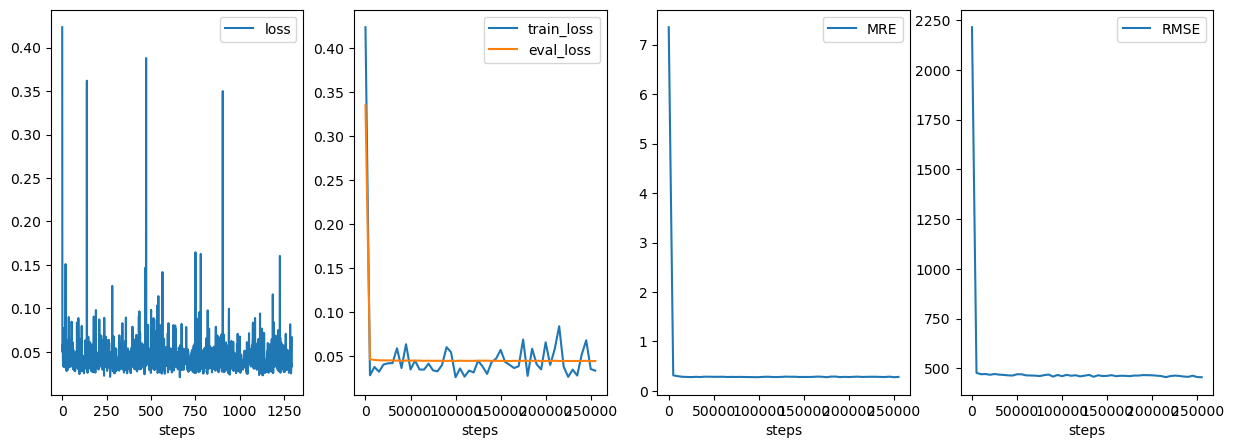

In [23]:
# model_type = ModelType.MLPTestSubgraph
# model_type = ModelType.LSTM
# model_type = ModelType.GRU
model_type = ModelType.GCNSubgraph
conf: Config = train_configs[model_type.name]
init_model = init_model_funcs[model_type.name]
model = init_model()
model = model.to(conf.device)
single_train_loop(model_type, conf, preprocessed_train_ds, preprocessed_eval_ds, model, compute_evaluate_metrics, to_device)

In [24]:
init_model_funcs = {
    ModelType.Transformer.name: init_Transformer_model,
    ModelType.GCNSubgraph.name: init_GCNSubgraph_model,
    ModelType.GRU.name: init_GRU_model,
    ModelType.LSTM.name: init_LSTM_model,
    ModelType.MLPTestSubgraph.name: init_MLPTestSubgraph_model,
    ModelType.RNN.name: init_RNN_model,
}

model_type = ModelType.GCNSubgraph
conf: Config = train_configs[model_type.name]
init_model = init_model_funcs[model_type.name]

model = init_model()
model = model.to(conf.device)
# grid_search_loop(model_type, 
#                  conf, 
#                  preprocessed_train_ds, 
#                  preprocessed_eval_ds, 
#                  compute_evaluate_metrics, 
#                  to_device,
#                  init_model,
#                  )

